# Dependencias
requiere reiniciar la notebook una vez instaladas

In [460]:
!pip install matplotlib --upgrade
!pip install squarify
!pip install -U pandas-profiling
!pip install basemap
!pip install dash jupyter_dash
!jupyter nbextension enable --py widgetsnbextension
!pip install flask flask-restful flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 325 kB 5.2 MB/s 
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 3.4.0
    Uninstalling pandas-profiling-3.4.0:
      Successfully uninstalled pandas-profiling-3.4.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.2 MB/s 


# Imports y Setup

## Imports

In [461]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import pickle
import requests
from bs4 import BeautifulSoup

#Graficos
import squarify
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from jupyter_dash import JupyterDash
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as ticker
%matplotlib inline

#Utils
import time 
import dash
import textwrap
import warnings
from dash.dependencies import Input, Output
from pandas_profiling import ProfileReport
from IPython.display import Markdown as md

#ML
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, make_scorer, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Implementación Modelos
from flask import Flask
from flask_restful import Resource, Api
from flask_ngrok import run_with_ngrok #para correrlo en colab ya que no tengo acceso al localhost o la ipv4 de la notebook

#Settings de pandas
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

## Colores de los graficos

Text(0.5, 1.0, 'Paleta Divergente')

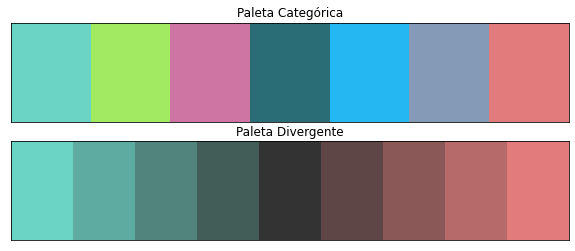

In [3]:
# @markdown Elije la paleta de colores que mas te guste para los graficos.
paleta = 'default' #@param ["default","protanopia","deuteranopia","tritanopia","achromatopsia"]

if paleta == 'default':
    cat_palette = ["#6cd4c5","#a3ea63","#cf75a4","#2a6d76","#25b7f1","#849ab7","#e27c7c"]
    div_palette = ["#e27c7c","#b76a6a","#8b5858","#5f4646","#333333","#425c58","#50847c","#5eaca1","#6cd4c5"]
elif paleta == 'protanopia':
    cat_palette = ["#9999c8","#c1c283","#a8a798","#474773","#6465e2","#8d8daf","#b5b47c"]
    div_palette = ["#b5b47c","#95946a","#747458","#545346","#333333","#4d4d58","#66667d","#7f80a3","#9999c8"]
elif paleta == 'deuteranopia':
    cat_palette = ["#938bc9","#bdb88b","#adb395","#433e73","#5b50df","#8c8aae","#bbc37c"]
    div_palette = ["#bbc37c","#9a9f69","#777b58","#555746","#333232","#4b4959","#635f7e","#7b75a4","#938bc9"]
elif paleta == 'tritanopia':
    cat_palette = ["#71cbcc","#a69da3","#ca8f8d","#2d7271","#2cd7d5","#85aaa9","#dc7c7c"]
    div_palette = ["#dc7c7c","#b36a6a","#885858","#5d4646","#323333","#435959","#527f7f","#61a5a6","#71cbcc"]
elif paleta == 'achromatopsia':
    cat_palette = ["#b3b3b3","#c5c5c5","#959595","#595959","#919191","#969696","#9a9a9a"]
    div_palette = ["#9a9a9a","#818181","#676767","#4d4d4d","#323232","#535353","#737373","#939393","#b3b3b3"]

def palplot(pal, size=1, ax=None, fig=None):
    """Plot the values in a color palette as a horizontal array.
    Parameters
    ----------
    pal : sequence of matplotlib colors
        colors, i.e. as returned by seaborn.color_palette()
    size :
        scaling factor for size of plot
    ax :
        an existing axes to use
    """
    n = len(pal)
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels(["" for _ in range(n)])
    fig.set_facecolor((0,0,0,0))
    fig.set_alpha(0.0)
    ax.set_xticks([])
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.set_facecolor((0,0,0,0))
    ax.set_alpha((0.0))

fig,ax = plt.subplots(2,1,figsize=(10,4))
palplot(cat_palette,size=10,ax=ax[0], fig=fig)
palplot(div_palette[::-1],size=10,ax=ax[1], fig=fig)
ax[0].set_title("Paleta Categórica")
ax[1].set_title("Paleta Divergente")

## Importo el Dataset

In [4]:
df = pd.read_csv('https://github.com/Lemonpi3/datasets-coderhouse/blob/main/telecom_customer_churn.csv?raw=true')

#normalizo las columnas del dataset para manejarlas de forma mas comoda con pandas
rename_dict = {}
cols = list(df.columns)
cols = [col.lower().replace(' ','_') for col in cols]

for key in list(df.columns):
    for value in cols:
        rename_dict[key] = value
        cols.remove(value)
        break

df = df.rename(rename_dict,axis=1)
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Creo la Columna County

Ayudara a la exploración de datos agrupando a las ciudades por condado.
>
La data sale de https://geographic.org/streetview/usa/ca/ y complemento las pocas que no se pudieron extraer de ahi con una busqueda en google.

### Prueba a menor escala.

Aseguremosnos que el proceso de extraccion funcione bien antes de pasarlo por todos los counties.

In [5]:
main_url = 'https://geographic.org/streetview/usa/ca/'

counties = ['alameda','alpine','amador', 'butte', 'calaveras', 'colusa', 
'contra_costa', 'del_norte', 'el_dorado', 
'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen',
'los_angeles', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 
'monterey', 'napa', 'nevada', 'orange', 'placer', 'plumas', 'riverside', 'sacramento',
'san_benito', 'san_bernardino', 'san_diego', 'san_francisco', 'san_joaquin', 'san_luis_obispo',
'san_mateo', 'santa_barbara', 'santa_clara', 'santa_cruz', 'shasta', 'sierra', 'siskiyou',
'solano', 'sonoma', 'stanislaus', 'sutter', 'tehama', 'trinity', 'tulare', 'tuolumne', 'ventura',
 'yolo', 'yuba']

#donde voy a guardarlos
condados = {}

In [6]:
r = requests.get(main_url+counties[0])
r

<Response [200]>

In [7]:
soup = BeautifulSoup(r.content)
soup

<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8"/>
<meta content="Alameda County, California, United States, maps, List of Towns and Cities, Street View, Geographic.org" name="Description"/>
<meta content="Alameda County, California, List of Towns and Cities, maps, United States, Street View, Geographic.org" name="keywords"/>
<title>List of Towns and Cities in Alameda County, California, United States, Maps and Steet Views, Geographic.org</title>
<meta content="width=device-width; initial-scale=1.0; maximum-scale=1.0;" name="viewport"/>
<link href="https://geographic.org/streetview/usa/ca/alameda/index.html" rel="canonical"/>
<!--Taboola Head Section-->
<script type="text/javascript">
</script>
<!--End Taboola Head Section-->
<style type="text/css"> 
A:link { text-decoration: none;  color:#0000FF; }
A:visited { text-decoration: none;  color:#000066; }
A:active { text-decoration: none;  color:#000066; }
A:hover { text-decoration: none; color:#990033; } 
a {  text-decoration: none}
</

In [8]:
ciudades_del_condado = soup.find_all('li')
ciudades_del_condado

[<li><a alt="Alameda" href="alameda.html">Alameda</a></li>,
 <li><a alt="Albany" href="albany.html">Albany</a></li>,
 <li><a alt="Berkeley" href="berkeley.html">Berkeley</a></li>,
 <li><a alt="Castro Valley" href="castro_valley.html">Castro Valley</a></li>,
 <li><a alt="Dublin" href="dublin.html">Dublin</a></li>,
 <li><a alt="Emeryville" href="emeryville.html">Emeryville</a></li>,
 <li><a alt="Fremont" href="fremont.html">Fremont</a></li>,
 <li><a alt="Hayward" href="hayward.html">Hayward</a></li>,
 <li><a alt="Livermore" href="livermore.html">Livermore</a></li>,
 <li><a alt="Newark" href="newark.html">Newark</a></li>,
 <li><a alt="Oakland" href="oakland.html">Oakland</a></li>,
 <li><a alt="Pleasanton" href="pleasanton.html">Pleasanton</a></li>,
 <li><a alt="San Leandro" href="san_leandro.html">San Leandro</a></li>,
 <li><a alt="San Lorenzo" href="san_lorenzo.html">San Lorenzo</a></li>,
 <li><a alt="Sunol" href="sunol.html">Sunol</a></li>,
 <li><a alt="Union City" href="union_city.html

In [9]:
ciudades = []
for ciudad in ciudades_del_condado:
  ciudades.append(ciudad.text)
  
condados[counties[0]] = ciudades
condados

{'alameda': ['Alameda',
  'Albany',
  'Berkeley',
  'Castro Valley',
  'Dublin',
  'Emeryville',
  'Fremont',
  'Hayward',
  'Livermore',
  'Newark',
  'Oakland',
  'Pleasanton',
  'San Leandro',
  'San Lorenzo',
  'Sunol',
  'Union City']}

### Extracción de los datos.

Como todo parece que esta en orden, vamos a extraer el resto de los counties.

In [10]:
#Con el fin de no hacer que la notebook tarde mas de lo necesario en correr 
#decidi comentar el codigo de extracción y dejar los resultados ya extraidos en la siguiente celda.

# condados = {}

# for i,county in enumerate(counties):
#   if i%10 == 0 and i != 0:
#     time.sleep(60)
#   print(f'{i} de {len(counties)}')
#   r = requests.get(main_url+county)
#   soup = BeautifulSoup(r.content)
#   ciudades_del_condado = soup.find_all('li')

#   ciudades = []
#   for ciudad in ciudades_del_condado:
#     ciudades.append(ciudad.text)
  
#   condados[county] = ciudades

In [11]:
#@markdown Guardo condados en esta celda de codigo en caso de que lo borre 
#@markdown o modifique por accidente
condados = {'alameda': ['Alameda',
  'Albany',
  'Berkeley',
  'Castro Valley',
  'Dublin',
  'Emeryville',
  'Fremont',
  'Hayward',
  'Livermore',
  'Newark',
  'Oakland',
  'Pleasanton',
  'San Leandro',
  'San Lorenzo',
  'Sunol',
  'Union City'],
 'alpine': ['Kirkwood', 'Markleeville'],
 'amador': ['Amador City',
  'Drytown',
  'Fiddletown',
  'Ione',
  'Jackson',
  'Kit Carson',
  'Martell',
  'Pine Grove',
  'Pioneer',
  'Plymouth',
  'River Pines',
  'Sutter Creek',
  'Volcano'],
 'butte': ['Bangor',
  'Berry Creek',
  'Biggs',
  'Chico',
  'Clipper Mills',
  'Durham',
  'Feather Falls',
  'Forbestown',
  'Forest Ranch',
  'Gridley',
  'Magalia',
  'Nelson',
  'Oroville',
  'Palermo',
  'Paradise',
  'Richvale',
  'Stirling City'],
 'calaveras': ['Altaville',
  'Angels Camp',
  'Arnold',
  'Avery',
  'Burson',
  'Campo Seco',
  'Copperopolis',
  'Douglas Flat',
  'Glencoe',
  'Hathaway Pines',
  'Mokelumne Hill',
  'Mountain Ranch',
  'Murphys',
  'Rail Road Flat',
  'San Andreas',
  'Vallecito',
  'Valley Springs',
  'Wallace',
  'West Point',
  'Wilseyville'],
 'colusa': ['Arbuckle',
  'Colusa',
  'Grimes',
  'Maxwell',
  'Princeton',
  'Stonyford',
  'Williams'],
 'contra_costa': ['Alamo',
  'Antioch',
  'Bethel Island',
  'Brentwood',
  'Byron',
  'Canyon',
  'Clayton',
  'Concord',
  'Crockett',
  'Danville',
  'Diablo',
  'Discovery Bay',
  'El Cerrito',
  'El Sobrante',
  'Hercules',
  'Knightsen',
  'Lafayette',
  'Martinez',
  'Moraga',
  'Oakley',
  'Orinda',
  'Pinole',
  'Pittsburg',
  'Pleasant Hill',
  'Port Costa',
  'Richmond',
  'Rodeo',
  'San Pablo',
  'San Ramon',
  'Walnut Creek'],
 'del_norte': ['Crescent City',
  'Fort Dick',
  'Gasquet',
  'Klamath',
  'Smith River'],
 'el_dorado': ['Camino',
  'Coloma',
  'Cool',
  'Diamond Springs',
  'Echo Lake',
  'El Dorado',
  'El Dorado Hills',
  'Garden Valley',
  'Georgetown',
  'Greenwood',
  'Grizzly Flats',
  'Kyburz',
  'Lotus',
  'Mount Aukum',
  'Pilot Hill',
  'Placerville',
  'Pollock Pines',
  'Rescue',
  'Shingle Springs',
  'Somerset',
  'South Lake Tahoe',
  'Tahoma',
  'Twin Bridges'],
 'fresno': ['Auberry',
  'Big Creek',
  'Biola',
  'Burrel',
  'Cantua Creek',
  'Caruthers',
  'Clovis',
  'Coalinga',
  'Del Rey',
  'Dunlap',
  'Firebaugh',
  'Five Points',
  'Fowler',
  'Fresno',
  'Friant',
  'Helm',
  'Hume',
  'Huron',
  'Kerman',
  'Kingsburg',
  'Lakeshore',
  'Laton',
  'Mendota',
  'Miramonte',
  'Mono Hot Springs',
  'Orange Cove',
  'Parlier',
  'Piedra',
  'Prather',
  'Raisin City',
  'Reedley',
  'Riverdale',
  'San Joaquin',
  'Sanger',
  'Selma',
  'Shaver Lake',
  'Squaw Valley',
  'Tollhouse',
  'Tranquillity'],
 'glenn': ['Artois',
  'Butte City',
  'Elk Creek',
  'Glenn',
  'Hamilton City',
  'Orland',
  'Willows'],
 'humboldt': ['Alderpoint',
  'Arcata',
  'Bayside',
  'Blocksburg',
  'Blue Lake',
  'Bridgeville',
  'Carlotta',
  'Eureka',
  'Ferndale',
  'Fields Landing',
  'Fortuna',
  'Garberville',
  'Honeydew',
  'Hoopa',
  'Hydesville',
  'Kneeland',
  'Korbel',
  'Loleta',
  'Mckinleyville',
  'Miranda',
  'Myers Flat',
  'Orick',
  'Orleans',
  'Petrolia',
  'Phillipsville',
  'Redcrest',
  'Redway',
  'Rio Dell',
  'Samoa',
  'Scotia',
  'Trinidad',
  'Weott',
  'Whitethorn',
  'Willow Creek'],
 'imperial': ['Bard',
  'Brawley',
  'Calexico',
  'Calipatria',
  'El Centro',
  'Heber',
  'Holtville',
  'Imperial',
  'Niland',
  'Ocotillo',
  'Palo Verde',
  'Salton City',
  'Seeley',
  'Westmorland',
  'Winterhaven'],
 'inyo': ['Big Pine',
  'Bishop',
  'Darwin',
  'Death Valley',
  'Independence',
  'Keeler',
  'Little Lake',
  'Lone Pine',
  'Olancha',
  'Shoshone',
  'Tecopa'],
 'kern': ['Arvin',
  'Bakersfield',
  'Bodfish',
  'Boron',
  'Buttonwillow',
  'Caliente',
  'California City',
  'Cantil',
  'Delano',
  'Edison',
  'Edwards',
  'Fellows',
  'Frazier Park',
  'Glennville',
  'Inyokern',
  'Johannesburg',
  'Keene',
  'Kernville',
  'Lake Isabella',
  'Lamont',
  'Lebec',
  'Lost Hills',
  'Maricopa',
  'Mc Farland',
  'Mc Kittrick',
  'Mojave',
  'Onyx',
  'Pine Mountain Club',
  'Randsburg',
  'Red Mountain',
  'Ridgecrest',
  'Rosamond',
  'Shafter',
  'Taft',
  'Tehachapi',
  'Tupman',
  'Wasco',
  'Weldon',
  'Wofford Heights',
  'Woody'],
 'kings': ['Armona',
  'Avenal',
  'Corcoran',
  'Hanford',
  'Kettleman City',
  'Lemoore',
  'Stratford'],
 'lake': ['Clearlake',
  'Clearlake Oaks',
  'Clearlake Park',
  'Cobb',
  'Finley',
  'Glenhaven',
  'Hidden Valley Lake',
  'Kelseyville',
  'Lakeport',
  'Lower Lake',
  'Lucerne',
  'Middletown',
  'Nice',
  'Upper Lake',
  'Witter Springs'],
 'lassen': ['Bieber',
  'Doyle',
  'Herlong',
  'Janesville',
  'Litchfield',
  'Madeline',
  'Milford',
  'Nubieber',
  'Ravendale',
  'Standish',
  'Susanville',
  'Termo',
  'Wendel',
  'Westwood'],
 'los_angeles': ['Acton',
  'Agoura Hills',
  'Alhambra',
  'Altadena',
  'Arcadia',
  'Artesia',
  'Avalon',
  'Azusa',
  'Baldwin Park',
  'Bell Gardens',
  'Bellflower',
  'Beverly Hills',
  'Burbank',
  'Calabasas',
  'Canoga Park',
  'Canyon Country',
  'Carson',
  'Castaic',
  'Cerritos',
  'Chatsworth',
  'Claremont',
  'Compton',
  'Covina',
  'Culver City',
  'Diamond Bar',
  'Downey',
  'Duarte',
  'El Monte',
  'El Segundo',
  'Encino',
  'Gardena',
  'Glendale',
  'Glendora',
  'Granada Hills',
  'Hacienda Heights',
  'Harbor City',
  'Hawaiian Gardens',
  'Hawthorne',
  'Hermosa Beach',
  'Huntington Park',
  'Inglewood',
  'La Canada Flintridge',
  'La Crescenta',
  'La Mirada',
  'La Puente',
  'La Verne',
  'Lake Hughes',
  'Lakewood',
  'Lancaster',
  'Lawndale',
  'Littlerock',
  'Llano',
  'Lomita',
  'Long Beach',
  'Los Angeles',
  'Lynwood',
  'Malibu',
  'Manhattan Beach',
  'Marina Del Rey',
  'Maywood',
  'Mission Hills',
  'Monrovia',
  'Montebello',
  'Monterey Park',
  'Montrose',
  'Mount Wilson',
  'Newhall',
  'North Hills',
  'North Hollywood',
  'Northridge',
  'Norwalk',
  'Pacific Palisades',
  'Pacoima',
  'Palmdale',
  'Palos Verdes Peninsula',
  'Panorama City',
  'Paramount',
  'Pasadena',
  'Pearblossom',
  'Pico Rivera',
  'Playa Del Rey',
  'Playa Vista',
  'Pomona',
  'Porter Ranch',
  'Rancho Palos Verdes',
  'Redondo Beach',
  'Reseda',
  'Rosemead',
  'Rowland Heights',
  'San Dimas',
  'San Fernando',
  'San Gabriel',
  'San Marino',
  'San Pedro',
  'Santa Clarita',
  'Santa Fe Springs',
  'Santa Monica',
  'Sherman Oaks',
  'Sierra Madre',
  'Signal Hill',
  'South El Monte',
  'South Gate',
  'South Pasadena',
  'Stevenson Ranch',
  'Studio City',
  'Sun Valley',
  'Sunland',
  'Sylmar',
  'Tarzana',
  'Temple City',
  'Topanga',
  'Torrance',
  'Tujunga',
  'Valencia',
  'Valley Village',
  'Valyermo',
  'Van Nuys',
  'Venice',
  'Verdugo City',
  'Walnut',
  'West Covina',
  'West Hills',
  'West Hollywood',
  'Whittier',
  'Wilmington',
  'Winnetka',
  'Woodland Hills'],
 'madera': ['Ahwahnee',
  'Bass Lake',
  'Chowchilla',
  'Coarsegold',
  'Madera',
  'North Fork',
  'O Neals',
  'Oakhurst',
  'Raymond',
  'Wishon'],
 'marin': ['Belvedere Tiburon',
  'Bolinas',
  'Corte Madera',
  'Dillon Beach',
  'Fairfax',
  'Forest Knolls',
  'Greenbrae',
  'Inverness',
  'Lagunitas',
  'Larkspur',
  'Marshall',
  'Mill Valley',
  'Nicasio',
  'Novato',
  'Olema',
  'Point Reyes Station',
  'Ross',
  'San Anselmo',
  'San Geronimo',
  'San Quentin',
  'San Rafael',
  'Sausalito',
  'Stinson Beach',
  'Tomales',
  'Woodacre'],
 'mariposa': ['Catheys Valley',
  'Coulterville',
  'El Portal',
  'Fish Camp',
  'Hornitos',
  'Mariposa',
  'Midpines',
  'Yosemite National Park'],
 'mendocino': ['Albion',
  'Boonville',
  'Branscomb',
  'Calpella',
  'Caspar',
  'Comptche',
  'Covelo',
  'Dos Rios',
  'Elk',
  'Fort Bragg',
  'Gualala',
  'Hopland',
  'Laytonville',
  'Leggett',
  'Little River',
  'Manchester',
  'Mendocino',
  'Navarro',
  'Philo',
  'Piercy',
  'Point Arena',
  'Potter Valley',
  'Redwood Valley',
  'Talmage',
  'Ukiah',
  'Westport',
  'Willits',
  'Yorkville'],
 'merced': ['Atwater',
  'Ballico',
  'Cressey',
  'Delhi',
  'Dos Palos',
  'El Nido',
  'Gustine',
  'Hilmar',
  'Le Grand',
  'Livingston',
  'Los Banos',
  'Merced',
  'Planada',
  'Santa Rita Park',
  'Snelling',
  'South Dos Palos',
  'Stevinson',
  'Winton'],
 'modoc': ['Adin',
  'Alturas',
  'Canby',
  'Cedarville',
  'Davis Creek',
  'Eagleville',
  'Fort Bidwell',
  'Lake City',
  'Likely',
  'Lookout'],
 'mono': ['Benton',
  'Bridgeport',
  'Coleville',
  'June Lake',
  'Lee Vining',
  'Mammoth Lakes',
  'Topaz'],
 'monterey': ['Aromas',
  'Big Sur',
  'Bradley',
  'Carmel',
  'Carmel By The Sea',
  'Carmel Valley',
  'Castroville',
  'Chualar',
  'Gonzales',
  'Greenfield',
  'Jolon',
  'King City',
  'Lockwood',
  'Marina',
  'Monterey',
  'Moss Landing',
  'Pacific Grove',
  'Pebble Beach',
  'Salinas',
  'San Ardo',
  'San Lucas',
  'Seaside',
  'Soledad',
  'Spreckels'],
 'napa': ['American Canyon',
  'Angwin',
  'Calistoga',
  'Deer Park',
  'Napa',
  'Oakville',
  'Pope Valley',
  'Rutherford',
  'Saint Helena',
  'Yountville'],
 'nevada': ['Cedar Ridge',
  'Chicago Park',
  'Floriston',
  'Grass Valley',
  'Nevada City',
  'Norden',
  'North San Juan',
  'Penn Valley',
  'Rough And Ready',
  'Smartsville',
  'Soda Springs',
  'Truckee',
  'Washington'],
 'orange': ['Aliso Viejo',
  'Anaheim',
  'Brea',
  'Buena Park',
  'Capistrano Beach',
  'Corona Del Mar',
  'Costa Mesa',
  'Cypress',
  'Dana Point',
  'Foothill Ranch',
  'Fountain Valley',
  'Fullerton',
  'Garden Grove',
  'Huntington Beach',
  'Irvine',
  'La Habra',
  'La Palma',
  'Ladera Ranch',
  'Laguna Beach',
  'Laguna Hills',
  'Laguna Niguel',
  'Laguna Woods',
  'Lake Forest',
  'Los Alamitos',
  'Midway City',
  'Mission Viejo',
  'Newport Beach',
  'Newport Coast',
  'Orange',
  'Placentia',
  'Rancho Santa Margarita',
  'San Clemente',
  'San Juan Capistrano',
  'Santa Ana',
  'Seal Beach',
  'Silverado',
  'Stanton',
  'Sunset Beach',
  'Surfside',
  'Trabuco Canyon',
  'Tustin',
  'Villa Park',
  'Westminster',
  'Yorba Linda'],
 'placer': ['Alta',
  'Applegate',
  'Auburn',
  'Carnelian Bay',
  'Colfax',
  'Dutch Flat',
  'Emigrant Gap',
  'Foresthill',
  'Gold Run',
  'Granite Bay',
  'Homewood',
  'Kings Beach',
  'Lincoln',
  'Loomis',
  'Meadow Vista',
  'Newcastle',
  'Olympic Valley',
  'Penryn',
  'Rocklin',
  'Roseville',
  'Sheridan',
  'Tahoe City',
  'Tahoe Vista',
  'Weimar'],
 'plumas': ['Beckwourth',
  'Belden',
  'Blairsden-Graeagle',
  'Canyon Dam',
  'Chester',
  'Chilcoot',
  'Clio',
  'Crescent Mills',
  'Greenville',
  'Meadow Valley',
  'Portola',
  'Quincy',
  'Storrie',
  'Taylorsville',
  'Twain',
  'Vinton'],
 'riverside': ['Aguanga',
  'Anza',
  'Banning',
  'Beaumont',
  'Blythe',
  'Cabazon',
  'Calimesa',
  'Cathedral City',
  'Coachella',
  'Corona',
  'Desert Center',
  'Desert Hot Springs',
  'Hemet',
  'Homeland',
  'Idyllwild',
  'Indian Wells',
  'Indio',
  'La Quinta',
  'Lake Elsinore',
  'Mecca',
  'Menifee',
  'Mira Loma',
  'Moreno Valley',
  'Mountain Center',
  'Murrieta',
  'Norco',
  'North Palm Springs',
  'Nuevo',
  'Palm Desert',
  'Palm Springs',
  'Perris',
  'Quail Valley',
  'Rancho Mirage',
  'Riverside',
  'San Jacinto',
  'Sun City',
  'Temecula',
  'Thermal',
  'Thousand Palms',
  'Whitewater',
  'Wildomar',
  'Winchester'],
 'sacramento': ['Antelope',
  'Carmichael',
  'Citrus Heights',
  'Courtland',
  'Elk Grove',
  'Elverta',
  'Fair Oaks',
  'Folsom',
  'Galt',
  'Herald',
  'Hood',
  'Isleton',
  'Mather',
  'Mcclellan',
  'North Highlands',
  'Orangevale',
  'Rancho Cordova',
  'Rio Linda',
  'Ryde',
  'Sacramento',
  'Sloughhouse',
  'Walnut Grove',
  'Wilton'],
 'san_benito': ['Hollister', 'Paicines', 'San Juan Bautista', 'Tres Pinos'],
 'san_bernardino': ['Adelanto',
  'Amboy',
  'Angelus Oaks',
  'Apple Valley',
  'Baker',
  'Barstow',
  'Big Bear City',
  'Big Bear Lake',
  'Bloomington',
  'Blue Jay',
  'Bryn Mawr',
  'Cedar Glen',
  'Cedarpines Park',
  'Chino',
  'Chino Hills',
  'Cima',
  'Colton',
  'Crestline',
  'Daggett',
  'Earp',
  'Essex',
  'Fawnskin',
  'Fontana',
  'Forest Falls',
  'Fort Irwin',
  'Grand Terrace',
  'Green Valley Lake',
  'Guasti',
  'Helendale',
  'Hesperia',
  'Highland',
  'Hinkley',
  'Joshua Tree',
  'Lake Arrowhead',
  'Landers',
  'Loma Linda',
  'Lucerne Valley',
  'Ludlow',
  'Lytle Creek',
  'Mentone',
  'Montclair',
  'Morongo Valley',
  'Mountain Pass',
  'Mt Baldy',
  'Needles',
  'Newberry Springs',
  'Nipton',
  'Ontario',
  'Oro Grande',
  'Parker Dam',
  'Phelan',
  'Pinon Hills',
  'Pioneertown',
  'Rancho Cucamonga',
  'Redlands',
  'Rialto',
  'Rimforest',
  'Running Springs',
  'San Bernardino',
  'Skyforest',
  'Sugarloaf',
  'Trona',
  'Twentynine Palms',
  'Twin Peaks',
  'Upland',
  'Victorville',
  'Vidal',
  'Wrightwood',
  'Yermo',
  'Yucaipa',
  'Yucca Valley'],
 'san_diego': ['Alpine',
  'Bonita',
  'Bonsall',
  'Borrego Springs',
  'Boulevard',
  'Camp Pendleton',
  'Campo',
  'Cardiff By The Sea',
  'Carlsbad',
  'Chula Vista',
  'Coronado',
  'Del Mar',
  'Descanso',
  'Dulzura',
  'El Cajon',
  'Encinitas',
  'Escondido',
  'Fallbrook',
  'Guatay',
  'Imperial Beach',
  'Jacumba',
  'Jamul',
  'Julian',
  'La Jolla',
  'La Mesa',
  'Lakeside',
  'Lemon Grove',
  'Mount Laguna',
  'National City',
  'Oceanside',
  'Pala',
  'Palomar Mountain',
  'Pauma Valley',
  'Pine Valley',
  'Potrero',
  'Poway',
  'Ramona',
  'Ranchita',
  'Rancho Santa Fe',
  'San Diego',
  'San Luis Rey',
  'San Marcos',
  'San Ysidro',
  'Santa Ysabel',
  'Santee',
  'Solana Beach',
  'Spring Valley',
  'Tecate',
  'Valley Center',
  'Vista',
  'Warner Springs'],
 'san_francisco': ['San Francisco'],
 'san_joaquin': ['Acampo',
  'Clements',
  'Escalon',
  'Farmington',
  'French Camp',
  'Holt',
  'Lathrop',
  'Linden',
  'Lockeford',
  'Lodi',
  'Manteca',
  'Ripon',
  'Stockton',
  'Thornton',
  'Tracy',
  'Vernalis',
  'Victor',
  'Woodbridge'],
 'san_luis_obispo': ['Arroyo Grande',
  'Atascadero',
  'Avila Beach',
  'Cambria',
  'Cayucos',
  'Creston',
  'Grover Beach',
  'Harmony',
  'Los Osos',
  'Morro Bay',
  'Nipomo',
  'Oceano',
  'Paso Robles',
  'Pismo Beach',
  'San Luis Obispo',
  'San Miguel',
  'San Simeon',
  'Santa Margarita',
  'Shandon',
  'Templeton'],
 'san_mateo': ['Atherton',
  'Belmont',
  'Brisbane',
  'Burlingame',
  'Daly City',
  'El Granada',
  'Half Moon Bay',
  'La Honda',
  'Loma Mar',
  'Menlo Park',
  'Millbrae',
  'Montara',
  'Moss Beach',
  'Pacifica',
  'Pescadero',
  'Portola Valley',
  'Redwood City',
  'San Bruno',
  'San Carlos',
  'San Francisco',
  'San Gregorio',
  'San Mateo',
  'South San Francisco'],
 'santa_barbara': ['Buellton',
  'Carpinteria',
  'Casmalia',
  'Goleta',
  'Guadalupe',
  'Lompoc',
  'Los Alamos',
  'Los Olivos',
  'New Cuyama',
  'Santa Barbara',
  'Santa Maria',
  'Santa Ynez',
  'Solvang',
  'Summerland'],
 'santa_clara': ['Alviso',
  'Campbell',
  'Coyote',
  'Cupertino',
  'Gilroy',
  'Holy City',
  'Los Altos',
  'Los Gatos',
  'Milpitas',
  'Morgan Hill',
  'Mount Hamilton',
  'Mountain View',
  'Palo Alto',
  'Redwood Estates',
  'San Jose',
  'San Martin',
  'Santa Clara',
  'Saratoga',
  'Stanford',
  'Sunnyvale'],
 'santa_cruz': ['Aptos',
  'Ben Lomond',
  'Boulder Creek',
  'Brookdale',
  'Capitola',
  'Davenport',
  'Felton',
  'Freedom',
  'Los Gatos',
  'Mount Hermon',
  'Santa Cruz',
  'Scotts Valley',
  'Soquel',
  'Watsonville'],
 'shasta': ['Anderson',
  'Bella Vista',
  'Big Bend',
  'Burney',
  'Cassel',
  'Castella',
  'Cottonwood',
  'Fall River Mills',
  'French Gulch',
  'Hat Creek',
  'Igo',
  'Lakehead',
  'Mcarthur',
  'Millville',
  'Montgomery Creek',
  'Oak Run',
  'Obrien',
  'Old Station',
  'Palo Cedro',
  'Platina',
  'Redding',
  'Round Mountain',
  'Shasta',
  'Shasta Lake',
  'Shingletown',
  'Whiskeytown',
  'Whitmore'],
 'sierra': ['Alleghany',
  'Calpine',
  'Downieville',
  'Goodyears Bar',
  'Loyalton',
  'Sierra City',
  'Sierraville'],
 'siskiyou': ['Callahan',
  'Dorris',
  'Dunsmuir',
  'Etna',
  'Forks of Salmon',
  'Fort Jones',
  'Gazelle',
  'Greenview',
  'Grenada',
  'Happy Camp',
  'Hornbrook',
  'Klamath River',
  'Macdoel',
  'Mccloud',
  'Montague',
  'Mount Shasta',
  'Scott Bar',
  'Seiad Valley',
  'Somes Bar',
  'Tulelake',
  'Weed',
  'Yreka'],
 'solano': ['Benicia',
  'Birds Landing',
  'Dixon',
  'Elmira',
  'Fairfield',
  'Rio Vista',
  'Suisun City',
  'Vacaville',
  'Vallejo'],
 'sonoma': ['Annapolis',
  'Bodega',
  'Bodega Bay',
  'Boyes Hot Springs',
  'Camp Meeker',
  'Cazadero',
  'Cloverdale',
  'Cotati',
  'Duncans Mills',
  'El Verano',
  'Eldridge',
  'Forestville',
  'Fulton',
  'Geyserville',
  'Glen Ellen',
  'Graton',
  'Guerneville',
  'Healdsburg',
  'Jenner',
  'Kenwood',
  'Monte Rio',
  'Occidental',
  'Penngrove',
  'Petaluma',
  'Rio Nido',
  'Rohnert Park',
  'Santa Rosa',
  'Sebastopol',
  'Sonoma',
  'Stewarts Point',
  'The Sea Ranch',
  'Valley Ford',
  'Villa Grande',
  'Vineburg',
  'Windsor'],
 'stanislaus': ['Ceres',
  'Crows Landing',
  'Denair',
  'Empire',
  'Hickman',
  'Hughson',
  'Keyes',
  'La Grange',
  'Modesto',
  'Newman',
  'Oakdale',
  'Patterson',
  'Riverbank',
  'Salida',
  'Turlock',
  'Waterford',
  'Westley'],
 'sutter': ['Live Oak',
  'Meridian',
  'Nicolaus',
  'Pleasant Grove',
  'Rio Oso',
  'Robbins',
  'Sutter',
  'Yuba City'],
 'tehama': ['Corning',
  'Flournoy',
  'Gerber',
  'Los Molinos',
  'Manton',
  'Mill Creek',
  'Mineral',
  'Paskenta',
  'Paynes Creek',
  'Proberta',
  'Red Bluff',
  'Tehama',
  'Vina'],
 'trinity': ['Big Bar',
  'Burnt Ranch',
  'Douglas City',
  'Hayfork',
  'Hyampom',
  'Junction City',
  'Lewiston',
  'Mad River',
  'Salyer',
  'Trinity Center',
  'Weaverville',
  'Zenia'],
 'tulare': ['Alpaugh',
  'Badger',
  'California Hot Springs',
  'Camp Nelson',
  'Cutler',
  'Dinuba',
  'Ducor',
  'Earlimart',
  'Exeter',
  'Farmersville',
  'Goshen',
  'Ivanhoe',
  'Kaweah',
  'Kings Canyon National Park',
  'Lemon Cove',
  'Lindsay',
  'Orosi',
  'Pixley',
  'Porterville',
  'Posey',
  'Richgrove',
  'Sequoia National Park',
  'Springville',
  'Strathmore',
  'Sultana',
  'Terra Bella',
  'Three Rivers',
  'Tipton',
  'Traver',
  'Tulare',
  'Visalia',
  'Waukena',
  'Woodlake',
  'Yettem'],
 'tuolumne': ['Big Oak Flat',
  'Chinese Camp',
  'Columbia',
  'Groveland',
  'Jamestown',
  'Long Barn',
  'Mi Wuk Village',
  'Moccasin',
  'Pinecrest',
  'Sonora',
  'Soulsbyville',
  'Standard',
  'Strawberry',
  'Tuolumne',
  'Twain Harte'],
 'ventura': ['Camarillo',
  'Fillmore',
  'Moorpark',
  'Newbury Park',
  'Oak Park',
  'Oak View',
  'Ojai',
  'Oxnard',
  'Piru',
  'Port Hueneme',
  'Santa Paula',
  'Simi Valley',
  'Somis',
  'Thousand Oaks',
  'Ventura',
  'Westlake Village'],
 'yolo': ['Brooks',
  'Capay',
  'Clarksburg',
  'Davis',
  'Dunnigan',
  'Esparto',
  'Guinda',
  'Knights Landing',
  'Madison',
  'Rumsey',
  'West Sacramento',
  'Winters',
  'Woodland',
  'Yolo',
  'Zamora'],
 'yuba': ['Browns Valley',
  'Brownsville',
  'Camptonville',
  'Challenge',
  'Dobbins',
  'Marysville',
  'Olivehurst',
  'Oregon House',
  'Rackerby',
  'Strawberry Valley',
  'Wheatland']}

In [12]:
print(condados)

{'alameda': ['Alameda', 'Albany', 'Berkeley', 'Castro Valley', 'Dublin', 'Emeryville', 'Fremont', 'Hayward', 'Livermore', 'Newark', 'Oakland', 'Pleasanton', 'San Leandro', 'San Lorenzo', 'Sunol', 'Union City'], 'alpine': ['Kirkwood', 'Markleeville'], 'amador': ['Amador City', 'Drytown', 'Fiddletown', 'Ione', 'Jackson', 'Kit Carson', 'Martell', 'Pine Grove', 'Pioneer', 'Plymouth', 'River Pines', 'Sutter Creek', 'Volcano'], 'butte': ['Bangor', 'Berry Creek', 'Biggs', 'Chico', 'Clipper Mills', 'Durham', 'Feather Falls', 'Forbestown', 'Forest Ranch', 'Gridley', 'Magalia', 'Nelson', 'Oroville', 'Palermo', 'Paradise', 'Richvale', 'Stirling City'], 'calaveras': ['Altaville', 'Angels Camp', 'Arnold', 'Avery', 'Burson', 'Campo Seco', 'Copperopolis', 'Douglas Flat', 'Glencoe', 'Hathaway Pines', 'Mokelumne Hill', 'Mountain Ranch', 'Murphys', 'Rail Road Flat', 'San Andreas', 'Vallecito', 'Valley Springs', 'Wallace', 'West Point', 'Wilseyville'], 'colusa': ['Arbuckle', 'Colusa', 'Grimes', 'Maxwell'

### Armado de la columna

In [13]:
temp_dict = {'county':[],'city':[]}

for key in condados.keys():
  for city in condados[key]:
    temp_dict['county'].append(key)
    temp_dict['city'].append(city)

temp_county_df = pd.DataFrame(temp_dict)
temp_county_df

,county,city
0,alameda,Alameda
1,alameda,Albany
2,alameda,Berkeley
3,alameda,Castro Valley
4,alameda,Dublin
...,...,...
1216,yuba,Olivehurst
1217,yuba,Oregon House
1218,yuba,Rackerby
1219,yuba,Strawberry Valley


In [14]:
counties_col = []

#Añado estas ciudades manualmente ya que no se encontraban en la página
temp = pd.DataFrame({'county':['riverside','calaveras','yuba','riverside','solano','plumas','los_angeles','yuba', 'siskiyou'],
                       'city':['White Water','Sheep Ranch','Beale Afb','March Air Reserve Base','Travis Afb','Blairsden Graeagle','Bell','Smartville', 'Forks Of Salmon']})
temp_county_df = pd.concat([temp_county_df,temp])

for i in range(len(df.city)):
  try:
    counties_col.append(temp_county_df[temp_county_df.city == df.iloc[i].city]['county'].to_list()[0])
  except:
    #Para encontrar los indices de las filas faltantes y buscarlas
    print(i)
    
df['county'] = counties_col
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason,county
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,kern
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,los_angeles
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,orange
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,contra_costa
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,ventura


# Utils/Helpers

In [284]:
#Colores y decoradores para los print
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def wheel_chart(X,ax,colors,width=0.3,radius=1,fontdict ={'color': 'darkred', 'weight': 'bold', 'size': 16,}):
    size_of_groups= round(X.value_counts(normalize=True) *100,2).values
    cmap = sns.color_palette(colors)
    labels = [X.unique()[i] + f'\n{g}%'for i,g in enumerate(size_of_groups)]
    ax.pie(size_of_groups,labels=labels, radius=radius,colors = cmap[:len(X.unique())],
            wedgeprops=dict(width=width),textprops=fontdict)

def cat_comp_wheel_chart(X,ax,colors,title='',width=0.3,radius=1,fontdict ={'color': 'darkred', 'weight': 'bold', 'size': 16,}):
    size_of_groups=round(X * 100,2)
    cmap = sns.color_palette(colors)
    text_labels = X.index
    labels = [text_labels[i] + f'\n{g}%'for i,g in enumerate(size_of_groups)]
    ax.pie(size_of_groups,labels=labels, radius=radius,colors = cmap[:len(text_labels)],
            wedgeprops=dict(width=width),textprops=fontdict)
    ax.set_title(title,fontdict)

def plot_scatter_map(df, alpha=0.7, title='', ax=None ,dot_color='blue',land_color='grey',water_col='lightblue', marcar_ciudades=True, fontdict ={'color': 'white', 'weight': 'bold', 'size': 7,}):
  '''
  Dibuja un scatter con el mapa de california
  Parametros:
  df: el dataframe ya filtrado (usa la latitud y longitud)
  alpha: transparencia de los puntitos. Por defecto es 0.7
  title: titulo del grafico (requiere pasar ax)
  ax: el axis de matplotlib
  marcar_ciudades: si es igual a True marca las ciudades de Sacramento, San Fracisco 
  ,Los Angeles y San Diego (True por defecto, requiere pasar ax)
  
  retorna==>> dibuja el mapa la ubicacion de las lineas del dataframe seleccionadas.
  '''
  m = Basemap(projection='lcc', resolution='i', 
              lat_0=37.5, lon_0=-119,
              width=1E6, height=1.2E6, ax=ax)

  m.drawcoastlines(color='black')
  m.drawcountries(color='black')
  m.fillcontinents(color=land_color,lake_color=water_col)
  m.drawstates(color='black')
  m.drawlsmask(ocean_color=water_col,lakes=True)
  
  m.drawcounties()

  lat = df['latitude'].values
  lon = df['longitude'].values

  if marcar_ciudades and m.ax:
    x, y = m(-117.16,32.71)
    m.ax.annotate('• San Diego', xy=(x, y), xycoords='data', xytext=(x, y), textcoords='data',fontsize=fontdict['size'],fontweight=fontdict['weight'],color='white',alpha=0.7)
    x, y = m(-121.49,38.58)
    m.ax.annotate(f'• Sacramento', xy=(x, y), xycoords='data', xytext=(x, y), textcoords='data',fontsize=fontdict['size'],fontweight=fontdict['weight'],color='white',alpha=0.7)
    x, y = m(-118.24,34.05)
    m.ax.annotate(f'• Los Angeles', xy=(x, y), xycoords='data', xytext=(x, y), textcoords='data',fontsize=fontdict['size'],fontweight=fontdict['weight'],color='white',alpha=0.7)
    x, y = m(-122.41,37.77)
    m.ax.annotate(f'• San Francisco', xy=(x, y), xycoords='data', xytext=(x, y), textcoords='data',fontsize=fontdict['size'],fontweight=fontdict['weight'],color='white',alpha=0.7)

  ax.set_title(title,color =fontdict['color'],fontsize=fontdict['size']*2)
  m.scatter(lon, lat, latlon=True,
          alpha=alpha,color=dot_color)

def plot_box_map(df, colors, figsize=(4,4),warp_width=10, county = 'All',cat = 'All', fontdict = {'color': 'white','fontsize':10, 'fontweight':'bold','horizontalalignment':'center',}):
    if county != 'All':
        if cat == 'All':
            cond = (
            (df['churn_reason'] != 'Moved') & 
            (df['churn_reason'] != 'Deceased') & 
            (df['churn_reason'] !="Don't know") & 
            (df['county'] == county)
            )
        else:
            cond = (
            (df['churn_reason'] != 'Moved') & 
            (df['churn_reason'] != 'Deceased') & 
            (df['churn_reason'] !="Don't know") & 
            (df['county'] == county) &
            (df['churn_reason'] == cat)
            )
    else:
        if cat == 'All':
            cond = (
            (df['churn_reason'] != 'Moved') & 
            (df['churn_reason'] != 'Deceased') & 
            (df['churn_reason'] !="Don't know")
            )
        else:
            cond = (
            (df['churn_reason'] != 'Moved') & 
            (df['churn_reason'] != 'Deceased') & 
            (df['churn_reason'] !="Don't know") & 
            (df['churn_category'] == cat) &
            (df['county'] != 'All')
            )
            
    fig,ax=plt.subplots(figsize=figsize)
    fig.set_facecolor('black')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.yaxis.set_major_locator(ticker.NullLocator())
    sizes = df[cond]['churn_reason'].value_counts(normalize=True) * 100

    labels = ['Lack of affordable download / upload speed' if label == 'Lack of affordable download/upload speed' else label for label in sizes.index]
    labels = [f"{label}\n{round(value,2)}%" if value > 2.5 else '' for label,value in zip(labels, sizes.values)]

    labels = [textwrap.fill(label, width=warp_width,
                        break_long_words=False) for label in labels]

    s = squarify.plot(sizes=sizes,
                        label=labels,
                        alpha=.8,
                        color=sns.color_palette(colors),
                        ax=ax,
                        text_kwargs=fontdict,
                        pad=10,
                        )
    fontdict['fontsize']= fontdict['fontsize'] * 1.7
    
    if county != 'All':
        if cat == 'All':
            s.set_title(f'Churn Reasons distribution for {county}',fontdict=fontdict)
        else:
            s.set_title(f'Churn Reasons distribution\n for {county}-{cat}',fontdict=fontdict)
    else:
        if cat == 'All':
            s.set_title(f'Churn Reasons\n distribution total',fontdict=fontdict)
        else:
            s.set_title(f'Churn Reasons\n distribution for {cat}',fontdict=fontdict)
    plt.axis('off')

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

def plot_churn_cat_rev_percent(df,cat_colors):
    churn_category_percent = round(df.groupby('churn_category')['total_revenue'].sum() / df['total_revenue'].sum() * 100,2)

    fig,ax=plt.subplots(figsize=(8,6))
    g = sns.barplot(data=churn_category_percent,
    x=churn_category_percent.sort_values().index,
    y=churn_category_percent.sort_values().values, 
    ax=ax,
    palette=cat_colors,
    )
    g.set_xticklabels(churn_category_percent.sort_values(ascending=False).index)
    g.set_xlabel('Categoria de churn',color='black', fontweight='bold')
    g.patch.set_alpha(0.0)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.spines['left'].set_visible(False)
    g.set_yticks([])
    g.set_xticklabels(churn_category_percent.sort_values().index,color='black', fontweight='bold',size=10)

    #labels de los % en las barras
    for i, v in enumerate(round(churn_category_percent.sort_values(),2).values):
        ax.text(i-0.2 ,v+0.1 , str(v)+'%', fontweight='bold',color='black')
    fig.patch.set_alpha(0.0)

def plot_stacked_bar_distribution(distribution,colors=["#6cd4c5","#a3ea63","#cf75a4","#2a6d76","#25b7f1","#849ab7","#e27c7c"],fontdict={
    'fontweight': 'bold', 'color':'white','fontsize':15},figsize=(32,8)):

    sorter = ['los_angeles', 'san_diego', 'riverside', 'orange', 'san_bernardino',
       'sacramento', 'santa_clara', 'alameda', 'fresno', 'contra_costa',
       'kern', 'tulare', 'stanislaus', 'humboldt', 'sonoma']

    #cambio el tipo de la columna a categoria para poder sortearla
    distribution.county = distribution.county.astype("category")
    distribution.county.cat.set_categories(sorter, inplace=True)
    distribution.sort_values(['county','churn_category'], inplace = True,ascending=(True,True))

    #devuelvo al tipo que era antes para seguir usandola
    distribution.county = distribution.county.astype("object")
    distribution['%'] = distribution['%'] * 100

    fig,ax=plt.subplots(1,1,figsize=figsize)

    g = sns.histplot(data= distribution,
                y='county', hue='churn_category',weights='%',
                palette = sns.color_palette(colors),
                legend=False,
                multiple = 'stack',
                ax=ax
                )
    
    #pongo los % en las cajas con mas de 1.2%
    for c in g.containers:
        labels = [str(round(v.get_width(),2))+'%' if v.get_width() > 1.2 else '' for v in c]
        g.bar_label(c, labels=labels, label_type='center')


    g.set_title('Distribución de Churn Category en Top 15 condados',fontdict=fontdict)

    # g.set_ylabel('Condado',color=fontdict['color'])
    g.set_ylabel('')
    #cambio los ticks numericos por las clases para tener una referencia de donde esta 
    #cada razon.
    g.tick_params(colors='white',size=0.1)
    g.set_xlabel('')
    g.set_xticks(range(5,105,20),labels=distribution['churn_category'].unique()[::-1],rotation=0)

    for i,tick_label in enumerate(g.axes.get_yticklabels()):
        tick_label.set_size(20)

    #les pongo el color para que ayude a referenciar con el color de cada caja
    for i,tick_label in enumerate(g.axes.get_xticklabels()):
        #correcion bug colores
        if i == 0:
            color = colors[4]
        elif i == 1:
            color = colors[3]
        elif i == 3:
            color = colors[1]
        elif i == 4:
            color = colors[0]
        else:
            color = colors[2]

        tick_label.set_color(color)
        tick_label.set_size(20)
        
    #quito unas partes blancas que habian quedado y los ejes
    g.grid(visible=False)
    sns.despine(left=True,bottom=True)
    fig.set_facecolor("black")
    ax.set_facecolor("black")


def plot_stacked_bars_dist_churned(df,cols,colors=['red','green'],figsize = (6,10),fontdict ={'color': 'white', 'weight': 'bold', 'size': 10,},):
    import matplotlib.patches as mpatches
    temp_df=df
    temp_df['customer_status'] = df['customer_status'].str.replace('Joined','Not churned').replace('Stayed','Not churned')
    value1 = []
    value2 = []
    group = []
    total = []
    for col in cols:
        cat = temp_df[col].unique()
        for cate in cat:
            group.append(col +' ' +cate)
            value1.append(temp_df[(temp_df['customer_status']=='Churned') & (temp_df[col]==cate)][col].value_counts().item() / len(temp_df[temp_df[col]==cate]) * 100)
            value2.append(temp_df[(temp_df['customer_status']=='Not churned') & (temp_df[col]==cate)][col].value_counts().item()/ len(temp_df[temp_df[col]==cate]) * 100)
            total.append(100)

    a = pd.DataFrame({'group':group, 'Churned':value1 , 'Not Churned':value2,'total':total })

    fig, ax = plt.subplots(figsize=figsize)
    ax.tick_params(colors='white',size=0.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    bar1 = sns.barplot(x='total',  y="group", data=a, color=colors[1], ax=ax)
    bar2 = sns.barplot(x='Churned', y="group", data=a, color=colors[0], ax=ax)
    ax.set_ylabel('Grupo',fontdict=fontdict)
    top_bar = mpatches.Patch(color=colors[0], label='Churned')
    bottom_bar = mpatches.Patch(color=colors[1], label='Not Churned')
    plt.legend(handles=[top_bar, bottom_bar],bbox_to_anchor=(0.1, 0.12),
            bbox_transform=plt.gcf().transFigure)
    ax.set_xlabel('Cantidad Churned vs Stayed por servicio de internet',fontdict=fontdict)
    ax.set_xlim(0,100)
    ax.patch.set_alpha(0.0)
    fig.patch.set_alpha(0.0)
    fig.set_facecolor((0,0,0,0))
    fig.set_alpha(0.0)
    for c in ax.containers:
        labels = [str(round(v.get_width(),2))+'%' if v.get_width() < 99 else str(round(a.iloc[i]['Not Churned'],2))+'%' for i,v in enumerate(c)]
        ax.bar_label(c, labels=labels, label_type='center')
    fig.patch.set_alpha(0.0)

def plot_age_pop(df,ax,colors=[],figsize=(8,8),fontdict ={'color': 'black', 'weight': 'bold', 'size': 10,}):
    df['customer_status'] = df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)
    
    AgeClass = ['< 20','20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

    def to_age_bin(age):
        bins=range(20,90,5)
        for bine in bins:
            if age < bine:
                return AgeClass[bins.index(bine)]
        return AgeClass[-1]
    df['customer_status'] = df['customer_status'].apply(lambda x:'Not Churned' if x != 'Churned' else x)
    a=pd.DataFrame()
    a['age'] = df['age']
    a['age'] = a['age'].apply(to_age_bin)
    a['customer_status'] = df['customer_status']
    x1 = a[a['customer_status']=='Churned']['age'].value_counts(normalize=True) *-100
    x2 = a[a['customer_status']=='Not Churned']['age'].value_counts(normalize=True) * 100
    bar_plot = sns.barplot(x=x1.values,y=x1.index,data=a, order=AgeClass[::-1], color=colors[0], lw=0,ax=ax)
    bar_plot = sns.barplot(x=x2.values,y=x2.index,data=a, order=AgeClass[::-1], color=colors[1], lw=0,ax=ax)

    plt.xticks(ticks=[-10, -5, 0, 5, 10],
    labels=['10%', '5%', '0', '5%', '10%'])
    ax.set_xlabel("Churned     |     No Churned",fontdict=fontdict)
    ax.set_ylabel("Grupo de edad",fontdict=fontdict)

    ax.set_title("Distribución por edad",fontdict=fontdict)

    for c in ax.containers:
            labels = [str(round(np.abs(v.get_width()),2))+'%' if np.abs(v.get_width()) > 1 else '' for i,v in enumerate(c)]
            ax.bar_label(c, labels=labels, label_type='center',color=fontdict['color'])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(colors=fontdict['color'],size=0.1)
    ax.patch.set_alpha(0.0)
    ax.spines['left'].set_color(fontdict['color'])
    ax.spines['bottom'].set_color(fontdict['color'])

def multi_barplot(df,cols,ax,palette=sns.color_palette(['red','green','blue']),fontdict ={'color': 'white', 'weight': 'bold', 'size': 10,}):
    df['customer_status'] = df['customer_status'].apply(lambda x:'Not Churned' if x != 'Churned' else x)

    for i, cat_col in enumerate(cols):
        y,x=cat_col,'customer_status'

        (df
        .groupby(x)[y]
        .value_counts(normalize=True)
        .mul(100)
        .rename('percent')
        .reset_index()
        .pipe((sns.barplot,'data'), x=x,y='percent',hue=y, 
                ax=ax[i],
                palette=palette))
        ax[i].set_ylabel('% de población por status',fontdict=fontdict)
        ax[i].set_xlabel('')
        ax[i].set_title(cat_col,fontdict=fontdict)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].tick_params(colors=fontdict['color'],size=0.1)
        ax[i].patch.set_alpha(0.0)
        ax[i].spines['left'].set_color(fontdict['color'])
        ax[i].spines['bottom'].set_color(fontdict['color'])

def plot_num_hists(df,cols,ax,colors=[],fontdict={'color': 'white', 'weight': 'bold', 'size': 7,}):
    ax.flatten()
    df['Customer Status'] = df['Customer Status'].apply(lambda x:'Not Churned' if x != 'Churned' else x)

    for i, num_col in enumerate(cols):
        cond_stay =df['Customer Status']=='Not Churned'
        cond_churn =df['Customer Status']=='Churned'
        g= sns.histplot(data=df[cond_stay],x=num_col,stat='percent',ax=ax[i],kde=True,kde_kws={'cut':0},color=colors[0])
        
        g.set_ylim(0,45)
        g.set_ylabel('')
        g= sns.histplot(df[cond_churn],x=num_col,stat='percent',ax=ax[i],kde=True,kde_kws={'cut':0},color=colors[1])
        g.set_ylim(0,45)
        g.set_xlabel('')
        g.set_ylabel('% de la población por Customer Status',fontdict=fontdict)

        title=textwrap.fill(num_col, width=40,
                            break_long_words=False)
        g.set_title(title,fontdict=fontdict)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].tick_params(colors='white',size=0.1)
        ax[i].patch.set_alpha(0.0)
        ax[i].spines['left'].set_color('white')
        ax[i].spines['bottom'].set_color('white')
        ax[i].legend(labels=['Stayed', 'Churned'],fontsize=5) 

# Contexto analitico

La data proviene de una compania de telecomunicaciones en California en el Q2 2022.
>
El dataset fue sacado de [kaggle]('https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics').
>
La columna county fue creada apartir de la data proveniente de [geographic.org]('https://geographic.org/streetview/usa/ca/') con el fin de segmentar los churned en regiones mas grandes.

Los datos se usaran para un EDA y analizar como se comportan los clientes con el servicio. Luego de eso seran usados para crear un modelo de machine learning que prediga si un cliente va a dejar (churn) o no el servicio con el fin de que la empresa actue acorde para prevenir esta situación.

>
![](https://github.com/Lemonpi3/proyecto-coder-house-churn-es/blob/main/digestion%20de%20data.png?raw=true)
>
Hay 3 tipos de clientes en el dataset:
* **Stayed**: Son los usuarios que se quedan en el servicio.
* **Joined**: Son los usuarios nuevos al servicio que se sumaron este cuatrimestre.
* **Churned**: Son los usuarios que dejaron el servicio en este cuatrimestre.

,Cantidad absoluta,Cantidad porcentual
Stayed,4720,67.02%
Churned,1869,26.54%
Joined,454,6.45%


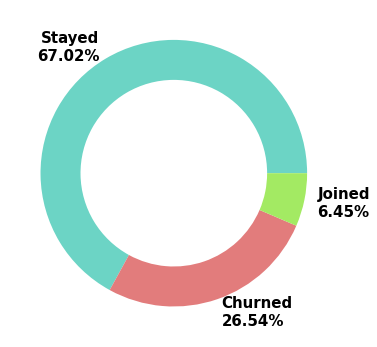

In [16]:
#@title Frecuencia de cada tipo de cliente
fig, ax = plt.subplots(figsize=(6.13,6.13))
wheel_chart(df.customer_status, ax, [cat_palette[0],cat_palette[-1],cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 15 })
fig.show()

(pd.concat([df.customer_status.value_counts().to_frame('Cantidad absoluta'),
        (df.customer_status.value_counts(normalize=True)*100).to_frame('Cantidad porcentual')], axis=1)
        .style.format({'Cantidad porcentual': '{:.2f}%'}))



### Cantidad de usuarios unicos y forma del dataset
* #### Clientes Unicos: 7043
* #### Shape: (7043, 39)


### Cantidad de nulos y tipos de columnas en el dataset

In [17]:
df_info = pd.DataFrame({'column':df.columns,'n_nulls':df.isna().sum().values,'percent_nulls':df.isna().sum().values / len(df) * 100,'dtype':df.dtypes.values})
cm = sns.diverging_palette(220, 10, s=50, as_cmap=True)
df_info.style.background_gradient(cm)

,column,n_nulls,percent_nulls,dtype
0,customer_id,0,0.000000,object
1,gender,0,0.000000,object
2,age,0,0.000000,int64
3,married,0,0.000000,object
4,number_of_dependents,0,0.000000,int64
5,city,0,0.000000,object
6,zip_code,0,0.000000,int64
7,latitude,0,0.000000,float64
8,longitude,0,0.000000,float64
9,number_of_referrals,0,0.000000,int64


### Breve info de que se trata cada columna

* Customer Status:
> Si el cliente sigue en el servicio, se unió o lo dejó (churned)
* Churn Category:
> La categoria del porque lo dejo (por ejemplo: Dissatisfaction, Competitor, etc). Es la mas importante de las 2 columnas.
* Churn Reason:
> La razon especifica del cliente de por que dejo el servicio.
* Gender, Age, Married, Number of Dependents:
> Datos personales de como es la persona , si esta casada o no y con cuanta gente vive.
* City, Zip Code, Latitude, Longitude, County:
> En que parte del estado vive el cliente.
* Number of Referrals, Tenure in Months:
> A cuanta gente le recomendo el servicio y cuantos meses lleva con el servicio (tenure)
* Offer, Phone Service, Multiple Lines, Avg Monthly Long Distance Charges:
> El plan que el cliente esta usando , si opto por usar el servicio telefonico en su casa, si tiene multiples lineas telefónicas y el gasto mensual promedio en llamadas a larga distancia (si el cliente no esta subscripto al servicio telefonico el valor es 0)
* Internet Service, Internet Type, Avg Monthly GB Download:
> Datos relacionados al servicio del internet, si no contrató el servicio de internet el tipo de internet esta como nulo y los GBs promedio tendran un valor igual a 0.
* Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming TV, Streaming Movies, Streaming Music, Unlimited Data:
> Indican si optaron o no por cada uno de esos servicios.
* Contract, Paperless Billing, Payment Method, Monthly Charge:
> La forma y metodo de pago que eligio el cliente y cuanto se le cobra mensualmente.
* Total Charges, Total Refunds, Total Extra Data Charges, Total Long Distance Charges, Total Revenue:
> Gastos y reembolsos totales. Total revenue indica cuanto gano la empresa con este cliente.



# Contexto y Problema Comercial

## Contexto comercial:

En el area de telecomunicaciones, la rotación de los clientes que contratan y dejan los servicios es bastante comun y frecuente.
Las razones de porque dejan los servicios pueden tener diferentes motivos, pero se pueden dividir en 2 grandes grupos: **Evitables** e **Inevitables**.
>
#### Ahora, ¿que tipos de razones son evitables y cuales son inevitables?
Las razones inevitables son aquellas de las cuales la empresa no tiene control y/o culpa como, por ejemplo, cuando un cliente se muda o fallece.
>
Por otro lado las razones evitables son aquellas que tienen que ver con la calidad del servicio, la atencion que recibio el cliente e incluso la poca competitividad de la empresa comparada con otras del area.
>
#### Entonces, ¿que es lo que buscamos como empresa para crecer?
Lo que se busca como empresa es minimizar la cantidad de clientes que dejan aumentando la retención de los clientes, asi como tambien atraer a una mayor cantidad de clientes.
Los valores normales de churned tienen que estar por debajo de los que se unen ya que para que la empresa crezca la cantidad de clientes debe crecer.

## El problema comercial que tiene la empresa.

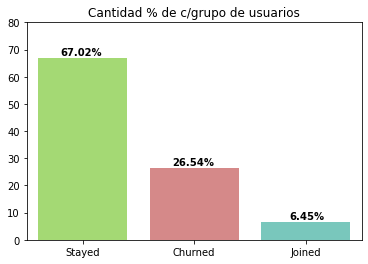

In [18]:
fig,ax=plt.subplots(figsize=(6,4))

porcentajes_clientes = round(df.customer_status.value_counts(normalize=True) *100,2)

g=sns.barplot(y=porcentajes_clientes.values,x=porcentajes_clientes.index,palette=[cat_palette[1],cat_palette[-1],cat_palette[0]])
ax.set_ylim(top=80)
for i, v in enumerate(porcentajes_clientes.values):
  if i < 2:
    ax.text(i-0.2 ,v+1 , str(v)+'%', fontweight='bold')
  else:
    ax.text(i-0.15 ,v+1 , str(v)+'%', fontweight='bold')
g.set_title('Cantidad % de c/grupo de usuarios')
plt.show()

Como se puede ver en el gráfico,en este ultimo cuatrimestre, tenemos muchos mas usuarios que dejaron el servicio que los que se unieron. Lo cual significa que la empresa esta perdiendo clientes y por ende mucho dinero.

El total de ganancias de este cuatrimestre fue de 
<font color='lime'>$\\$$21371131.69</font>
pero las ganancias provenientes de los usuarios que dejaron el servicio fueron de 
<font color='red'>$\\$$3684459.82</font>que representan
<font color='red'>17.24%</font> del total.

## Visto esto podemos hablar del Objetivo de este proyecto

El objetivo sera:
* Hacer un EDA con el fin de ver que causa y donde esta el problema para ver en que acciones tomar de forma inmediata.
* Crear 2 modelos de machine learning:
  * Un modelo de clasificación simple que nos entrega la probabilidad de que un cliente deje el servicio.
  * Y otro de clasificación multivariada que , si el primero predice que deja, prediga la razon mas probable de por la que lo va a dejar.

Con la información que den estos modelos se podra redirigir al departamento correspondiente dentro de la empresa con el fin de evitar que ese cliente deje el servicio.

# Abstract

## Ganancias:
El total de ganancias del Q2 2022 fue de 
<font color='lime'>$\\$$21371131.69</font>
pero las ganancias provenientes de los usuarios que dejaron el servicio fueron de 
<font color='red'>$\\$$3684459.82</font>que representan
<font color='red'>17.24%</font> del total.

## Info de cantidad de usuarios:


,Cantidad absoluta,Cantidad porcentual
Stayed,4720,67.02%
Churned,1869,26.54%
Joined,454,6.45%


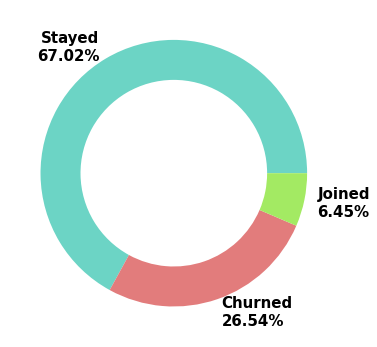

In [19]:
#@markdown Tenemos muchos mas usuarios que dejaron el servicio en comparación los que se unieron, lo cual es un problema.
fig, ax = plt.subplots(figsize=(6.13,6.13))
wheel_chart(df.customer_status, ax, [cat_palette[0],cat_palette[-1],cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 15 })
fig.show()

df_info = (pd.concat([df.customer_status.value_counts().to_frame('Cantidad absoluta'),
        (df.customer_status.value_counts(normalize=True)*100).to_frame('Cantidad porcentual')], axis=1))

df_info['Cantidad porcentual'] = [str(round(v,2)) +'%' for v in df_info['Cantidad porcentual']]
def marcar_churned_joined_stayed(column):
    churned = f'background-color: {cat_palette[-1]}; color: black;'
    stayed = f'background-color: {cat_palette[1]}; color: black;'
    joined = f'background-color: {cat_palette[0]}; color: black;'
    default = ''
    return [ stayed if v == column.max() else joined if v == column.min() else churned for v in column ]

df_info = df_info.style.apply(marcar_churned_joined_stayed,subset=['Cantidad porcentual'],axis=0)
df_info

## Info de los churned:
La ciudad que mas perdida causo fue San Diego con un 10% del total de perdidas por churned, seguido por Los Angeles con 4% del total.
Pero si lo vemos a una escala mas grande a nivel de condados en vez de ciudad podemos ver que los condados mas affectados fueron el de Los Angeles con el 18% y el de Sandiego con 14% representando juntos casi un 32% del total de las perdidas.
Otros condados relevantes fueron Orange, Riverside, Sacramento y Santa Clara que juntos suman alrededor del 15% del total.

In [20]:
# @markdown ### Ubicación de los usuarios por categoría
#redondeo la lat y long de cada grupo para agruparlos un poco
joined_df_lat_long_redond = df[df.customer_status == 'Joined'][['latitude','longitude','customer_status']].groupby(by=['latitude','longitude', 'customer_status']).size()
joined_df_lat_long_redond = joined_df_lat_long_redond.reset_index().rename({0:'densidad'},axis=1)

stayed_df_lat_long_redond = df[df.customer_status == 'Stayed'][['latitude','longitude','customer_status']].groupby(by=['latitude','longitude','customer_status']).size()
stayed_df_lat_long_redond = stayed_df_lat_long_redond.reset_index().rename({0:'densidad'},axis=1)

churned_df_lat_long_redond = df[df.customer_status == 'Churned'][['latitude','longitude','customer_status']].groupby(by=['latitude','longitude','customer_status']).size()
churned_df_lat_long_redond = churned_df_lat_long_redond.reset_index().rename({0:'densidad'},axis=1)

df_plot = pd.concat([stayed_df_lat_long_redond,
                     joined_df_lat_long_redond,
                     churned_df_lat_long_redond], axis=0)

# build figures for each of the required columns
figs = [
    px.density_mapbox(df_plot[df_plot.customer_status==x], lat='latitude', lon='longitude', z='densidad', radius=30,
                        center=dict(lat=37.48, lon=-119.756684), zoom=4.5,
                        mapbox_style="open-street-map")
    for x in ["Churned", "Stayed", "Joined"] 
]
figs.append(px.density_mapbox(df_plot, lat='latitude', lon='longitude', z='densidad', radius=30,
                        center=dict(lat=37.48, lon=-119.756684), zoom=4.5,opacity=0,
                        mapbox_style="open-street-map"))

# Build App
app = JupyterDash(__name__)

app.layout = dash.html.Div(
    [
        dash.dcc.RadioItems(id = 'checklist-customer',
                        options = [
                            {"label": x, "value":i} for i, x in enumerate(["Churned", "Stayed", "Joined", "clean"])
                            ],
                        value = 0,
                        labelStyle={'display':'inline-block','color':'orange'}
                    ),
        dash.dcc.Graph(
            id="map",
        ),
    ]
)

@app.callback(Output("map", "figure"), Input( "checklist-customer", "value"))
def updateGraph(val):
    return figs[val].update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Run app and display result inline in the notebook
app.run_server(mode="inline")

<IPython.core.display.Javascript object>

## Info causas de los churned:
La razon mas predominante de los churned en los 15 condados mas poblados del estado fue la competencia causando <font color='red'>**46%</font> de perdidas monetarias**, entre 30-70% de la cantidad de usuarios perdidos dependiendo del condado **y el <font color='red'>76%</font> de los usuarios en San Diego**.
>
Dentro de esta categoria la mayoria es causada porque **la competencia ofrece mejores dispositivos y ofertas.**
>
Las otras 2 razones mas predominantes fueron las relacionadas con la **dissatisfación de los clientes y la actitud del soporte y proveedores.**
que son el **32% de las perdidas monetarias**
>
La actitud del soporte y proveedores es en general 15-35% de la cantidad de churned por condado.
>
Se puede observar en **Fresno, Orange, Kern, Ventura y San Bernandino** como los principales **con este problema** y San Diego, San Francisco y Sacramento donde este problema es minimo.
>
Por la disatisfacción de los clientes,este problema representa aproximadamente 15-30% de los churned en cada condado. En los unicos en los que no se presenta a gran tamaño es en San Diego y Kern y en los que peor impactan estas razones son Los Angeles, Contra Costa y San Bernandino.
>
Luego estan las otras causas , que son las que estan fuera de nuestro control o alcance como el fallecimiento de un cliente,se mudo o porque no quiso contestar, que son el 10% de las perdidas totales.

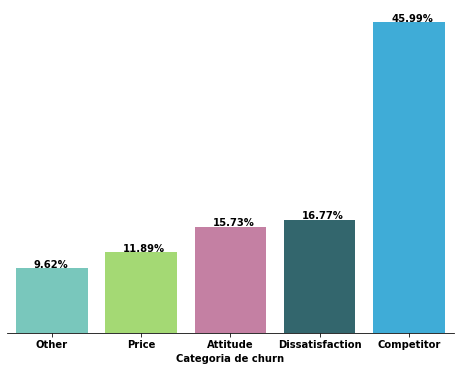

In [21]:
plot_churn_cat_rev_percent(df[df.customer_status=='Churned'],cat_palette)

Si bien, la que domina es la competencia la proporcion va variando por condado como se puede ver en este gráfico.

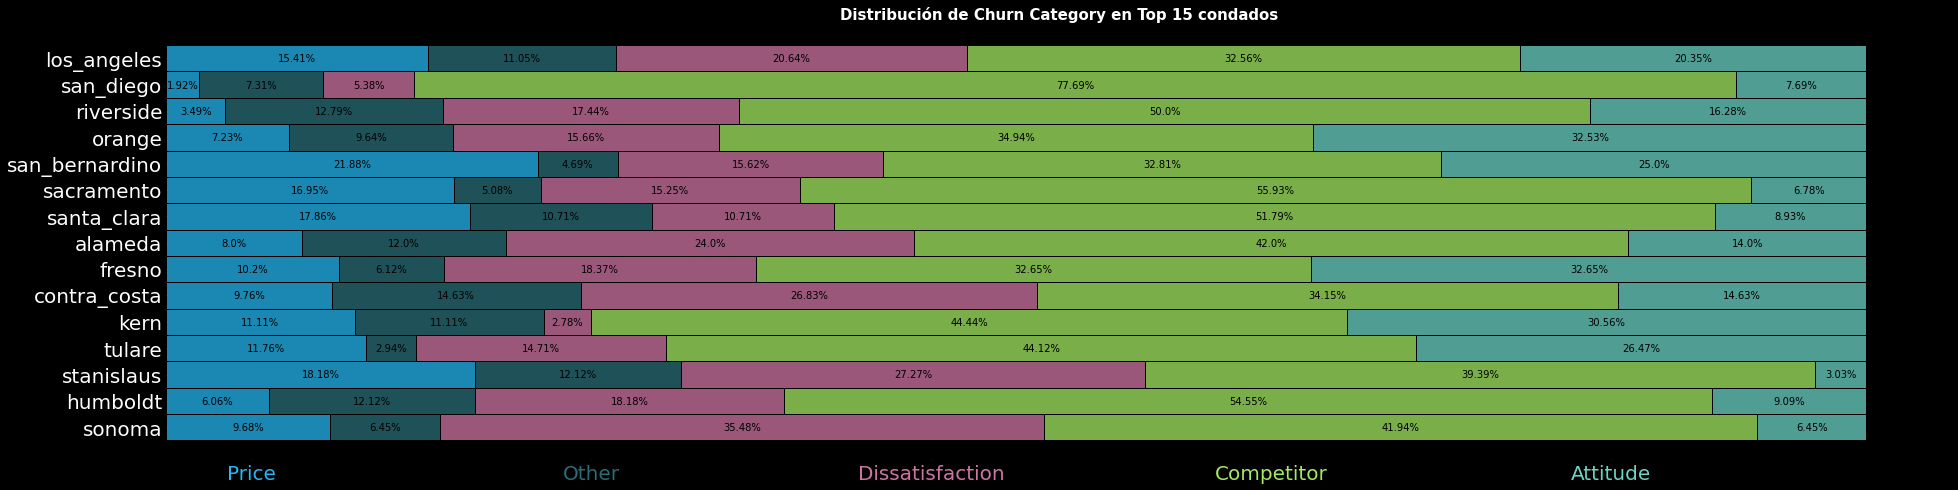

In [22]:
#@markdown Si bien, la que domina es la competencia la proporcion va variando por condado como se puede ver en este gráfico.
#saco los 15 condados con ams churned
top_15_counties = list(df[df.customer_status=='Churned'].county.value_counts()[:15].keys())

cond = ((df.county.isin(top_15_counties)) & (df.customer_status=='Churned'))
distribution = pd.crosstab(df['county'], df[cond]['churn_category'], normalize='index')  #me da un stack en 2d
distribution = distribution.stack().reset_index(name='%')
plot_stacked_bar_distribution(distribution,colors=cat_palette[:5])

**Cantidad porcentual de cada razon de churn por condado**

|Churn Reason|Los Angeles|San Diego|Orange|Riverside|San Bernandino|Sacramento|Santa Clara|Alameda|Fresno|Contra Costa|Kern|San Francisco|San Joaquin|San Mateo|Ventura
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---
|Attitude of support person|1.9608|2.4896|13.3333|5.6338|9.8361|3.5714|2.0|0.0|17.3913|5.7143|15.625|0.0|7.6923|7.4074|12.5
|Competitor had better devices|20.915|5.8091|22.6667|14.0845|16.3934|3.5714|8.0|15.9091|17.3913|11.4286|18.75|7.6923|7.6923|14.8148|29.1667
|Competitor made better offer|18.9542|4.5643|20.0|15.493|29.5082|21.4286|24.0|27.2727|15.2174|14.2857|31.25|23.0769|26.9231|22.2222|8.3333
|Competitor offered higher download speeds|5.2288|76.7635|6.6667|30.9859|1.6393|10.7143|10.0|6.8182|10.8696|11.4286|3.125|11.5385|7.6923|11.1111|4.1667
|Competitor offered more data|6.2092|1.2448|6.6667|4.2254|1.6393|16.0714|10.0|4.5455|4.3478|8.5714|12.5|15.3846|7.6923|0.0|4.1667
|Extra data charges|6.2092|1.2448|5.3333|7.0423|1.6393|10.7143|14.0|9.0909|4.3478|5.7143|3.125|15.3846|11.5385|11.1111|8.3333
|Lack of affordable download/upload speed|4.5752|0.4149|1.3333|0.0|3.2787|7.1429|2.0|4.5455|4.3478|2.8571|3.125|3.8462|0.0|0.0|4.1667
|Lack of self-service on Website|2.6144|0.0|1.3333|0.0|3.2787|3.5714|2.0|0.0|2.1739|0.0|0.0|0.0|0.0|0.0|4.1667
|Limited range of services|1.634|1.2448|2.6667|1.4085|1.6393|0.0|2.0|2.2727|2.1739|2.8571|0.0|0.0|3.8462|0.0|0.0
|Long distance charges|3.5948|0.4149|1.3333|2.8169|1.6393|3.5714|2.0|2.2727|0.0|8.5714|0.0|0.0|0.0|3.7037|4.1667
|Network reliability|4.2484|0.8299|2.6667|0.0|8.1967|1.7857|2.0|2.2727|2.1739|2.8571|3.125|0.0|7.6923|3.7037|4.1667
|Poor expertise of online support|5.5556|0.4149|4.0|5.6338|3.2787|1.7857|2.0|2.2727|4.3478|11.4286|0.0|3.8462|0.0|3.7037|4.1667
|Poor expertise of phone support|1.3072|1.6598|1.3333|1.4085|0.0|1.7857|0.0|4.5455|0.0|0.0|3.125|0.0|0.0|0.0|0.0
|Price too high|0.6536|0.0|0.0|0.0|0.0|0.0|0.0|4.5455|0.0|0.0|0.0|0.0|0.0|0.0|0.0
|Product dissatisfaction|5.8824|0.8299|2.6667|2.8169|8.1967|5.3571|14.0|2.2727|2.1739|5.7143|6.25|7.6923|3.8462|11.1111|4.1667
|Service dissatisfaction|5.5556|1.6598|4.0|7.0423|6.5574|1.7857|2.0|6.8182|8.6957|2.8571|0.0|7.6923|7.6923|3.7037|4.1667

# EDA

## Resumen del EDA

* La competencia es la razon principal de porque tenemos tantos churned, habria que aumentar nuestra competividad ofreciendo mejores ofertas, dispositivos
* Hay una cantidad importante de disatisfaccion con el servicio (entre 15-30% de las razones) en la mayoria de los condados principales exceptuando San Diego y Kern.
* La mala atencion del servicio y del proveedor es motivo del 15 al 37% en la mayoria de los condados, siendo los mas problematicos Ventura, Kern, Fresno y Orange. Los condados que menos tienen de este problema son San Francisco, San Diego, Santa Clara y Sacramento donde poseen entre 6-9%, habria que ver que esta pasando con la actitud de los empleados de soporte y proveedores para corregirla.
* Los precios del servicio fueron relevantes en los condados de Los Angeles, San Bernandino, Sacramento ,San Mateo Ventura y Santa Clara con 14-22% de los churned.

* Los condados con mas perdidas fueron Los Angeles y San Diego que juntos representan 30% de los churned.

* Los usuarios que pagan la oferta E y los que no tienen oferta tienen una gran chance de dejar el servicio.

Sobre el servicio:
* Parece que hay problemas con la fibra optica, pueden provenir por ser uno de los servicios de internet mas comunes ofrecidos causando que haya mas volumen, asi como tambien puede proveenir de las fallas e inestabilidad en la red.

* Se ve que hay mas churned que contrataron servicios de streaming de peliculas y tv, se puede deber al catálogo de las mismas y/o a inestabilidades en el servicio. Habria que conseguir datos de los mismos para entrar en detalle al por qué.

* Por otro lado los usuarios que contratan DSL, Servicio premium de soporte y el servicio de seguridad online tienden a quedarse asi que esos deben funcionar como deben.


In [24]:
# ProfileReport(df)

In [25]:
#separo en categoricas y numericas
numericas = pd.DataFrame({c: df.select_dtypes(exclude='object')[c] for c in df.select_dtypes(exclude='object')})
categoricas = pd.DataFrame({c: df.select_dtypes('object')[c] for c in df.select_dtypes('object')})

## Matriz de correlaciones

In [26]:
fig = px.imshow(numericas.corr().round(2), text_auto=True, aspect="auto",color_continuous_scale="icefire")
fig.show()

* total_revenue tiene una tendencia altamente positiva con tenure_in_months, total_charges, total_long_distance_charges
y levemente positiva con monthly_charge. 
>
Lo cual nos dice que recaudamos mas a mas tiempo se queden los usuarios en el servicio y a mas que le cobramos(hasta cierto punto).
* la cantidad de gb gastados mensualmente tiene una tendencia levemente negativa a medida que aumenta la edad, tiene sentido ya que las personas mas viejas tienden a usar menos los servicios de internet.

* hay una muy leve tendencia positiva entre la tenure y la cantidad de referals y tambien entre los cargos mensuales y la  tenure.

## Outliers y distribucion

### avg_monthly_long_distance_charges y avg_monthly_gb_download

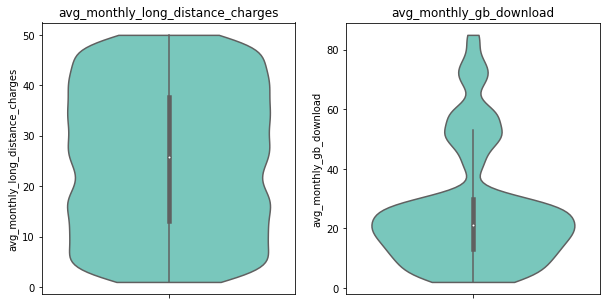

In [27]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.violinplot(y = df.avg_monthly_long_distance_charges , ax=ax[0],title='avg_monthly_long_distance_charges',color=cat_palette[0] ,cut=0)
ax[0].set_title('avg_monthly_long_distance_charges')
sns.violinplot(y = df.avg_monthly_gb_download , ax=ax[1],title='avg_monthly_gb_download',color=cat_palette[0] ,cut=0)
ax[1].set_title('avg_monthly_gb_download')
plt.show()

In [28]:
df[['avg_monthly_long_distance_charges','avg_monthly_gb_download']].describe()

,avg_monthly_long_distance_charges,avg_monthly_gb_download
count,6361.000000,5517.000000
mean,25.420517,26.189958
std,14.200374,19.586585
min,1.010000,2.000000
25%,13.050000,13.000000
50%,25.690000,21.000000
75%,37.680000,30.000000
max,49.990000,85.000000


In [29]:
#veo cuanto % estan por arriba del 3er cuartil en avg_monthly_gb_download
len(df[df.avg_monthly_gb_download > 30]) / len(df) * 100 , len(df[df.avg_monthly_gb_download > 30])

(17.066590941360214, 1202)

Deacuerdo al diagrama de violin avg_monthly_long_distance_charges no tiene outliers y tiene una distribución bastante pareja.

>

avg_monthly_gb_download por el otro lado tiene un 17% de los registros por arriba del 75% y parece que tiene una principal mayoria cerca de la mediana y otras 2 mas pequeñas cerca de 50 y 80gb

### monthly_charge,	total_charges y total_revenue

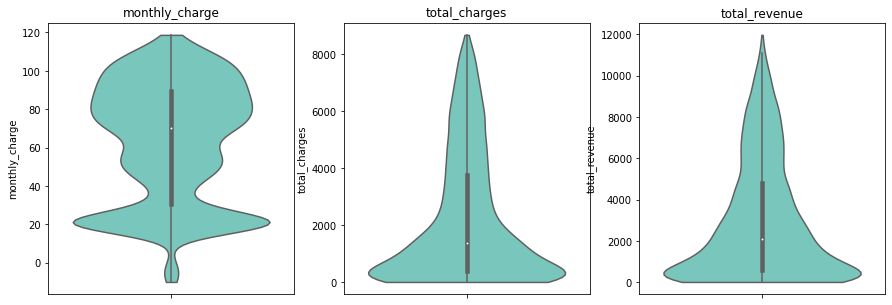

In [30]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

sns.violinplot(y = df.monthly_charge, ax=ax[0], color=cat_palette[0], cut=0)
ax[0].set_title('monthly_charge')
sns.violinplot(y = df.total_charges, ax=ax[1], color=cat_palette[0], cut=0)
ax[1].set_title('total_charges')
sns.violinplot(y = df.total_revenue, ax=ax[2], color=cat_palette[0], cut=0)
ax[2].set_title('total_revenue')
plt.show()

In [31]:
df[['monthly_charge','total_charges','total_revenue']].describe()

,monthly_charge,total_charges,total_revenue
count,7043.000000,7043.000000,7043.000000
mean,63.596131,2280.381264,3034.379056
std,31.204743,2266.220462,2865.204542
min,-10.000000,18.800000,21.360000
25%,30.400000,400.150000,605.610000
50%,70.050000,1394.550000,2108.640000
75%,89.750000,3786.600000,4801.145000
max,118.750000,8684.800000,11979.340000


* total revenue tiene muy pocos outliers que estan por encima del 75%
* monthly charge tiene 2 modas, la principal por $20 y la otra entre 80 y 100. Tambien tiene valores por debajo de 0, lo cual no tiene mucho sentido

Veamos Total Revenue en mas detalle

#### Total revenue por categoría de usuario

In [32]:
fig = px.box(df,y='total_revenue', x='customer_status',color="customer_status",color_discrete_sequence=[cat_palette[0],cat_palette[-1],cat_palette[1]])
fig.update_traces(quartilemethod="exclusive")
fig.show()

In [33]:
#@markdown Parece que hay muchos outliers en la categoria churned pero en realidad no lo son ya que este porcentaje alto de atipicos ,por criterio intercuartil, seria marcado como normal en el grupo de stayed por ende podrian ser clientes que eran parte de los stayed en un pasado y que dejaron el servicio los cuales serian datos importantes para predecir si un cliente va a dejar o no. Por si las dudas hago un boxplot con todas las clases juntas.
df.groupby("customer_status").total_revenue.describe()

,count,mean,std,min,25%,50%,75%,max
customer_status,,,,,,,,
Churned,1869.0,1971.353569,2438.441813,21.61,175.8500,893.550,2888.76,11195.44
Joined,454.0,119.558921,89.466565,21.36,56.9700,91.095,166.24,456.10
Stayed,4720.0,3735.676297,2852.938745,73.65,1307.5375,2960.110,5857.33,11979.34


### total_extra_data_charges, total_long_distance_charges

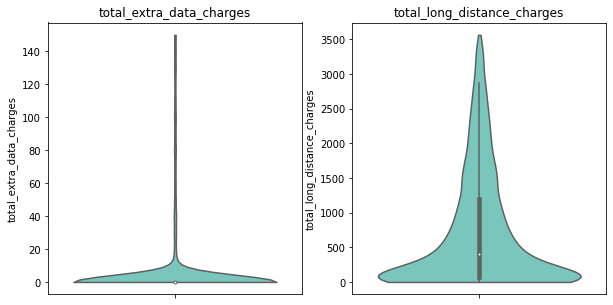

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.violinplot(y = df.total_extra_data_charges , ax=ax[0], color=cat_palette[0] ,cut=0)
ax[0].set_title('total_extra_data_charges')
sns.violinplot(y = df.total_long_distance_charges , ax=ax[1], color=cat_palette[0], cut=0)
ax[1].set_title('total_long_distance_charges')
plt.show()

In [35]:
df[['total_extra_data_charges','total_long_distance_charges']].describe()

,total_extra_data_charges,total_long_distance_charges
count,7043.000000,7043.000000
mean,6.860713,749.099262
std,25.104978,846.660055
min,0.000000,0.000000
25%,0.000000,70.545000
50%,0.000000,401.440000
75%,0.000000,1191.100000
max,150.000000,3564.720000


In [36]:
# total_long_distance_charges
len(df[df.total_long_distance_charges > 1191.10]) / len(df) * 100 , len(df[df.total_long_distance_charges > 1191.10])

(25.003549623739886, 1761)

In [37]:
#total_extra_data_charges
len(df[df.total_extra_data_charges > 0]) / len(df) * 100 , len(df[df.total_extra_data_charges > 0])

(10.336504330540963, 728)

* por total_extra_data_charges: No creo que sean outliers ya que no todos los usuarios consumen datos demas y la mayoria esta en 0
* por los cargos a larga distancia: parece que la mayoria de los usuarios no hace llamadas a larga distancia haciendo que ese 25% ,que si hace llamadas a larga distancia, parezcan  outliers.

## ¿Hay alguna ciudad o area donde haya mas churned que el resto, o algún patron en la ubicación de los churned?

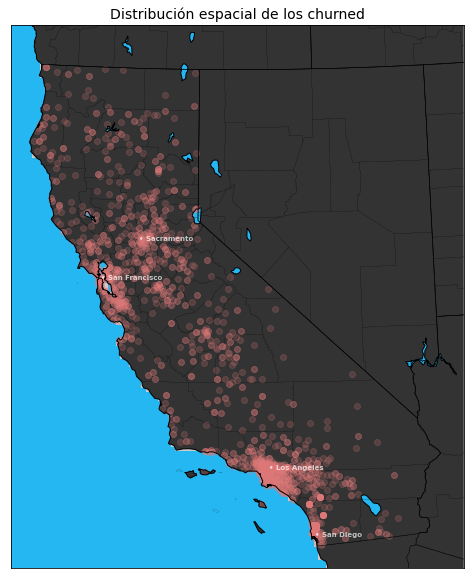

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
plot_scatter_map(df[(df.customer_status=='Churned')],title="Distribución espacial de los churned",alpha=0.2,
        ax = ax,dot_color=cat_palette[-1],land_color=div_palette[4],water_col=cat_palette[4],fontdict ={'color': 'black', 'weight': 'bold', 'size': 7})

Parece que los focos con mas churned son cerca las ciudades mas importantes del estado, como era de esperarse ya que son las zonas mas pobladas. Veamos si hay tendencias entre ciertos motivos de churn en alguna ciudad o condado en especifico.

## ¿Que condados tienen mas churned y cuanto % del total tienen?

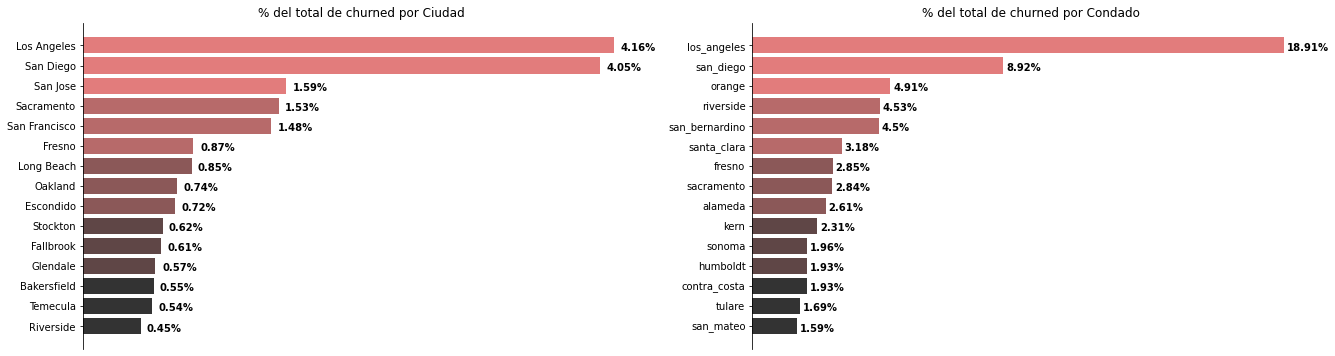

In [56]:
#@markdown 
fig, ax = plt.subplots(1,2,figsize=(22,6))
ax=ax.flatten()

colors = [div_palette[0], div_palette[0], div_palette[0], div_palette[1], div_palette[1], 
            div_palette[1], div_palette[2], div_palette[2], div_palette[2], div_palette[3],
            div_palette[3], div_palette[3], div_palette[4], div_palette[4], div_palette[4],]

ax[0].barh(df.city.value_counts(normalize=True).index[:15],df.city.value_counts(normalize=True)[:15] * 100,color=colors)
ax[0].set_title('% del total de churned por Ciudad')
ax[0].invert_yaxis()
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xticks([])

for i, v in enumerate(round(df.city.value_counts(normalize=True)[:15] * 100,2).values):
    ax[0].text(v + 0.05, i + .25, str(v)+'%', fontweight='bold')

ax[1].set_title('% del total de churned por Condado')
ax[1].barh(df.county.value_counts(normalize=True).index[:15],df.county.value_counts(normalize=True)[:15] * 100,color=colors)
ax[1].invert_yaxis()
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticks([])

for i, v in enumerate(round(df.county.value_counts(normalize=True)[:15] * 100,2).values):
    ax[1].text(v + 0.1, i + .25, str(v)+'%', fontweight='bold')
fig.show()

Los condados con mas churned son San Diego y Los Angeles, representando 30% aprox del total de churned.

Los top 15 condados en churned representan 66.29% del total, decidí no seguir agregando ya que cada condado que agregaba me estaba dando cada vez menos % del total

##  ¿Que categorias de churn predominan en los 15 condados mas poblados del estado?

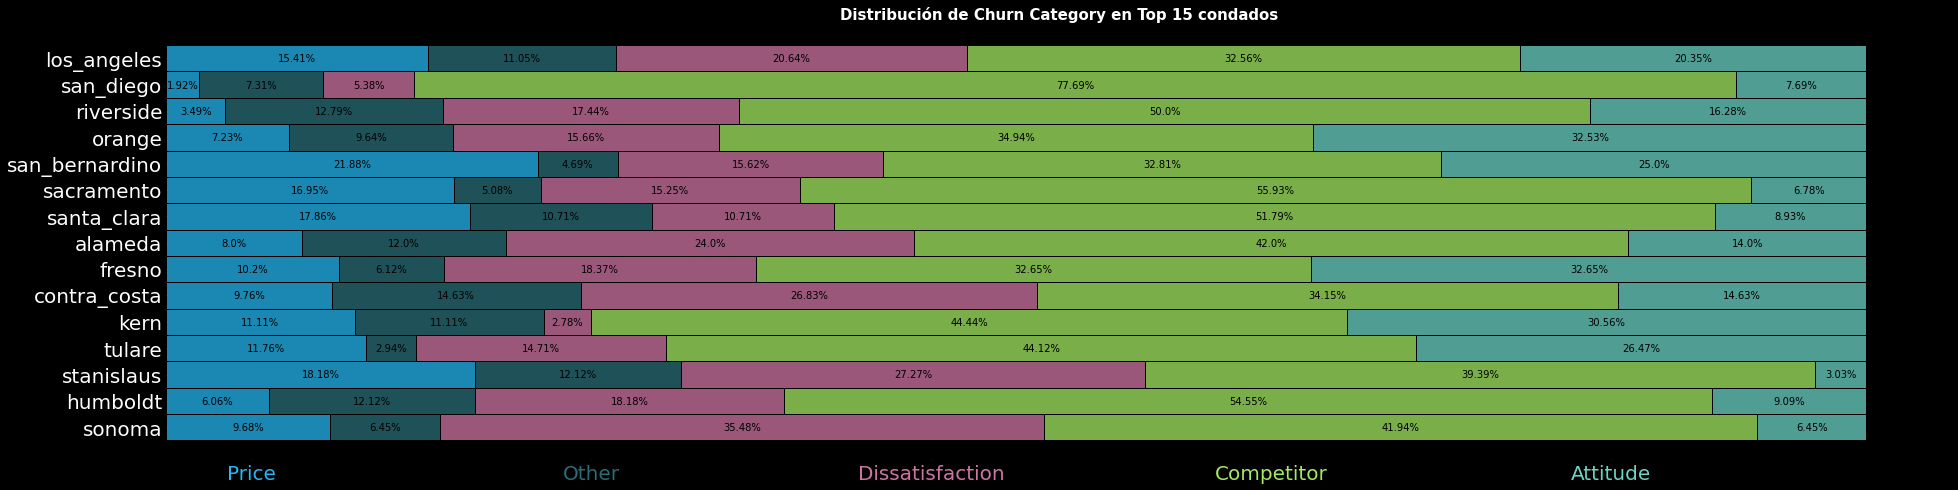

In [57]:
top_15_counties = list(df[df.customer_status=='Churned'].county.value_counts()[:15].keys())

cond = ((df.county.isin(top_15_counties)) & (df.customer_status=='Churned'))
distribution = pd.crosstab(df['county'], df[cond]['churn_category'], normalize='index')  #me da un stack en 2d
distribution = distribution.stack().reset_index(name='%')
plot_stacked_bar_distribution(distribution,colors=cat_palette[:5])

## ¿Que razones especificas predominan en los 15 condados mas poblados del estado?

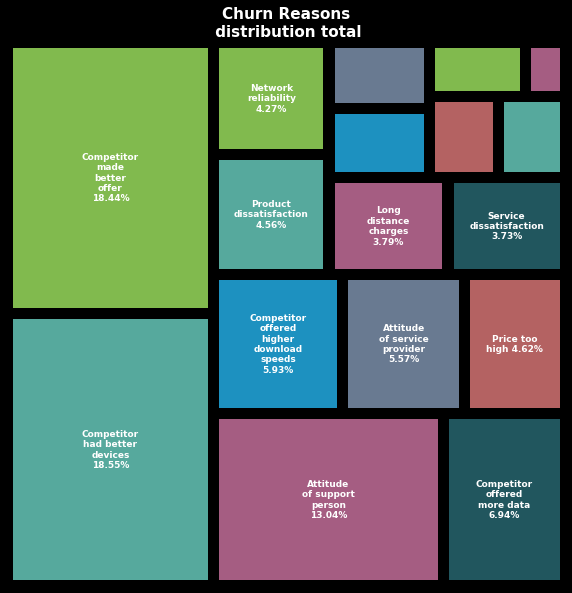

In [71]:
plot_box_map(df[df.customer_status=='Churned'],
             cat_palette,
             figsize=(10,10),
             fontdict={'color': 'white',
                                'fontsize': 9, 
                                'fontweight': 'bold', 
                                'horizontalalignment': 'center'})

**Cantidad porcentual de cada razon de churn por condado**

|Churn Reason|Los Angeles|San Diego|Orange|Riverside|San Bernandino|Sacramento|Santa Clara|Alameda|Fresno|Contra Costa|Kern|San Francisco|San Joaquin|San Mateo|Ventura
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---
|Attitude of support person|1.9608|2.4896|13.3333|5.6338|9.8361|3.5714|2.0|0.0|17.3913|5.7143|15.625|0.0|7.6923|7.4074|12.5
|Competitor had better devices|20.915|5.8091|22.6667|14.0845|16.3934|3.5714|8.0|15.9091|17.3913|11.4286|18.75|7.6923|7.6923|14.8148|29.1667
|Competitor made better offer|18.9542|4.5643|20.0|15.493|29.5082|21.4286|24.0|27.2727|15.2174|14.2857|31.25|23.0769|26.9231|22.2222|8.3333
|Competitor offered higher download speeds|5.2288|76.7635|6.6667|30.9859|1.6393|10.7143|10.0|6.8182|10.8696|11.4286|3.125|11.5385|7.6923|11.1111|4.1667
|Competitor offered more data|6.2092|1.2448|6.6667|4.2254|1.6393|16.0714|10.0|4.5455|4.3478|8.5714|12.5|15.3846|7.6923|0.0|4.1667
|Extra data charges|6.2092|1.2448|5.3333|7.0423|1.6393|10.7143|14.0|9.0909|4.3478|5.7143|3.125|15.3846|11.5385|11.1111|8.3333
|Lack of affordable download/upload speed|4.5752|0.4149|1.3333|0.0|3.2787|7.1429|2.0|4.5455|4.3478|2.8571|3.125|3.8462|0.0|0.0|4.1667
|Lack of self-service on Website|2.6144|0.0|1.3333|0.0|3.2787|3.5714|2.0|0.0|2.1739|0.0|0.0|0.0|0.0|0.0|4.1667
|Limited range of services|1.634|1.2448|2.6667|1.4085|1.6393|0.0|2.0|2.2727|2.1739|2.8571|0.0|0.0|3.8462|0.0|0.0
|Long distance charges|3.5948|0.4149|1.3333|2.8169|1.6393|3.5714|2.0|2.2727|0.0|8.5714|0.0|0.0|0.0|3.7037|4.1667
|Network reliability|4.2484|0.8299|2.6667|0.0|8.1967|1.7857|2.0|2.2727|2.1739|2.8571|3.125|0.0|7.6923|3.7037|4.1667
|Poor expertise of online support|5.5556|0.4149|4.0|5.6338|3.2787|1.7857|2.0|2.2727|4.3478|11.4286|0.0|3.8462|0.0|3.7037|4.1667
|Poor expertise of phone support|1.3072|1.6598|1.3333|1.4085|0.0|1.7857|0.0|4.5455|0.0|0.0|3.125|0.0|0.0|0.0|0.0
|Price too high|0.6536|0.0|0.0|0.0|0.0|0.0|0.0|4.5455|0.0|0.0|0.0|0.0|0.0|0.0|0.0
|Product dissatisfaction|5.8824|0.8299|2.6667|2.8169|8.1967|5.3571|14.0|2.2727|2.1739|5.7143|6.25|7.6923|3.8462|11.1111|4.1667
|Service dissatisfaction|5.5556|1.6598|4.0|7.0423|6.5574|1.7857|2.0|6.8182|8.6957|2.8571|0.0|7.6923|7.6923|3.7037|4.1667

 * **La competencia es la razon principal** de los churned en los condados representando en general 30-70% de los churned.Los unicos condados donde no es la principal son Fresno, Orange y Ventura donde estan empatados o superados por probelmas en la actitud del soporte.
>
En la mayoria de los condados ,entre las razones de la competencia, predomina que ofrece mejores dispositivos. La excepcion a esto es San Diego donde domina la mejor oferta por parte de los competidores.
>
 * **La razon secundaria es la actitud del soporte y del proveedor** de cada condado representando en general 15-35% de los churned.Se puede observar en Fresno, Orange, Kern, Ventura y San Bernandino como los principales con este problema y San Diego, San Francisco y Sacramento donde este problema es minimo
>
 * **Y las razones terciarias** son disatisfaccion con los productos,servicios y los precios tanto del servicio como de los cargos a larga distancia.
>
Este problema representa aproximadamente 15-30% de los churned en cada condado. En los unicos en los que no se presenta a gran tamaño es en San Diego y Kern y
en los que peor impactan estas razones son Los Angeles, Contra Costa y San Bernandino.

## ¿Cómo le fue a la empresa en el Q2 2022?¿Cuánto de lo recaudado provenia de los churned?

El total de ganancias del Q2 2022 fue de:  $21371131.69
Las ganancias provenientes de los churned fue de:  $3684459.82
que equivale a 17.24% de las ganancias totales


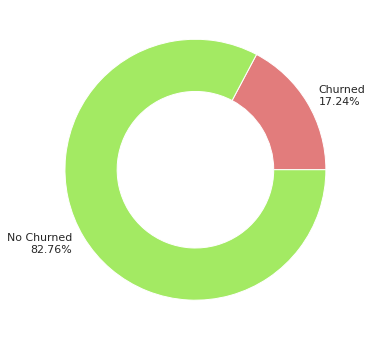

In [91]:
#@markdown
total_revenue = df.total_revenue.sum()
total_churned_revenue =df[df.customer_status == 'Churned'].total_revenue.sum()
total_not_churned_revenue =df[df.customer_status != 'Churned'].total_revenue.sum() 

revenue_lost = round(total_churned_revenue,2)
percent_lost = round(revenue_lost/total_revenue * 100,2)

temp_dict={'Total':[total_revenue],'Churned':[total_churned_revenue],'Not Churned':[total_not_churned_revenue]}
report_df = pd.DataFrame(temp_dict)
report_df = report_df.stack(0).reset_index()

print(f'El total de ganancias del Q2 2022 fue de:  {bcolors.OKGREEN}${total_revenue}{bcolors.ENDC}\nLas ganancias provenientes de los churned fue de:  {bcolors.FAIL}${revenue_lost}{bcolors.ENDC}\nque equivale a {bcolors.FAIL}{percent_lost}%{bcolors.ENDC} de las ganancias totales')

fig, ax = plt.subplots(figsize=(6,6))
report_df = report_df.rename(columns = {0:'revenue'})

cmap = sns.color_palette([cat_palette[-1],cat_palette[1]])
size_of_groups = round(report_df.revenue.iloc[1:3] / report_df.revenue.iloc[0] * 100,2)
labels = [i + f'\n{g}%'for i,g in zip(['Churned', 'No Churned'],size_of_groups)]
ax.pie(size_of_groups,labels=labels, radius=1,colors = cmap,
        wedgeprops=dict(width=0.4))
fig.show()

## ¿En qué ciudades se perdio mas dinero?¿Sigue el mismo patrón de ciudades que en el analisis espacial por cantidad?

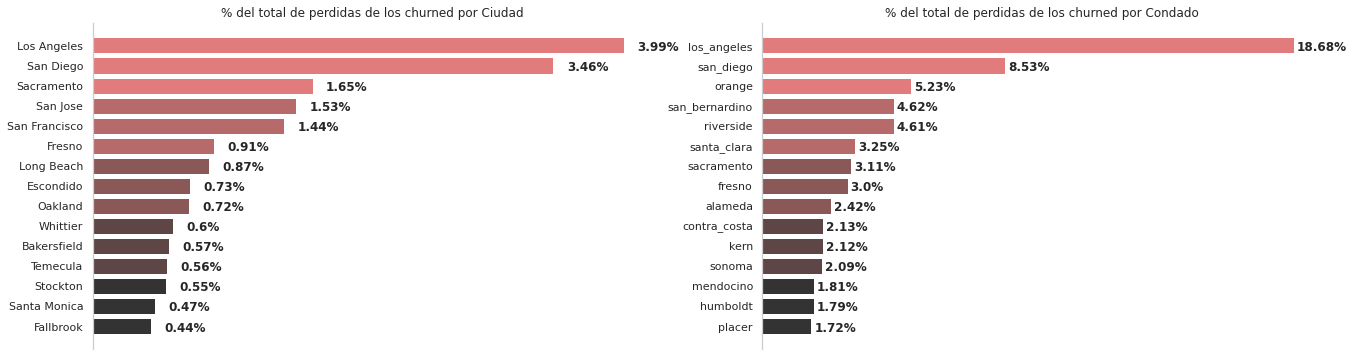

In [118]:
# @markdown 
fig, ax = plt.subplots(1,2,figsize=(22,6))
ax=ax.flatten()

colors = [div_palette[0], div_palette[0], div_palette[0], div_palette[1], div_palette[1], 
            div_palette[1], div_palette[2], div_palette[2], div_palette[2], div_palette[3],
            div_palette[3], div_palette[3], div_palette[4], div_palette[4], div_palette[4],]

top_15_cities = df.groupby('city').total_revenue.sum().sort_values(ascending=False)[:15] / df.total_revenue.sum() * 100
top_15_counties = df.groupby('county').total_revenue.sum().sort_values(ascending=False)[:15] / df.total_revenue.sum() * 100

ax[0].barh(top_15_cities.index[:15],top_15_cities[:15].values,color=colors)
ax[0].set_title('% del total de perdidas de los churned por Ciudad')
ax[0].invert_yaxis()
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xticks([])
ax[0].grid(False)

for i, v in enumerate(round(top_15_cities[:15],2).values):
    ax[0].text(v + 0.1, i + .25, str(v)+'%', fontweight='bold')

ax[1].set_title('% del total de perdidas de los churned por Condado')
ax[1].barh(top_15_counties.index[:15],top_15_counties[:15].values,color=colors)
ax[1].invert_yaxis()
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticks([])
ax[1].grid(False)

for i, v in enumerate(round(top_15_counties[:15],2).values):
    ax[1].text(v + 0.1, i + .25, str(v)+'%', fontweight='bold')
fig.show()

In [119]:
pd.DataFrame({'city':top_15_cities.keys(),
              'city_revenue':top_15_cities.values,
              'county':top_15_counties.keys(),
              'county_revenue':top_15_counties.values}).style.background_gradient(cmap="Reds")

,city,city_revenue,county,county_revenue
0,Los Angeles,3.990080,los_angeles,18.675509
1,San Diego,3.455203,san_diego,8.531023
2,Sacramento,1.653501,orange,5.232688
3,San Jose,1.527661,san_bernardino,4.617156
4,San Francisco,1.436499,riverside,4.607611
5,Fresno,0.909780,santa_clara,3.253968
6,Long Beach,0.870039,sacramento,3.113428
7,Escondido,0.729488,fresno,3.000630
8,Oakland,0.723239,alameda,2.423282
9,Whittier,0.602957,contra_costa,2.131168


El patron de las ciudades y condados mas problematicos se repite al del analisis por cantidad.
>
El top 15 de ciudades solamente representa el **27,74%** del total perdido ($\\$$ 1022120.55)
>
Las Ciudades que mas dinero perdieron fueron:
* San Diego con **10,46%** del total perdido ($\\$$ 385446.39)
*  Los Angeles con **3,99%** del total perdido ($\\$$ 147090.46)
* El resto del top 15 representan entre **0.6% y 1.6%** del total perdido)
>

El top 15 de los condados representa el **65,36%** del total perdido
>
Los Condados que mas dinero perdieron fueron:
* Los Angeles con **17.95%** del total perdido ($\\$$ 661439.28)
* San Diego con **14.29%** del total perdido ($\\$$ 526844.61)
* El resto del top 15 representa entre **1,16% y 4,50%**.
Los condados mas relevantes de este resto son : Orange, Riverside,   Sacramento y Santa Clara que juntos suman alrededor del **15%** del total.

## ¿Hay alguna razon de churn que tenga mayor impacto en total revenue que las otras?

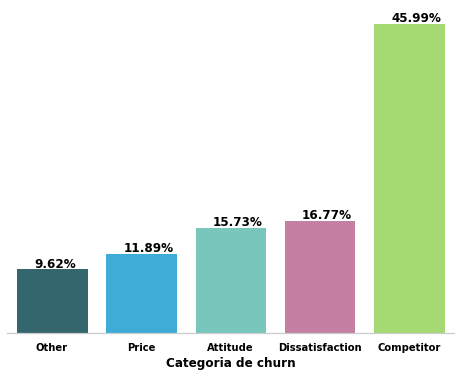

In [121]:
plot_churn_cat_rev_percent(df[df.customer_status=='Churned'],[cat_palette[3],cat_palette[4],cat_palette[0],cat_palette[2],cat_palette[1]])

In [127]:
#@markdown Se puede ver que la competencia es la razon principal cuasando 46% de las perdidas monetarias, seguida por la actitud del soporte y dissatisfaccion del servicio sumando alrededor de 32% entre ellas. Veamos cuales son las razones dentro de estos 3 grupos que mas impacto tienen.
pd.DataFrame(df[df.customer_status=='Churned'].groupby('churn_category').total_revenue.sum()).reset_index().style.background_gradient(cmap="Reds")

,churn_category,total_revenue
0,Attitude,579554.130000
1,Competitor,1694413.150000
2,Dissatisfaction,617979.260000
3,Other,354389.140000
4,Price,438124.140000


## ¿Cuales son las razones de cada categoria de churn que nos hacen perder mas dinero?

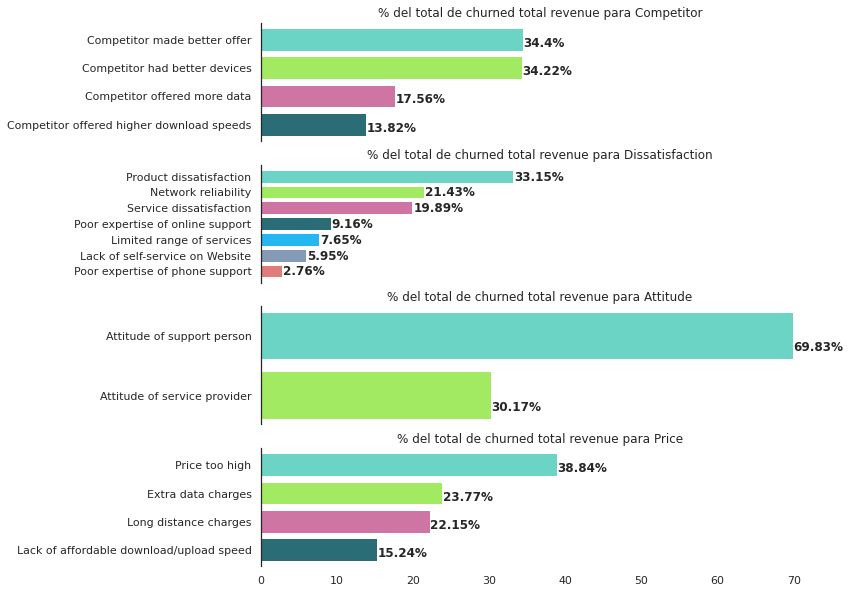

In [135]:
#@markdown
categorias=['Competitor','Dissatisfaction','Attitude','Price']

fig, ax = plt.subplots(len(categorias),1,figsize=(10,10),sharex=True)
ax=ax.flatten()

for j,razon in enumerate(categorias):
    cond = df.churn_category==razon
    #valor $
    valor_dolar_por_razon = df[cond].groupby('churn_reason')['total_revenue'].sum()
    # % 
    valor_porcentaje_por_razon= df[cond].groupby('churn_reason')['total_revenue'].sum() / df[cond]['total_revenue'].sum() * 100

    ax[j].barh(valor_porcentaje_por_razon.sort_values(ascending=False).index,
            valor_porcentaje_por_razon.sort_values(ascending=False),
            color=cat_palette,
            )
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)

    ax[j].set_title(f'% del total de churned total revenue para {razon}')
    ax[j].invert_yaxis()

  #labels de los % en las barras
    for i, v in enumerate(round(valor_porcentaje_por_razon.sort_values(ascending=False),2).values):
        ax[j].text(v+.1, i + .25, str(v)+'%', fontweight='bold')

In [154]:
#@markdown 
categorias=['Competitor','Dissatisfaction','Attitude','Price']
temp_dict={'churn_reason':[],'total_revenue':[]}

for cat in categorias:
    cond = df.churn_category==cat
    valor_dolar_por_razon = df[cond].groupby('churn_reason')['total_revenue'].sum()
    temp_dict['churn_reason'] += list(valor_dolar_por_razon.keys())
    temp_dict['total_revenue'] += list(valor_dolar_por_razon.values)
pd.DataFrame(temp_dict).round(2).style.background_gradient(cmap="Reds").format('{}')

,churn_reason,total_revenue
0,Competitor had better devices,579877.05
1,Competitor made better offer,582822.2
2,Competitor offered higher download speeds,234145.69
3,Competitor offered more data,297568.21
4,Lack of self-service on Website,36788.15
5,Limited range of services,47254.43
6,Network reliability,132443.67
7,Poor expertise of online support,56617.14
8,Poor expertise of phone support,17085.99
9,Product dissatisfaction,204875.74


Veamos categoria por categora:
* Competencia:
  Las 2 razones que predominan, practicamente empatadas son:
  - Ofrecen mejores dispositivos.
  - Tienen mejores ofertas.
* Dissatisfacción:
  Las 3 razones que predominan que equivalen al ~63% de las perdidas de esta categoria son:
  - Dissatisfaccion con el producto
  - Estabilidad de la red
  - Dissatisfaccion con el servicio
* Actitud:
  - El 70% de las perdidas de esta categoria provienen de la actitud de personas de soporte.
  - El 30% proviene de la actitud del proovedor del servicio
* Precio:
  - Predomina con 39% que el precio de las ofertas es muy alto.
  - Los cargos por larga distancia y por datos extras son las segundas razones con 24% y 22% respectivamente.

## Comparacion churned vs stayed

In [184]:
#saco las columnas que no quiero analizar en esta parte de las numericas y categoricas
num_cols = numericas.loc[:, numericas.columns.isin(['zip_code','latitude','longitude']) != True].columns

cat_cols = categoricas.loc[:, categoricas.columns.isin(['customer_id','county','city','churn_category','churn_reason']) != True].columns

### Numericas

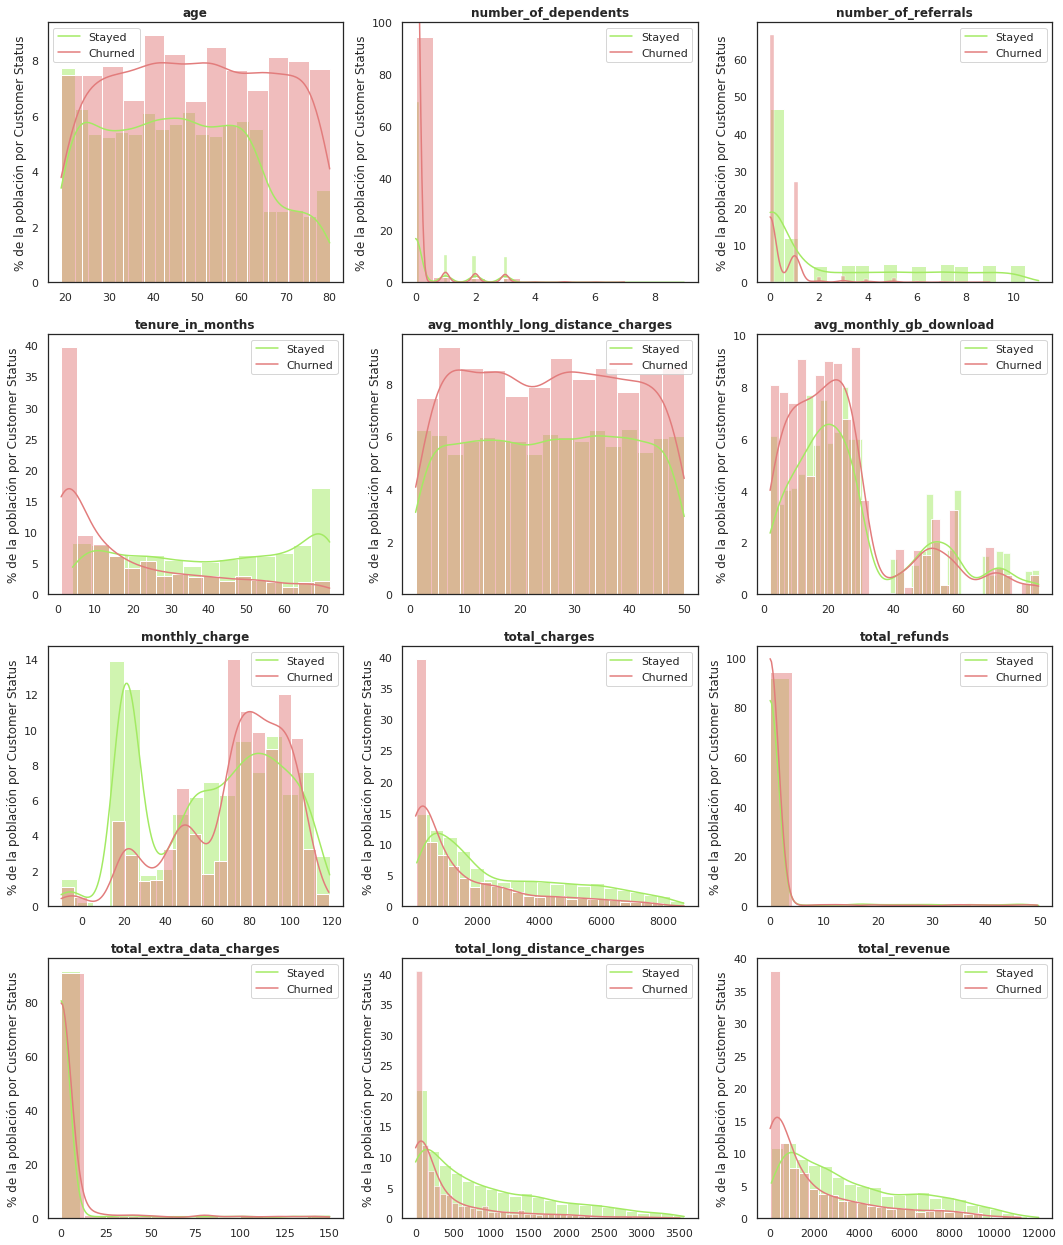

In [190]:
#@title ¿Hay alguna tendencia en las columnas numericas?¿Diferencias entre los churned y stayed?
ROWS, COLS = 4, 3
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 22))
row, col = 0, 0


for i, num_col in enumerate(num_cols):
  if col == COLS - 1:
      row += 1
  col = i % COLS

  g= sns.histplot(data=df[df.customer_status.isin(['Churned','Joined']) == False],
                  x=num_col,
                  hue='customer_status',
                  stat='percent',
                  ax=ax[row, col],
                  kde=True,
                  kde_kws={'cut':0},
                  palette=sns.color_palette([cat_palette[1]]))
  if row == 0 and col == 1:
    g.set_ylim(0,100)
  g.set_ylabel('')
  g= sns.histplot(data=df[df.customer_status == 'Churned'],
                  x=num_col,
                  hue='customer_status',
                  stat='percent',
                  ax=ax[row, col],
                  kde=True,
                  kde_kws={'cut':0},
                  palette=sns.color_palette([cat_palette[-1]]))
  if row == 0 and col == 1:
    g.set_ylim(0,100)

  g.set_xlabel('')
  g.set_ylabel('% de la población por Customer Status')

  title=textwrap.fill(num_col, width=40,
                      break_long_words=False)
  g.set_title(title,fontdict={
 'fontweight': 'bold',
})
  ax[row, col].legend(labels=['Stayed', 'Churned'])  

plt.show()

Si las hay.

**Patrones y tendencias de los churned:**
* Las personas mayores a 60 años tienden a dejar el servicio que a quedarse.(en un ratio churn-stayed aprox de 2:1)
* Los grupos entre 40 a 60 años son los de mayor volumen y por eso tambien son los que mas cantidad de churned tienen (aprox hay 1 churned por cada stayed)

* Mientras menos personas dependan del cliente mas chances tiene de dejar el servicio.
* Lo mismo ocurre con los referals, mientras menos referals tengan mas chances hay de que dejen el servicio.
* Mientras mas tiempo lleven en el servicio menos chances tienen de dejarlo.
* A la mayor parte de los churned pagaban una tarifa mensual entre 70-110 dolares.

**Otros factores a tener en cuenta**
* Los picos que se ven de 0 en el promedio mensual de GB y cargos mensuales por llamadas a distancia se deben a como decidi rellenar los nulos que si bien tiene sentido ya que no usan esos servicios, lo aclaro porque puede distraer.
* La mayoria de las personas entre 20-25 se quedan en el servicio (se comporta de forma inversa a los mayores de 60)

####¿Puede ser que el precio que cobramos los haga mas propensos a caer en manos de la competencia? o de esperar un mejor servicio del que ofrecemos?

In [193]:
fig = px.box(df[(df.monthly_charge >0)&(df.customer_status =='Churned')],y='monthly_charge', x='churn_category',color="churn_category",
             color_discrete_sequence=cat_palette)
fig.update_traces(quartilemethod="exclusive")
fig.show()

In [194]:
df[(df.monthly_charge >0)&(df.customer_status =='Churned')].groupby('churn_category').monthly_charge.describe()

,count,mean,std,min,25%,50%,75%,max
churn_category,,,,,,,,
Attitude,307.0,71.451466,27.640071,18.95,50.825,79.00,93.8500,113.20
Competitor,831.0,76.778400,22.682083,19.00,69.200,80.60,94.4500,118.35
Dissatisfaction,312.0,74.561058,23.601026,18.85,55.275,79.35,94.0000,115.65
Other,180.0,75.701944,22.110146,19.75,60.050,78.80,93.6125,116.20
Price,209.0,69.874641,29.361397,19.30,48.950,78.45,94.4000,114.20


En general los cargos mensuales parecen no affectar tanto a la categoria.Hay que destacar que hay algunos de la competencia tiene mas valores con ofertas mas caras y hacen que aparescan de outliers a los que se le cobraba la barata

### Categoricas

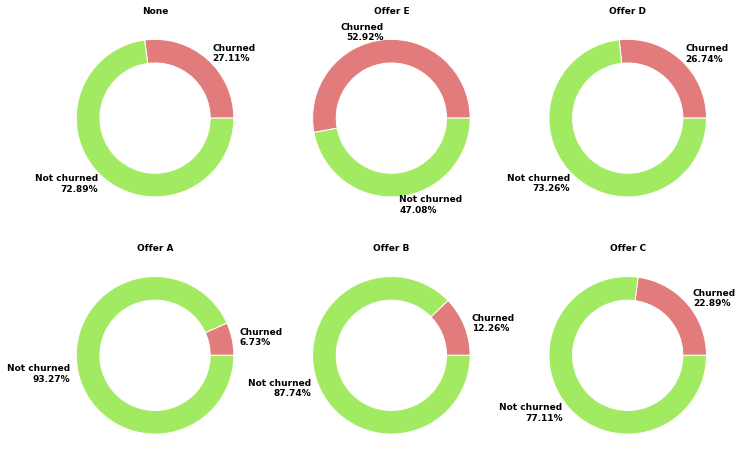

In [196]:
#@title ¿Hay alguna Oferta que tenga mas churned que las otras?
fig , ax = plt.subplots(2,3,figsize=(12,8))
ax = ax.flatten()
for i,offer in enumerate(df.offer.unique()):
    temp_df = df[df.offer==offer][['offer','customer_status']]
    temp_df = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)
    cat_comp_wheel_chart(temp_df.value_counts(normalize=True).sort_index(),
                         ax[i],
                         title=offer,
                         colors=[cat_palette[-1],
                                 cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 9 })

* Podemos observar que la oferta mas problematica es la **Oferta E** teniendo mas del 50% de usuarios Churned, habria que mejorarla.

* Luego las otras ofertas que impactan negativamente son la 
 **Oferta D y C** donde aproximadamente 1 de cada 4 usuarios es Churned.
* Tambien se puede ver que el 27% de los usuarios que no poseen oferta dejan el servicio, habria que meterlos en una oferta para disminuir las chances de que dejen.

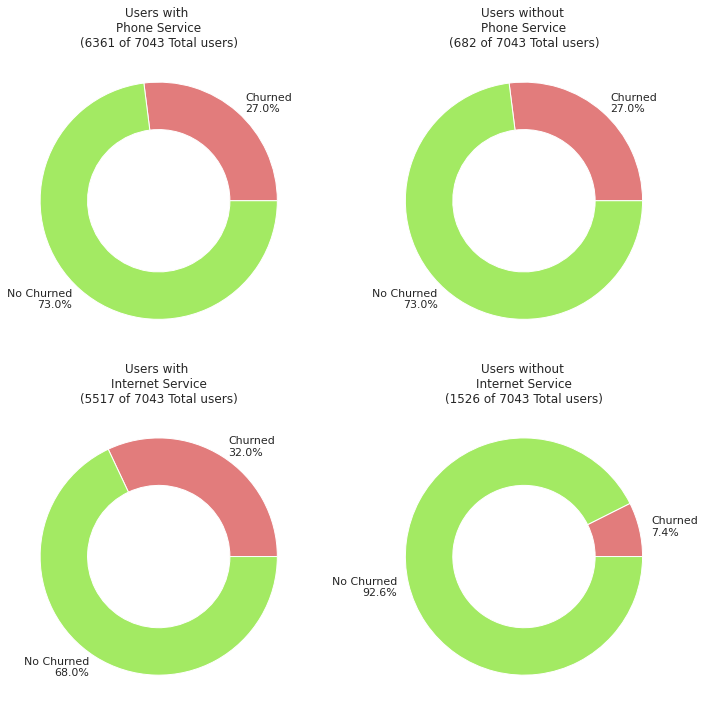

In [261]:
#@title ¿Hay algun servicio que impacte en los churned?

fig , ax = plt.subplots(2,2,figsize=(12,12))
ax = ax.flatten()
cmap = sns.color_palette([cat_palette[-1],cat_palette[1]])
font_s = 8

#Phone Y
temp_df = df[['customer_status','phone_service']].copy()
cond= temp_df['phone_service'] == 'Yes'
temp_df.loc[: ,'customer_status'] = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)

size_of_groups = temp_df[cond].value_counts(normalize=True).sort_index().round(2).values * 100
size_of_groups = size_of_groups.round(2)
labels = [i + f'\n{g}%'for i,g in zip(['Churned', 'No Churned'],size_of_groups)]

ax[0].pie(size_of_groups,labels=labels, radius=1,colors = cmap,
        wedgeprops=dict(width=0.4))

temp = len(df[df.phone_service =='Yes'])
ax[0].set_title(f'Users with \nPhone Service\n({temp} of {len(df)} Total users)')

#Phone N
temp_df = df[['customer_status','phone_service']].copy()
cond= temp_df['phone_service'] == 'Yes'
temp_df.loc[: ,'customer_status'] = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)

size_of_groups = temp_df[cond].value_counts(normalize=True).sort_index().round(2).values * 100
size_of_groups = size_of_groups.round(2)
labels = [i + f'\n{g}%'for i,g in zip(['Churned', 'No Churned'],size_of_groups)]

ax[1].pie(size_of_groups,labels=labels, radius=1,colors = cmap,
        wedgeprops=dict(width=0.4))
temp = len(df[df.phone_service =='No'])
ax[1].set_title(f'Users without \nPhone Service\n({temp} of {len(df)} Total users)')

#inter Y
temp_df = df[['customer_status','internet_service']].copy()
cond= temp_df['internet_service'] == 'Yes'
temp_df.loc[: ,'customer_status'] = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)

size_of_groups = temp_df[cond].value_counts(normalize=True).sort_index().round(2).values * 100
size_of_groups = size_of_groups.round(2)
labels = [i + f'\n{g}%'for i,g in zip(['Churned', 'No Churned'],size_of_groups)]

ax[2].pie(size_of_groups,labels=labels, radius=1,colors = cmap,
        wedgeprops=dict(width=0.4))

temp = len(df[df.internet_service =='Yes'])
ax[2].set_title(f'Users with \nInternet Service\n({temp} of {len(df)} Total users)')

#inter N
temp_df = df[['customer_status','internet_service']].copy()
cond= temp_df['internet_service'] == 'No'
temp_df.loc[: ,'customer_status'] = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)

size_of_groups = temp_df[cond].value_counts(normalize=True).sort_index().values * 100
size_of_groups = size_of_groups.round(2)
labels = [i + f'\n{g}%'for i,g in zip(['Churned', 'No Churned'],size_of_groups)]

ax[3].pie(size_of_groups,labels=labels, radius=1,colors = cmap,
        wedgeprops=dict(width=0.4))
temp = len(df[df.internet_service =='No'])
ax[3].set_title(f'Users without \nInternet Service\n({temp} of {len(df)} Total users)')
fig.show()

Los usuarios con servicio a internet tienden a dejar mas el servicio que los que no

In [252]:
#@title ¿Hay algun servicio que ofrecemos cause mas churned?¿Hay alguno que tenga mejor retencion?
# preparo los %

temp_dict = {"variable": [], "%_churned":[], "%_stayed":[]}

temp_df = df[df.customer_status != 'Joined'][['customer_status','internet_type','online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 
                        'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']]

for col in temp_df.columns:
    temp_df[col] =temp_df[col].apply(lambda x : f'{col} {x}' if x == 'Yes' or x == 'No' else x)

for col in ['internet_type','online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 
                        'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']:
    churneds_ctn = round(temp_df[temp_df.customer_status == 'Churned'][col].value_counts() / temp_df[col].value_counts() * 100,2)
    for key, valor in zip(churneds_ctn.keys(),churneds_ctn.values):
        temp_dict['variable'].append(key)
        temp_dict['%_churned'].append(valor)
        temp_dict['%_stayed'].append(100 - valor)

temp_df = pd.DataFrame(temp_dict)

fig = px.bar(temp_df, y = 'variable',x=['%_churned','%_stayed'],  barmode = 'stack', text_auto=True, color_discrete_sequence=["#e27c7c","#a3ea63"])
fig.update_traces( textposition='inside')
fig.update_layout( width = 700, height = 700)

fig.show()

Por lo que se puede ver, los servicios de fibra optica , datos ilimitados y streaming de tv y peliculas tienen mayor cantidad de churned por usuario.
  * Parece que hay problemas con la fibra optica, pueden provenir por ser uno de los servicios de internet mas comunes ofrecidos causando que haya mas volumen, asi como tambien puede proveenir de las fallas e inestabilidad en la red.
  * Por los datos ilimitados no creo que sea un problema sino que , al igual que la fibra optica, son los mas comunes a ofrecer.
  * En el caso de los servicios de streaming de peliculas y tv, se puede deber al catálogo de las mismas y/o a inestabilidades en el servicio.Habria que conseguir datos de los mismos para entrar en detalle al por qué.

Por otro lado los usuarios que contratan DSL, Servicio premium de soporte y el servicio de seguridad online tienden a quedarse asi que esos deben funcionar como deben.

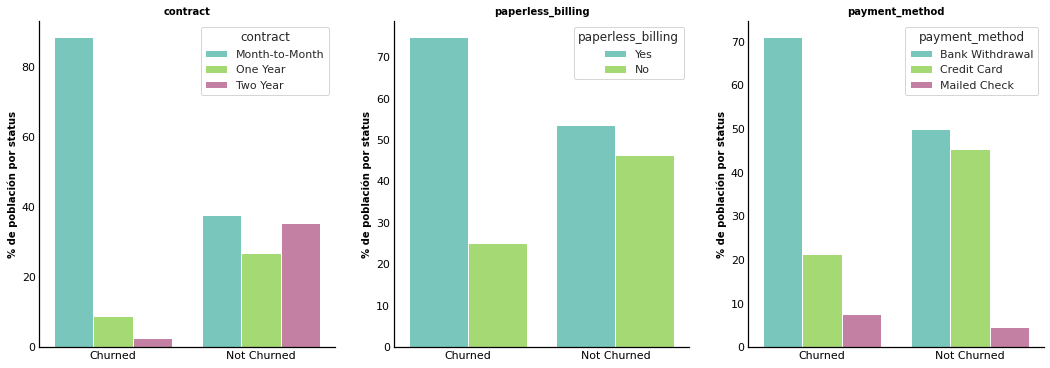

In [274]:
#@title ¿Las formas de pago afectan al estatus del usuario?
cols = ['contract', 'paperless_billing', 'payment_method']     
fig , ax = plt.subplots(1,3,figsize=(18,6))
multi_barplot(df.copy(),
              cols,
              ax,
              cat_palette,
              fontdict={'color': 'black', 'weight': 'bold', 'size': 10})

Podemos observar que los usuarios que pagan de mes a mes, los que tienen tarifa digital y los que pagan por medio de banco tienden a dejar mas el servicio.

## ¿Estara relacionala la Edad , genero y estatus civil del cliente con dejar o no el servicio?

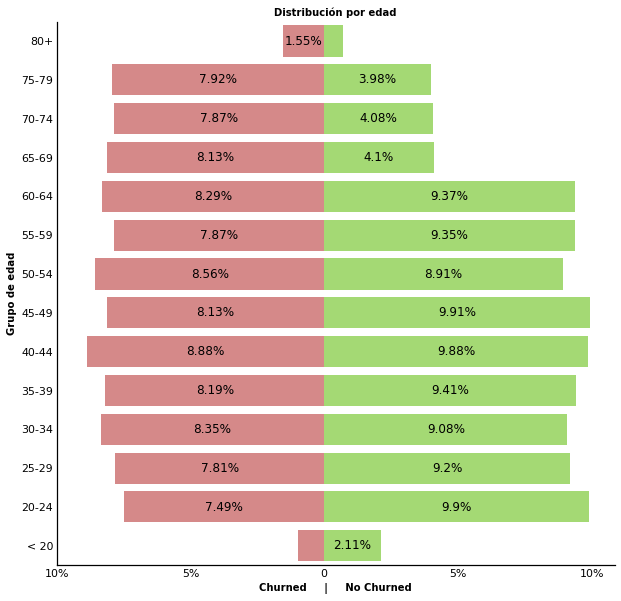

In [286]:
#@title Edad
fig , ax = plt.subplots(figsize=(10,10))
plot_age_pop(df.copy(),ax,colors=[cat_palette[-1],cat_palette[1]])

* Las personas mayores tienden a dejar mas el servicio que las mas jóvenes.

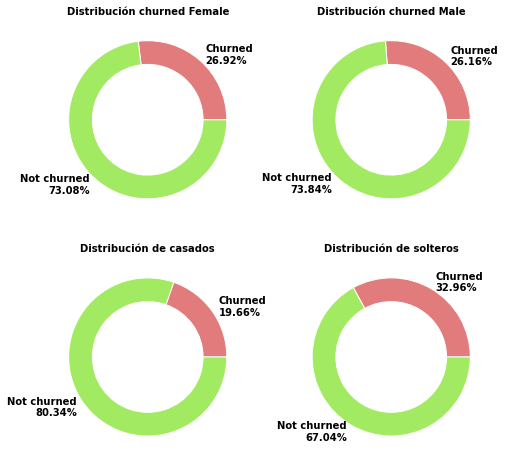

In [289]:
#@title Genero y Status Civil
fig , ax = plt.subplots(2,2,figsize=(8,8))
ax = ax.flatten()
temp_df = df[df['gender']=='Female'][['customer_status','gender']]
temp_df = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)
cat_comp_wheel_chart(temp_df.value_counts(normalize=True).sort_index(),ax[0],title=f'Distribución churned Female',colors=[cat_palette[-1],cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 10 })

temp_df = df[df['gender']=='Male'][['customer_status','gender']]
temp_df = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)
cat_comp_wheel_chart(temp_df.value_counts(normalize=True).sort_index(),ax[1],title=f'Distribución churned Male',colors=[cat_palette[-1],cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 10 })

temp_df = df[df['married']=='Yes'][['customer_status','married']]
temp_df = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)
cat_comp_wheel_chart(temp_df.value_counts(normalize=True).sort_index(),ax[2],title=f'Distribución de casados',colors=[cat_palette[-1],cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 10 })

temp_df = df[df['married']=='No'][['customer_status','married']]
temp_df = temp_df['customer_status'].apply(lambda x:'Not churned' if x != 'Churned' else x)
cat_comp_wheel_chart(temp_df.value_counts(normalize=True).sort_index(),ax[3],title=f'Distribución de solteros',colors=[cat_palette[-1],cat_palette[1]],fontdict={ 'color': 'black','weight': 'bold','size': 10 })


* No hay diferencia entre generos.
* Los solteros tienden a dejar el servicio mas que los casados.

# Procesamiento de datos

## Vuelvo a importar el dataset
* Para que quede en limpio por si modifique algo por accidente y sin la columna county ya que no la voy a necesitar en esta parte.
* Tambien voy a ignorar los usuarios joined ya que no los voy a usar.

In [291]:
df = pd.read_csv('https://github.com/Lemonpi3/datasets-coderhouse/blob/main/telecom_customer_churn.csv?raw=true')

#normalizo las columnas del dataset para manejarlas de forma mas comoda con pandas
rename_dict = {}
cols = list(df.columns)
cols = [col.lower().replace(' ','_') for col in cols]

for key in list(df.columns):
    for value in cols:
        rename_dict[key] = value
        cols.remove(value)
        break

df = df.rename(rename_dict,axis=1)
df = df[df.customer_status != 'Joined']
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Balanceando el Dataset

Como se vio en el EDA tenemos alrededor de un 70:30 de proporciones entre Stayed y Churned, lo cual puede hacer que el modelo tenga un bias a los stayed, lo mismo ocurrre para el segundo modelo que es aproximadamente 45:15:15:10:5 con las categorias de churn.

Para evitar eso voy a balancearlo por SMOTENC que es un algoritmo de oversampling que me permite agregarle a la clase minoritaria valoresde una forma mas similar a lo real.

Decidí no ir por undersampling para no perder registros.

### Limpieza de nulos
Antes de poder pasarlo por el SMONTENC tengo que asegurarme que no haya nulos.

In [292]:
#convierto Zipcode de numerica a objeto ya que una feature que divide por zonas, similar a la columna County que hice en el EDA.
df.zip_code = df.zip_code.astype('object')

In [293]:
#@markdown Por info del dataset en teoria las columnas con nulos se deben a que no tenian el servicio. Verifico
#@markdown > 
#@markdown No deberia haber nulos en las columnas 'Avg Monthly Long Distance Charges' y 'Multiple Lines' si tienen servicio telefonico como 'Yes'.
cond = (df.phone_service == 'Yes')
df[cond][['avg_monthly_long_distance_charges','multiple_lines']].isna().sum()

avg_monthly_long_distance_charges    0
multiple_lines                       0
dtype: int64

In [295]:
#@markdown Misma situacion para los servicios de internet, si tienen servicio, las columnas relacionadas no deberian tener nulos.
cond = (df['internet_service']=='Yes')
df[cond][['internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data']].isna().sum()

internet_type              0
avg_monthly_gb_download    0
online_security            0
online_backup              0
device_protection_plan     0
premium_tech_support       0
streaming_tv               0
streaming_movies           0
streaming_music            0
unlimited_data             0
dtype: int64

### Lleno nulos para poder pasarlo por SMOTENC
Como se verifica que los nulos son intencionales y no por mala imputacion o error, relleno los nulos con lo que me parece correcto 
>
Numericas -> 0
>
Categoricas -> No
>(Como casi todas son binarias de Yes/No tiene sentido que si no tienen sea No.)
>
En el caso de Internet type decido llenarlo tambien con No ya que quedaria diferenciado de los otros tipos como un "No tiene".

In [300]:
def clean_nulls_dataset(df:pd.DataFrame,cols_to_drop:list)->tuple:
  '''Reemplaza Nulos numericos con 0 y Categoricos con No
  
  Retorna copia del imputado df limpio y lista de indices de las variables categoricas'''
  df = df.drop(cols_to_drop,axis=1).copy()
  categorical_cols = []
  categorical_idx = []
  num_cols = []

  for i,col in enumerate(df.columns):
    if df[col].dtypes.str=='|O':
      categorical_idx.append(i)
      categorical_cols.append(col)
      print(f'CAT: {col}, {i}')
    else:
      num_cols.append(i)

  null_status = df.isna().sum()
  print(f'------------------\nNulos Inicial:\n------------------\n{null_status}')

  for col in categorical_cols:
    df[col].fillna('No',inplace=True)
  for col in numerical_cols:
    df[col].fillna(0,inplace=True)

  null_status = df.isna().sum()
  print(f'------------------\nNulos Final:\n------------------\n{null_status}')

  return df , categorical_idx

In [301]:
def get_num_and_cat_cols(df):
  categorical_cols = []
  num_cols = []

  for i,col in enumerate(df.columns):
    if df[col].dtypes.str=='|O':
      categorical_cols.append(col)
    else:
      num_cols.append(col)
  return num_cols,categorical_cols

In [302]:
numerical_cols,categorical_cols = get_num_and_cat_cols(df)

In [306]:
#Modelo 1: Clasificación Simple --> target = Customer Status 
#Modelo 2: Clasificacion Multiple --> target = Churn Category 

#quito las columnas de metadatos/que no voy a usar para cada modelo
print('-------------------------Modelo 1----------------------')
model_1_df ,cat_idx_1 = clean_nulls_dataset(df,['customer_id','churn_category','churn_reason'])
print('-------------------------Modelo 2----------------------')
cond = df.customer_status=='Churned'
model_2_df ,cat_idx_2 = clean_nulls_dataset(df[cond],['customer_id','customer_status','churn_reason'])

-------------------------Modelo 1----------------------
CAT: gender, 0
CAT: married, 2
CAT: city, 4
CAT: zip_code, 5
CAT: offer, 10
CAT: phone_service, 11
CAT: multiple_lines, 13
CAT: internet_service, 14
CAT: internet_type, 15
CAT: online_security, 17
CAT: online_backup, 18
CAT: device_protection_plan, 19
CAT: premium_tech_support, 20
CAT: streaming_tv, 21
CAT: streaming_movies, 22
CAT: streaming_music, 23
CAT: unlimited_data, 24
CAT: contract, 25
CAT: paperless_billing, 26
CAT: payment_method, 27
CAT: customer_status, 34
------------------
Nulos Inicial:
------------------
gender                                  0
age                                     0
married                                 0
number_of_dependents                    0
city                                    0
zip_code                                0
latitude                                0
longitude                               0
number_of_referrals                     0
tenure_in_months                        

In [307]:
#Separo en target para cada modelo
y_1 = model_1_df.pop('customer_status')
X_1 = model_1_df
print(f'Shape X_1: {X_1.shape}\nShape y:{y_1.shape}')

y_2 = model_2_df.pop('churn_category')
X_2 = model_2_df
print(f'Shape X_2: {X_2.shape}\nShape y_2:{y_2.shape}')

Shape X_1: (6589, 34)
Shape y:(6589,)
Shape X_2: (1869, 34)
Shape y_2:(1869,)


In [309]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1,y_1,train_size=0.7,test_size=0.3,stratify=y_1,random_state=0)

#Hago un split 80-20 para el segundo modelo por la poca cantidad de data disponible
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,y_2,train_size=0.8,test_size=0.2,stratify=y_2,random_state=0)

### Aplico SMOTENC

In [310]:
smote_nc = SMOTENC(categorical_features=cat_idx_1[0:len(cat_idx_1)-1],sampling_strategy='minority', random_state=0)
X_1_resampled, y_1_resampled = smote_nc.fit_resample(X_1_train, y_1_train)
print(f'len model_1_df X,y original: {len(X_1_train)}, {len(y_1_train)}\nlen model_1_df X,y resampled: {len(X_1_resampled)}, {len(y_1_resampled)}')

smote_nc = SMOTENC(categorical_features=cat_idx_2[0:len(cat_idx_2)-1], random_state=0)
X_2_resampled, y_2_resampled = smote_nc.fit_resample(X_2_train, y_2_train)
print(f'len model_2_df X,y original: {len(X_2_train)}, {len(y_2_train)}\nlen model_2_df X,y resampled: {len(X_2_resampled)}, {len(y_2_resampled)}')

len model_1_df X,y original: 4612, 4612
len model_1_df X,y resampled: 6608, 6608
len model_2_df X,y original: 1495, 1495
len model_2_df X,y resampled: 3365, 3365


In [312]:
#se reinicio el tipo de col para zip asi que lo cambio de vuelta
X_1_resampled.zip_code= X_1_resampled.zip_code.astype('object')
X_2_resampled.zip_code= X_2_resampled.zip_code.astype('object')

model_1_df = pd.concat([X_1_resampled,y_1_resampled],axis=1)
print(y_1_resampled.value_counts())
print('-'*30)
model_2_df = pd.concat([X_2_resampled,y_2_resampled],axis=1)
print(y_2_resampled.value_counts())

Stayed     3304
Churned    3304
Name: customer_status, dtype: int64
------------------------------
Dissatisfaction    673
Other              673
Competitor         673
Price              673
Attitude           673
Name: churn_category, dtype: int64


## Feature selection y Normalizacion de la data
Voy usar como metrica de mi modelo a optimizar recall y como metrica general el f1 ya que un falso negativo en churn es un cliente menos y para el problema que tiene la empresa esto es muy grave. 
Para feature selection voy a usar foward selection con SequentialFeatureSelector de sklearn.

Las variables categoricas nesecitan pasarse anumeros para pasar por algoritmo que uso para el feature selection y ya que estoy normalizo las variables numericas y divido el dataset en train y test usando pipeline.

In [313]:
num_cols,cat_cols = get_num_and_cat_cols(X_1_resampled)
print(f'Num cols: {num_cols}\nCat cols: {cat_cols}')

Num cols: ['age', 'number_of_dependents', 'latitude', 'longitude', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue']
Cat cols: ['gender', 'married', 'city', 'zip_code', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method']


### Feature selection Zip Code y ciudad
La columna zip code que fue omitida en el eda aporta información espacial de los usuarios , lo mismo para ciudad. Como son muchos unicos voy a ver cuantas columnas me agregarian en cada dataset con el fin de reducir el coste computacional.

In [314]:
cantidad_zip_1 = len(X_1_resampled['zip_code'].unique())
cantidad_zip_2 = len(X_2_resampled['zip_code'].unique())
cantidad_ciudad_1 =len(X_1_resampled['city'].unique())
cantidad_ciudad_2 =len(X_2_resampled['city'].unique())

print(f'Cantidad de columnas que me agregaria el One Hot del Zip Code\nModelo 1: {cantidad_zip_1}\nModelo 2: {cantidad_zip_2}\n--------------------------------------\nCantidad de columnas que me agregaria el One Hot de City\nModelo 1: {cantidad_ciudad_1}\nModelo 2: {cantidad_ciudad_2}\n--------------------------------------\nTotal Modelo 1: {cantidad_ciudad_1 + cantidad_zip_1}\nTotal Modelo 2: {cantidad_ciudad_2 + cantidad_zip_2}')

Cantidad de columnas que me agregaria el One Hot del Zip Code
Modelo 1: 1604
Modelo 2: 963
--------------------------------------
Cantidad de columnas que me agregaria el One Hot de City
Modelo 1: 1093
Modelo 2: 674
--------------------------------------
Total Modelo 1: 2697
Total Modelo 2: 1637


Como me agregan demaciadas columnas y tengo la latitud y longitud que aporta una informacion similar voy a optar por quitarlas manualmente si esto afecta drasticamente a la performance considerare agregarlas como ultimo recurso.

In [315]:
model_1_df = model_1_df.drop(['zip_code','city'],axis=1)
model_2_df = model_2_df.drop(['zip_code','city'],axis=1)

In [317]:
y_1 = model_1_df.pop('customer_status')
X_1 = model_1_df
print(f'Shape X_1: {X_1.shape}\nShape y:{y_1.shape}')

y_2 = model_2_df.pop('churn_category')
X_2 = model_2_df
print(f'Shape X_2: {X_2.shape}\nShape y_2:{y_2.shape}')

Shape X_1: (6608, 32)
Shape y:(6608,)
Shape X_2: (3365, 32)
Shape y_2:(3365,)


In [338]:
"""'offer', 'contract', 'payment_method','gender', 'Married','Phone Service', 'Multiple Lines', 'Internet Service','Online Security', 'Online Backup','Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing'""".lower().replace(", ",",").replace(" ,",",").replace(" ","_")

"'offer','contract','payment_method','gender','married','phone_service','multiple_lines','internet_service','online_security','online_backup','device_protection_plan','premium_tech_support','streaming_tv','streaming_movies','streaming_music','unlimited_data','paperless_billing'"

In [339]:
one_hot_cols = ['offer','contract','payment_method','gender','married','phone_service',
                'multiple_lines','internet_service','online_security','online_backup',
                'device_protection_plan','premium_tech_support','streaming_tv','streaming_movies',
                'streaming_music','unlimited_data','paperless_billing']
#la unica ordinal es internet type ya que esta ordenada por velocidad
ordinal_cols = ['internet_type']
#numericas
scaler_cols = ['age', 'number_of_dependents','avg_monthly_long_distance_charges',
               'avg_monthly_gb_download', 'monthly_charge', 'total_charges',
               'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue',
               'number_of_referrals', 'tenure_in_months', 'total_refunds','latitude', 'longitude']

## Pipeline

In [351]:
one_hot = OneHotEncoder()
ordinal = OrdinalEncoder(categories=[['No','Cable','DSL','Fiber Optic']])
rob_scaler = RobustScaler()

transformers=[
        ("one_hot", one_hot, one_hot_cols),
        ("ordinal", ordinal, ordinal_cols),
        ("std_scaler", rob_scaler, scaler_cols), 
    ]

#No voy a correr un pca inicialmente
# sfs = SFS(RandomForestClassifier(),
#           n_features_to_select=0.5,
#           scoring = make_scorer(f1_score,average='weighted'),
#           cv=2,
#           n_jobs= -1,
#           )

#lo hago función por si quiero experimentar sin tener que reescribir todo
def create_pipe(transformers):
  preprocessor = ColumnTransformer(
      transformers=transformers,
      remainder ='drop',
      sparse_threshold=0
  )

  steps = [
    ("preprocessing",preprocessor),
    # ("feature selection",feature_selector),
  ]
  return Pipeline(steps)

pipe = create_pipe(transformers)
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  ['offer', 'contract',
                                                   'payment_method', 'gender',
                                                   'married', 'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                   

In [352]:
X_1_fitter = pipe.fit(X_1,y_1)
y_1_fitter = LabelEncoder().fit(y_1)
X_1_train = X_1_fitter.transform(X_1)
y_1_train = y_1_fitter.transform(y_1)

In [353]:
X_2_fitter = pipe.fit(X_2,y_2)
y_2_fitter = LabelEncoder().fit(y_2)
X_2_prepared = X_2_fitter.transform(X_2)
y_2_prepared = y_2_fitter.transform(y_2)

# Entrenando Modelos

In [354]:
def cross_validate_model(model,X,y,scoring,cv=10):
  cv = cross_validate(
    model,
    X,
    y,
    scoring=scoring,
    return_estimator=True,
    cv=cv,
    n_jobs=-1)
  
  estimator = cv['estimator'][0]
  print(f'estimator: {estimator}\n----------')
  fit_time = cv['fit_time'].mean()
  print(f'fit_time_mean: {round(fit_time,2)}\n----------')
  score_time= round(cv['score_time'].mean(),2)
  print(f'pred_time_mean: {round(score_time,2)}\n----------')

  scores = []
  for score in scoring:
    key = f'test_{score}'
    print(f'{score} mean: {round(cv[key].mean(),2)}\n----------')

  return cv

def evaluar_modelo(model,X_test,y_test,X_train,y_train,target_names,y_fitter,average='binary',xticks_rotation='horizontal',n_clases=None):
  '''
  imprime la evaluacion del modelo y dibuja una confusion matrix 
  
  retorna diccionario con recall precision y f1 del test'''
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print(f'{model}\n')

  #stats
  recall_train = recall_score(y_train,y_train_pred,average=average)
  precision_train = precision_score(y_train,y_train_pred,average=average)
  f1_train = f1_score(y_train,y_train_pred,average=average)
  classification_report_train = classification_report(y_train,y_train_pred,target_names=target_names)
  print(f'-------TRAIN-------\nrecall_score: {round(recall_train,4)}\nprecision: {round(precision_train,4)}\nf1: {round(f1_train,4)}\nreport: \n{classification_report_train}')

  #stats
  encoded_y_test =y_fitter.transform(y_test)
  recall_test = recall_score(encoded_y_test,y_test_pred,average=average)
  precision_test = precision_score(encoded_y_test,y_test_pred,average=average)
  f1_test = f1_score(encoded_y_test,y_test_pred,average=average)
  classification_report_test = classification_report(encoded_y_test,y_test_pred,target_names=target_names)

  if n_clases == 2:
    #AUC  
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(encoded_y_test, probs)
    auc = roc_auc_score(encoded_y_test, probs)
    print(f'-------TEST-------\nrecall_score: {round(recall_test,4)}\nprecision: {round(precision_test,4)}\nf1: {round(f1_test,4)}\nAUC SCORE: {round(auc,4)}\nreport: \n{classification_report_test}\n')
    
    #-------graficos-------
    fig,ax = plt.subplots(ncols=2,figsize=(16,8))
    #confusion matrix
    plot_confusion_matrix(model, X_test, encoded_y_test, display_labels=target_names,xticks_rotation=xticks_rotation,ax=ax[0])

    #roc auc
    ax[1].set_title('ROC Curve')
    ax[1].plot([0, 1], [0, 1], linestyle='--')
    ax[1].plot(fpr, tpr, 'r', marker='.',label = '%.3f' % auc)
    ax[1].legend(loc = 'lower right')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    plt.show()
    return {'recall':recall_test, 'precision':precision_test, 'f1':f1_test,'auc':auc, 'report':classification_report_test,  'graphs' :fig}

  else:
    print(f'-------TEST-------\nrecall_score: {round(recall_test,4)}\nprecision: {round(precision_test,4)}\nf1: {round(f1_test,4)}\nreport: \n{classification_report_test}\n')
    fig,ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(model, X_test, encoded_y_test, display_labels=target_names,xticks_rotation=xticks_rotation,ax=ax)

  plt.show()
  return {'recall':recall_test, 'precision':precision_test, 'f1':f1_test, 'report':classification_report_test,'graphs' :fig}

## Modelo 1 Clasificación simple (Churned/Stayed)

In [355]:
y_1_fitter.inverse_transform([0,1])

array(['Churned', 'Stayed'], dtype=object)

TreeClasifier
DecisionTreeClassifier(random_state=0)

-------TRAIN-------
recall_score: 1.0
precision: 1.0
f1: 1.0
report: 
              precision    recall  f1-score   support

     Churned       1.00      1.00      1.00      3304
      Stayed       1.00      1.00      1.00      3304

    accuracy                           1.00      6608
   macro avg       1.00      1.00      1.00      6608
weighted avg       1.00      1.00      1.00      6608

-------TEST-------
recall_score: 0.7597
precision: 0.7526
f1: 0.7554
AUC SCORE: 0.688
report: 
              precision    recall  f1-score   support

     Churned       0.59      0.52      0.55       561
      Stayed       0.82      0.85      0.84      1416

    accuracy                           0.76      1977
   macro avg       0.70      0.69      0.69      1977
weighted avg       0.75      0.76      0.76      1977




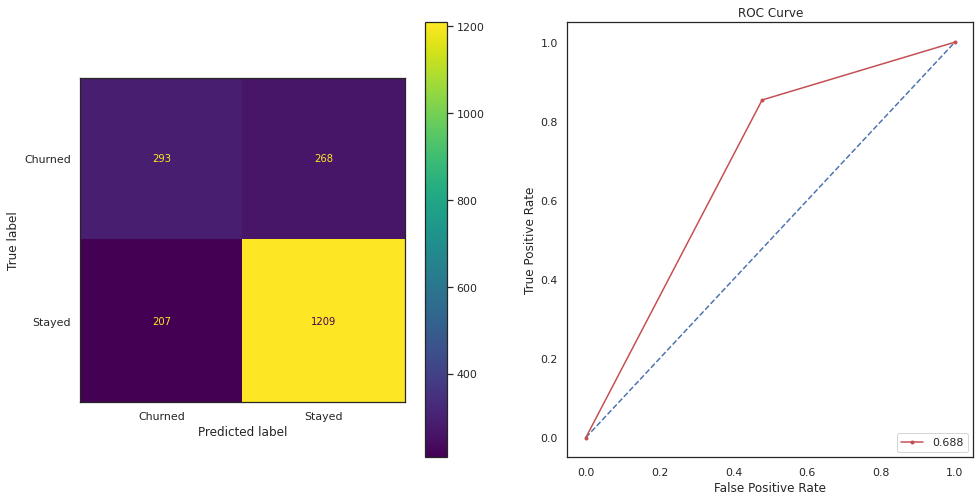

XGBoost
GradientBoostingClassifier(random_state=0)

-------TRAIN-------
recall_score: 0.9104
precision: 0.9105
f1: 0.9104
report: 
              precision    recall  f1-score   support

     Churned       0.91      0.92      0.91      3304
      Stayed       0.92      0.90      0.91      3304

    accuracy                           0.91      6608
   macro avg       0.91      0.91      0.91      6608
weighted avg       0.91      0.91      0.91      6608

-------TEST-------
recall_score: 0.8326
precision: 0.8274
f1: 0.828
AUC SCORE: 0.9065
report: 
              precision    recall  f1-score   support

     Churned       0.74      0.63      0.68       561
      Stayed       0.86      0.91      0.89      1416

    accuracy                           0.83      1977
   macro avg       0.80      0.77      0.78      1977
weighted avg       0.83      0.83      0.83      1977




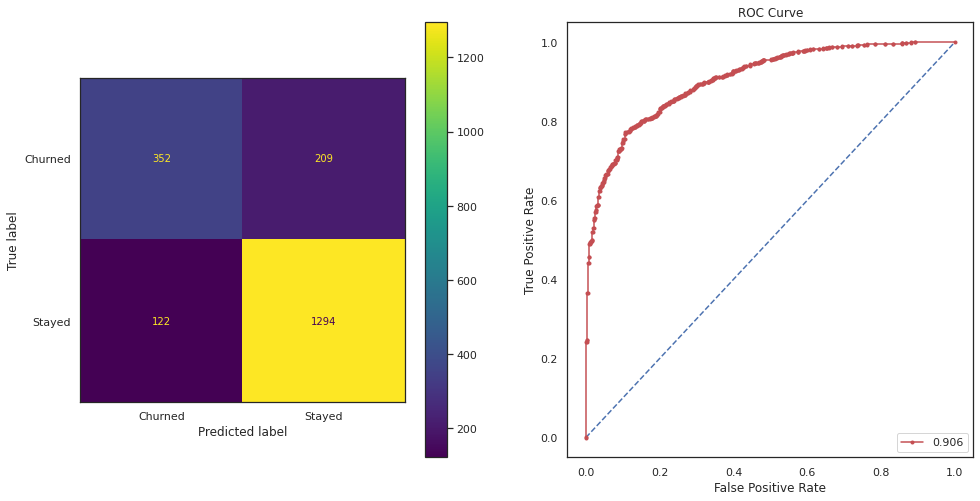

RandomForestClassifier
RandomForestClassifier(random_state=0)

-------TRAIN-------
recall_score: 0.9998
precision: 0.9998
f1: 0.9998
report: 
              precision    recall  f1-score   support

     Churned       1.00      1.00      1.00      3304
      Stayed       1.00      1.00      1.00      3304

    accuracy                           1.00      6608
   macro avg       1.00      1.00      1.00      6608
weighted avg       1.00      1.00      1.00      6608

-------TEST-------
recall_score: 0.826
precision: 0.8207
f1: 0.8156
AUC SCORE: 0.8893
report: 
              precision    recall  f1-score   support

     Churned       0.78      0.54      0.64       561
      Stayed       0.84      0.94      0.89      1416

    accuracy                           0.83      1977
   macro avg       0.81      0.74      0.76      1977
weighted avg       0.82      0.83      0.82      1977




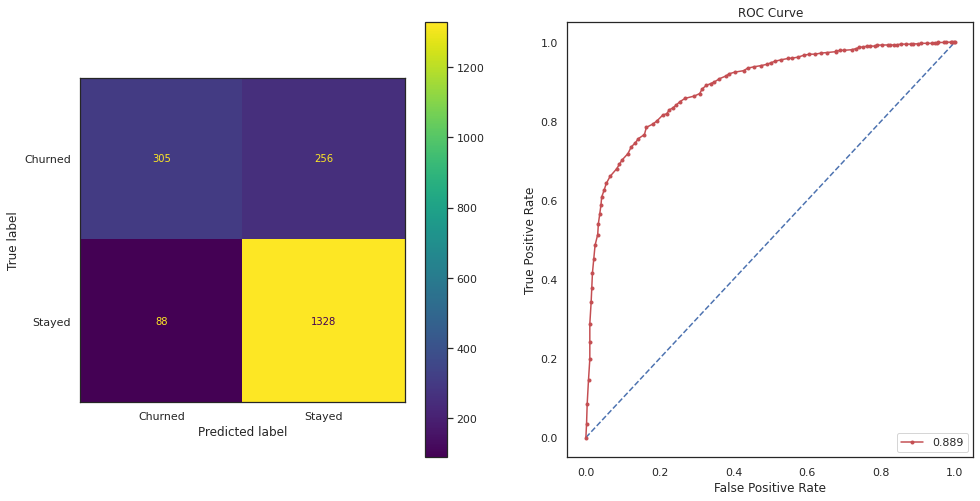

In [356]:
#Pruebo modelos
models = {
    'TreeClasifier': DecisionTreeClassifier(random_state=0), #mi modelo base como el mas simple
    'XGBoost': GradientBoostingClassifier(random_state=0), 
    'RandomForestClassifier': RandomForestClassifier(random_state=0)
}

X_1_test_prepared = X_1_fitter.transform(X_1_test)

trained_models_1={}

for i in range(len(list(models))):
  model = list(models.values())[i]
  key =list(models.keys())[i]
  print(f'{bcolors.OKCYAN}=============\n{key}\n============={bcolors.ENDC}')
  model.fit(X_1_train,y_1_train)

  metrics = evaluar_modelo(
    model,
    X_1_test_prepared,
    y_1_test,
    X_1_train,
    y_1_train,
    ['Churned', 'Stayed'],
    y_1_fitter,
    average='weighted',
    n_clases=2
    )
  
  trained_models_1[key]= {'model':model,'metrics':metrics}

In [357]:
print('Resultados de los modelos en Test')
for key in trained_models_1.keys():
  print(f'{bcolors.OKCYAN}=============\n{key}\n============={bcolors.ENDC}')
  print('AUC: '+str(round(trained_models_1[key]['metrics']['auc'],4)))
  print(trained_models_1[key]['metrics']['report'])

Resultados de los modelos en Test
TreeClasifier
AUC: 0.688
              precision    recall  f1-score   support

     Churned       0.59      0.52      0.55       561
      Stayed       0.82      0.85      0.84      1416

    accuracy                           0.76      1977
   macro avg       0.70      0.69      0.69      1977
weighted avg       0.75      0.76      0.76      1977

XGBoost
AUC: 0.9065
              precision    recall  f1-score   support

     Churned       0.74      0.63      0.68       561
      Stayed       0.86      0.91      0.89      1416

    accuracy                           0.83      1977
   macro avg       0.80      0.77      0.78      1977
weighted avg       0.83      0.83      0.83      1977

RandomForestClassifier
AUC: 0.8893
              precision    recall  f1-score   support

     Churned       0.78      0.54      0.64       561
      Stayed       0.84      0.94      0.89      1416

    accuracy                           0.83      1977
   macro avg  

In [358]:
cross_validate_model(models['XGBoost'],X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])

estimator: GradientBoostingClassifier(random_state=0)
----------
fit_time_mean: 6.97
----------
pred_time_mean: 0.01
----------
recall_weighted mean: 0.89
----------
f1_weighted mean: 0.89
----------
accuracy mean: 0.89
----------


{'fit_time': array([5.08006978, 6.4086647 , 8.13675618, 7.704386  , 9.12192202,
        8.87158132, 6.6180377 , 6.13695312, 5.94520664, 5.69443846]),
 'score_time': array([0.00703263, 0.02313781, 0.02493429, 0.01369834, 0.00657868,
        0.00814009, 0.02180862, 0.01362681, 0.00589633, 0.01207256]),
 'estimator': [GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0)],
 'test_recall_weighted': array([0.82602118, 0.8623298 , 0.84114977, 0.84568835, 0.93797277,
        0.94099849, 0.89561271, 0.92133132, 0.92575758, 0.92121212]),
 'test_f1_weighted': array([0.82557322, 0.86155339, 0.84101149

In [359]:
cross_validate_model(models['RandomForestClassifier'],X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])

estimator: RandomForestClassifier(random_state=0)
----------
fit_time_mean: 2.02
----------
pred_time_mean: 0.06
----------
recall_weighted mean: 0.89
----------
f1_weighted mean: 0.89
----------
accuracy mean: 0.89
----------


{'fit_time': array([2.45238185, 2.53496122, 2.48962092, 2.3640027 , 2.10435677,
        2.01117682, 1.53345895, 1.59854913, 1.54286003, 1.57417917]),
 'score_time': array([0.09387541, 0.08720756, 0.09360814, 0.04901481, 0.04081655,
        0.04516888, 0.04854274, 0.05204225, 0.03991342, 0.0268836 ]),
 'estimator': [RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0)],
 'test_recall_weighted': array([0.83055976, 0.8366112 , 0.81089259, 0.83055976, 0.94553707,
        0.95612708, 0.92435703, 0.92738275, 0.94545455, 0.93333333]),
 'test_f1_weighted': array([0.82956493, 0.83523076, 0.80982608, 0.82978833, 0.94543565,
        0.9560

In [361]:
cross_validate_model(models['TreeClasifier'],X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])

estimator: DecisionTreeClassifier(random_state=0)
----------
fit_time_mean: 0.38
----------
pred_time_mean: 0.01
----------
recall_weighted mean: 0.84
----------
f1_weighted mean: 0.84
----------
accuracy mean: 0.84
----------


{'fit_time': array([0.36207962, 0.30652547, 0.31080461, 0.30914807, 0.30084038,
        0.3242805 , 0.46178293, 0.47469544, 0.49091983, 0.4906621 ]),
 'score_time': array([0.01463699, 0.01796937, 0.00387383, 0.01437235, 0.00438786,
        0.01320505, 0.01426625, 0.01215649, 0.01063228, 0.01130724]),
 'estimator': [DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0)],
 'test_recall_weighted': array([0.79576399, 0.80332829, 0.76853253, 0.77912254, 0.89258699,
        0.89258699, 0.86384266, 0.86384266, 0.88939394, 0.88939394]),
 'test_f1_weighted': array([0.79479168, 0.80226373, 0.7682875 , 0.77829027, 0.89234254,
        0.8924

XGboost y RandomForest performaron mejor. El random forest overfiteo el train.Pueden mejorarse, pero no fueron tan malos lso resultados 0.89 f1 ,recall y accuracy en la cross validation.

## Modelo 2 Clasificación Multiple (Competition/Attitude/Price/Dissatisfaction/Other)

Para este modelo me importa mas el f1 y accuracy

In [362]:
y_2_fitter.inverse_transform([0,1,2,3,4])

array(['Attitude', 'Competitor', 'Dissatisfaction', 'Other', 'Price'],
      dtype=object)

TreeClasifier
DecisionTreeClassifier(random_state=0)

-------TRAIN-------
recall_score: 1.0
precision: 1.0
f1: 1.0
report: 
                 precision    recall  f1-score   support

       Attitude       1.00      1.00      1.00       673
     Competitor       1.00      1.00      1.00       673
Dissatisfaction       1.00      1.00      1.00       673
          Other       1.00      1.00      1.00       673
          Price       1.00      1.00      1.00       673

       accuracy                           1.00      3365
      macro avg       1.00      1.00      1.00      3365
   weighted avg       1.00      1.00      1.00      3365

-------TEST-------
recall_score: 0.2727
precision: 0.3063
f1: 0.2873
report: 
                 precision    recall  f1-score   support

       Attitude       0.14      0.16      0.15        63
     Competitor       0.50      0.42      0.46       168
Dissatisfaction       0.23      0.22      0.22        64
          Other       0.04      0.05      0.04       

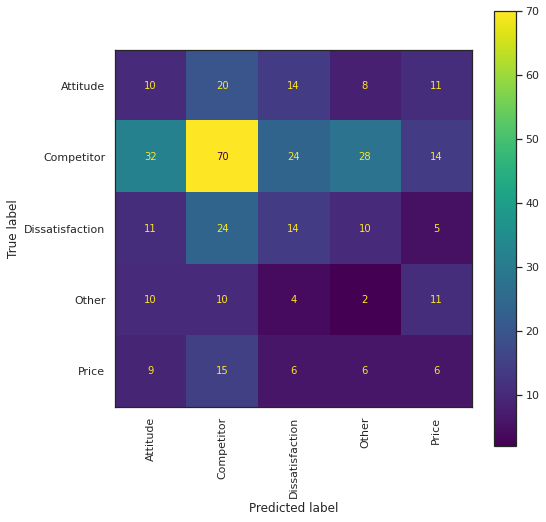

XGBoost
GradientBoostingClassifier(random_state=0)

-------TRAIN-------
recall_score: 0.7857
precision: 0.7867
f1: 0.7847
report: 
                 precision    recall  f1-score   support

       Attitude       0.80      0.77      0.78       673
     Competitor       0.77      0.71      0.74       673
Dissatisfaction       0.80      0.76      0.78       673
          Other       0.76      0.88      0.82       673
          Price       0.80      0.81      0.80       673

       accuracy                           0.79      3365
      macro avg       0.79      0.79      0.78      3365
   weighted avg       0.79      0.79      0.78      3365

-------TEST-------
recall_score: 0.3396
precision: 0.3517
f1: 0.3452
report: 
                 precision    recall  f1-score   support

       Attitude       0.19      0.21      0.20        63
     Competitor       0.58      0.55      0.56       168
Dissatisfaction       0.22      0.20      0.21        64
          Other       0.07      0.08      0.08

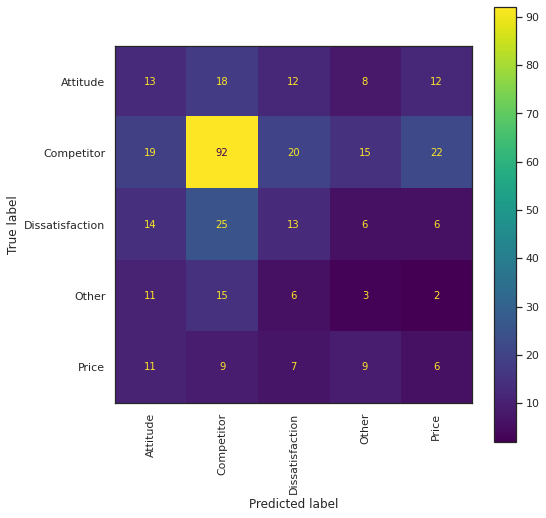

RandomForestClassifier
RandomForestClassifier(random_state=0)

-------TRAIN-------
recall_score: 1.0
precision: 1.0
f1: 1.0
report: 
                 precision    recall  f1-score   support

       Attitude       1.00      1.00      1.00       673
     Competitor       1.00      1.00      1.00       673
Dissatisfaction       1.00      1.00      1.00       673
          Other       1.00      1.00      1.00       673
          Price       1.00      1.00      1.00       673

       accuracy                           1.00      3365
      macro avg       1.00      1.00      1.00      3365
   weighted avg       1.00      1.00      1.00      3365

-------TEST-------
recall_score: 0.3422
precision: 0.329
f1: 0.3352
report: 
                 precision    recall  f1-score   support

       Attitude       0.23      0.24      0.23        63
     Competitor       0.52      0.55      0.54       168
Dissatisfaction       0.21      0.20      0.20        64
          Other       0.03      0.03      0.0

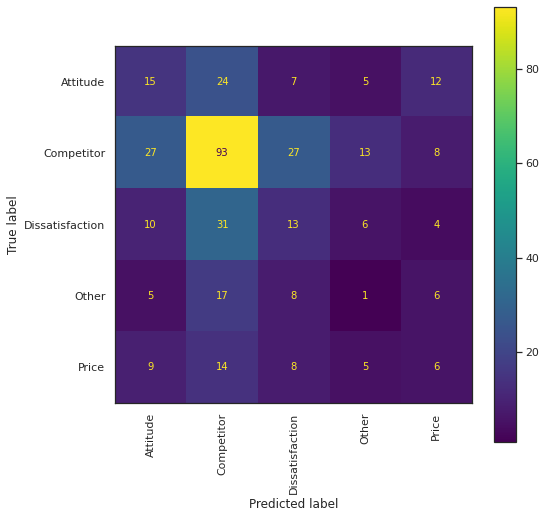

In [363]:
#Pruebo modelos
models = {
    'TreeClasifier': DecisionTreeClassifier(random_state=0), #mi modelo base como el mas simple
    'XGBoost': GradientBoostingClassifier(random_state=0), 
    'RandomForestClassifier': RandomForestClassifier(random_state=0)
}

X_2_test_prepared = X_2_fitter.transform(X_2_test)

trained_models_2={}

for i in range(len(list(models))):
  model = list(models.values())[i]
  key =list(models.keys())[i]
  print(f'{bcolors.OKCYAN}=============\n{key}\n============={bcolors.ENDC}')
  model.fit(X_2_prepared,y_2_prepared)

  metrics = evaluar_modelo(
    model,
    X_2_test_prepared,
    y_2_test,
    X_2_prepared,
    y_2_prepared,
    ['Attitude', 'Competitor', 'Dissatisfaction', 'Other', 'Price'],
    y_2_fitter,
    average='weighted',
    xticks_rotation='vertical',
    )
  
  trained_models_2[key]= {'model':model,'metrics':metrics}

In [365]:
print('Resultados de los modelos en Test')
for key in trained_models_2.keys():
  print(f'{bcolors.OKCYAN}=============\n{key}\n============={bcolors.ENDC}')
  print(trained_models_2[key]['metrics']['report'])

Resultados de los modelos en Test
TreeClasifier
                 precision    recall  f1-score   support

       Attitude       0.14      0.16      0.15        63
     Competitor       0.50      0.42      0.46       168
Dissatisfaction       0.23      0.22      0.22        64
          Other       0.04      0.05      0.04        37
          Price       0.13      0.14      0.13        42

       accuracy                           0.27       374
      macro avg       0.21      0.20      0.20       374
   weighted avg       0.31      0.27      0.29       374

XGBoost
                 precision    recall  f1-score   support

       Attitude       0.19      0.21      0.20        63
     Competitor       0.58      0.55      0.56       168
Dissatisfaction       0.22      0.20      0.21        64
          Other       0.07      0.08      0.08        37
          Price       0.12      0.14      0.13        42

       accuracy                           0.34       374
      macro avg       0.24 

In [364]:
cross_validate_model(models['XGBoost'],X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])

estimator: GradientBoostingClassifier(random_state=0)
----------
fit_time_mean: 14.93
----------
pred_time_mean: 0.01
----------
recall_weighted mean: 0.61
----------
f1_weighted mean: 0.61
----------
accuracy mean: 0.61
----------


{'fit_time': array([15.329669  , 15.60993338, 15.18238091, 15.04381943, 17.26923299,
        17.18496442, 17.65848708, 16.58962989,  9.90550566,  9.55660653]),
 'score_time': array([0.02371573, 0.0093503 , 0.00856328, 0.00895405, 0.00811195,
        0.01391029, 0.00834203, 0.00878692, 0.00833297, 0.0056591 ]),
 'estimator': [GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0),
  GradientBoostingClassifier(random_state=0)],
 'test_recall_weighted': array([0.43026706, 0.41246291, 0.52225519, 0.6379822 , 0.66765579,
        0.67857143, 0.69642857, 0.70238095, 0.72916667, 0.64285714]),
 'test_f1_weighted': array([0.43552864, 0.4144107 , 

In [367]:
cross_validate_model(models['TreeClasifier'],X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])

estimator: DecisionTreeClassifier(random_state=0)
----------
fit_time_mean: 0.08
----------
pred_time_mean: 0.0
----------
f1_weighted mean: 0.54
----------
accuracy mean: 0.54
----------


{'fit_time': array([0.08856654, 0.08425617, 0.08258486, 0.09011698, 0.0739851 ,
        0.08077788, 0.07364917, 0.08057261, 0.07505155, 0.07365632]),
 'score_time': array([0.00251341, 0.00234294, 0.00229621, 0.00191236, 0.00228   ,
        0.00223064, 0.00228548, 0.00247264, 0.00229335, 0.00151968]),
 'estimator': [DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0),
  DecisionTreeClassifier(random_state=0)],
 'test_f1_weighted': array([0.39035287, 0.36344846, 0.45004877, 0.48337655, 0.6110685 ,
        0.60678104, 0.63485077, 0.58315182, 0.62352577, 0.60708846]),
 'test_accuracy': array([0.39169139, 0.36498516, 0.45400593, 0.48664688, 0.61721068,
        0.61011905, 0

In [366]:
cross_validate_model(models['RandomForestClassifier'],X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])

estimator: RandomForestClassifier(random_state=0)
----------
fit_time_mean: 1.08
----------
pred_time_mean: 0.04
----------
f1_weighted mean: 0.73
----------
accuracy mean: 0.73
----------


{'fit_time': array([1.0383749 , 1.08650899, 1.03860688, 1.05070686, 1.08633304,
        1.11336851, 1.10053015, 1.12809849, 1.05401182, 1.082165  ]),
 'score_time': array([0.03469515, 0.04495597, 0.03314734, 0.04174066, 0.03450847,
        0.04045033, 0.03537297, 0.05892825, 0.03365898, 0.02261853]),
 'estimator': [RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0),
  RandomForestClassifier(random_state=0)],
 'test_f1_weighted': array([0.45399707, 0.51225108, 0.58918572, 0.70912378, 0.78774212,
        0.83533682, 0.83636127, 0.86617933, 0.86370924, 0.8471762 ]),
 'test_accuracy': array([0.44807122, 0.50445104, 0.59347181, 0.71513353, 0.80118694,
        0.8422619 , 0

Estos modelos no performaron tan bien, El mejor fue el RandomForest con 0.73 de f1 y accuracy en la validacion cruzada

# Mejorando Modelos

## Modelo 2

Empecemos por el segundo modelo que es el que peor esta.

Voy a usar Random Search y luego gridsearch con el RandomForest que fue el que mejor performo.

### Random Search

In [372]:
scoring = {'accuracy':'accuracy','f1':'f1_weighted'}

rfc_r_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400]
}

random_cv_models = [
    ('RandomForestClassifier', RandomForestClassifier(random_state=0, n_jobs=-1), rfc_r_params)
]

results = []
for i in range(len(random_cv_models)):
  model = random_cv_models[i][1]
  model_name = random_cv_models[i][0]
  params = random_cv_models[i][2]
  print(f'{bcolors.OKCYAN}=============\n{model_name}\n============={bcolors.ENDC}')

  clf = RandomizedSearchCV(model,
                    params,
                    scoring=scoring,
                    refit='f1',
                    return_train_score=True,
                    verbose=1,
                    n_iter = 100,
                    n_jobs=-1)
  
  clf.fit(X_2_prepared,y_2_prepared)
  results.append((model_name,clf))

RandomForestClassifier
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [373]:
clf.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

Comparo el modelo de random search con el inicial usando los resultados de la crossvalidation.

In [376]:
#Inicial
print('----------Inicial---------')
cross_validate_model(models['RandomForestClassifier'],X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])
print('--------------------------')
print('----------Random----------')
rng_rfc = RandomForestClassifier(n_estimators=300,min_samples_split=2,min_samples_leaf=1,
                                 max_features='auto',max_depth=20,bootstrap=False,random_state=0, n_jobs=-1)
cross_validate_model(rng_rfc,X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])
print('--------------------------')

----------Inicial---------
estimator: RandomForestClassifier(random_state=0)
----------
fit_time_mean: 1.16
----------
pred_time_mean: 0.04
----------
f1_weighted mean: 0.73
----------
accuracy mean: 0.73
----------
--------------------------
----------Random----------


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



estimator: RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=300,
                       n_jobs=-1, random_state=0)
----------
fit_time_mean: 4.97
----------
pred_time_mean: 0.22
----------
f1_weighted mean: 0.74
----------
accuracy mean: 0.74
----------
--------------------------


Mejoro un 1% es algo vamos a ver si podemos mejorarlo mas

### Grid Search

In [380]:
scoring = {'accuracy':'accuracy','f1':'f1_weighted'}

rfc_params = {
    'max_depth': [15,None,20,25],
    'max_features': [5,'auto',8],
    'min_samples_split': [2,3],
    'n_estimators': [250,300,350]
}

random_cv_models = [
    ('RandomForest', RandomForestClassifier(min_samples_leaf=1,bootstrap=False,random_state=0,n_jobs=-1), rfc_params)
]

results = []
for i in range(len(random_cv_models)):
  model = random_cv_models[i][1]
  model_name = random_cv_models[i][0]
  params = random_cv_models[i][2]
  print(f'{bcolors.OKCYAN}=============\n{model_name}\n============={bcolors.ENDC}')

  clf = GridSearchCV(model,
                     params,
                     scoring=scoring,
                     refit='f1',
                     return_train_score=True,
                     verbose=1,
                     n_jobs=-1)
  
  clf.fit(X_2_prepared,y_2_prepared)
  results.append((model_name,clf))

RandomForest
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [381]:
clf.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 3,
 'n_estimators': 350}

In [382]:
#comparo random con grid
print('----------Random----------')
rng_rfc = RandomForestClassifier(n_estimators=300,min_samples_split=2,min_samples_leaf=1,
                                 max_features='auto',max_depth=20,bootstrap=False,random_state=0, n_jobs=-1)
cross_validate_model(rng_rfc,X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])
print('--------------------------')
print('-----------Grid-----------')
grid_rfc = RandomForestClassifier(max_depth= None,max_features=5,min_samples_split=3,min_samples_leaf=1,
                                  n_estimators=350,bootstrap=False, random_state=0, n_jobs=-1)
cross_validate_model(grid_rfc,X_2_prepared,y_2_prepared,['f1_weighted','accuracy'])
print('--------------------------')

----------Random----------


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



estimator: RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=300,
                       n_jobs=-1, random_state=0)
----------
fit_time_mean: 5.97
----------
pred_time_mean: 0.23
----------
f1_weighted mean: 0.74
----------
accuracy mean: 0.74
----------
--------------------------
-----------Grid-----------


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



estimator: RandomForestClassifier(bootstrap=False, max_features=5, min_samples_split=3,
                       n_estimators=350, n_jobs=-1, random_state=0)
----------
fit_time_mean: 4.55
----------
pred_time_mean: 0.24
----------
f1_weighted mean: 0.74
----------
accuracy mean: 0.75
----------
--------------------------


0.75 accuracy, apenas mejor q el random pero mejor.

In [390]:
modelo_2 = RandomForestClassifier(max_depth= None,max_features=5,min_samples_split=3,min_samples_leaf=1,
                                  n_estimators=350,bootstrap=False, random_state=0, n_jobs=-1)

modelo_2.fit(X_2_prepared,y_2_prepared)

RandomForestClassifier(bootstrap=False, max_features=5, min_samples_split=3,
                       n_estimators=350, n_jobs=-1, random_state=0)

### Feature importances del modelo_2 final

In [391]:
#saco los nombres delas columnas para ver la feature importance de ambos modelos
one_hot_cols = pipe.named_steps["preprocessing"].named_transformers_['one_hot'].get_feature_names()
all_pipe_cols = np.concatenate([one_hot_cols,ordinal_cols,scaler_cols])
len(all_pipe_cols)

55

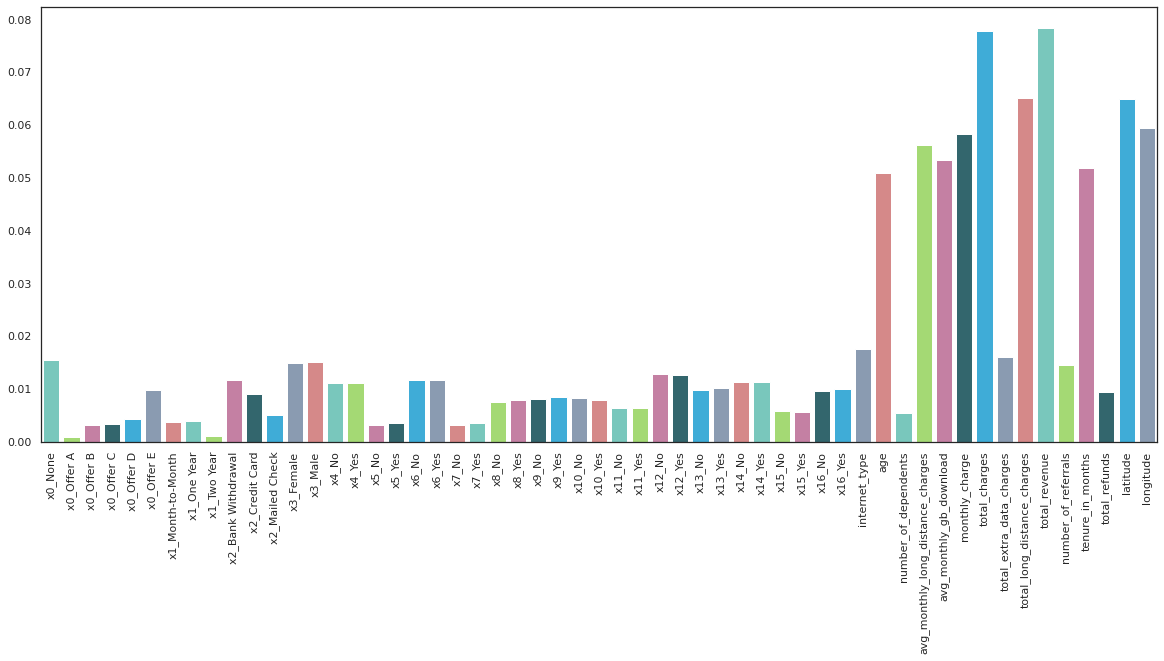

In [394]:
feature_importances = modelo_2.feature_importances_

fig, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x=all_pipe_cols,y=feature_importances,ax=ax,palette= cat_palette)
plt.xticks(rotation=90)
plt.show()

In [409]:
feature_importance_modelo_2 = pd.DataFrame({'columna':all_pipe_cols,'importancia':feature_importances * 100})
feature_importance_modelo_2 = feature_importance_modelo_2.sort_values('importancia',ascending=False)
feature_importance_modelo_2.head(15).reset_index(drop=True).style.background_gradient(cmap="Greens")

,columna,importancia
0,total_revenue,7.842421
1,total_charges,7.775935
2,total_long_distance_charges,6.509106
3,latitude,6.481753
4,longitude,5.935413
5,monthly_charge,5.822657
6,avg_monthly_long_distance_charges,5.615697
7,avg_monthly_gb_download,5.344689
8,tenure_in_months,5.176605
9,age,5.090450


El modelo 2 tubo feature imporances similares a lo visto en el EDA.

## Modelo 1

Vamos a hacer lo mismo que al modelo 2 pero con xgboost y random forest.

### Random search

al modelo que mejor performe le voy a correr el grid

In [414]:
scoring = {'accuracy':'accuracy','f1':'f1_weighted'}

rfc_r_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400]
}

xgb_r_params = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
}

random_cv_models = [
    ('RandomForestClassifier', RandomForestClassifier(random_state=0, n_jobs=-1), rfc_r_params),
    ('XGBoost', GradientBoostingClassifier(random_state=0), xgb_r_params)

]

results = []
for i in range(len(random_cv_models)):
  model = random_cv_models[i][1]
  model_name = random_cv_models[i][0]
  params = random_cv_models[i][2]
  print(f'{bcolors.OKCYAN}=============\n{model_name}\n============={bcolors.ENDC}')

  clf = RandomizedSearchCV(model,
                    params,
                    scoring=scoring,
                    refit='f1',
                    return_train_score=True,
                    verbose=1,
                    n_iter = 100,
                    n_jobs=-1)
  
  clf.fit(X_1_train,y_1_train)
  results.append((model_name,clf))

RandomForestClassifier
Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [418]:
print(results[0][0])
results[0][1].best_params_

RandomForestClassifier


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [417]:
print(results[1][0])
results[1][1].best_params_

XGBoost


{'subsample': 0.85,
 'n_estimators': 10,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_features': 'log2',
 'max_depth': 5,
 'learning_rate': 0.2,
 'criterion': 'friedman_mse'}

In [419]:
print('=========Modelos Base========')
print('-----------XGBoost-----------')
cross_validate_model(trained_models_1['XGBoost']['model'],X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])
print('-----------------------------')

print('---RandomForestClassifier----')
cross_validate_model(trained_models_1['RandomForestClassifier']['model'],X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])
print('-----------------------------')

print('===========Random============')
print('-----------XGBoost-----------')
random_xgb_1 = GradientBoostingClassifier(subsample=0.85,n_estimators=10,min_samples_split=0.1,min_samples_leaf=0.1
                                          ,max_features='log2',max_depth=5,learning_rate=0.2,criterion='friedman_mse',random_state=0)
cross_validate_model(random_xgb_1,X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])
print('-----------------------------')

print('---RandomForestClassifier----')
random_rfc_1 = RandomForestClassifier(n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                                        ,max_depth=80,bootstrap=True,random_state=0, n_jobs=-1)
cross_validate_model(random_rfc_1,X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])
print('-----------------------------')

=========Modelos Base========
-----------XGBoost-----------
estimator: GradientBoostingClassifier(random_state=0)
----------
fit_time_mean: 5.0
----------
pred_time_mean: 0.01
----------
recall_weighted mean: 0.89
----------
f1_weighted mean: 0.89
----------
accuracy mean: 0.89
----------
-----------------------------
---RandomForestClassifier----
estimator: RandomForestClassifier(random_state=0)
----------
fit_time_mean: 1.49
----------
pred_time_mean: 0.05
----------
recall_weighted mean: 0.89
----------
f1_weighted mean: 0.89
----------
accuracy mean: 0.89
----------
-----------------------------
===========Random============
-----------XGBoost-----------
estimator: GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='log2',
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           n_estimators=10, random_state=0, subsample=0.85)
----------
fit_time_mean: 0.07
----------
pred_time_mean: 0.0
----------
recall_weighted mean:

Bueno sigo mejorando con el RandomForest

### Grid Search

In [420]:
scoring = {'accuracy':'accuracy','f1':'f1_weighted'}

rfc_params = {
    'max_depth': [75, 80, 85],
    'max_features': [5, 'sqrt',8],
    'min_samples_split': [4, 5, 7],
    'n_estimators': [350,400,450]
}

random_cv_models = [
    ('RandomForest', RandomForestClassifier(min_samples_leaf=1,bootstrap=True,random_state=0,n_jobs=-1), rfc_params)
]

results = []
for i in range(len(random_cv_models)):
  model = random_cv_models[i][1]
  model_name = random_cv_models[i][0]
  params = random_cv_models[i][2]
  print(f'{bcolors.OKCYAN}=============\n{model_name}\n============={bcolors.ENDC}')

  clf = GridSearchCV(model,
                     params,
                     scoring=scoring,
                     refit='f1',
                     return_train_score=True,
                     verbose=1,
                     n_jobs=-1)
  
  clf.fit(X_1_train,y_1_train)
  results.append((model_name,clf))

RandomForest
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [421]:
results[0][1].best_params_

{'max_depth': 75,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 450}

In [422]:
print('===========Random============')
print('---RandomForestClassifier----')
random_rfc_1 = RandomForestClassifier(n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                                        ,max_depth=80,bootstrap=True,random_state=0, n_jobs=-1)
cross_validate_model(random_rfc_1,X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])
print('-----------------------------')

print('=========GridSearch==========')
print('---RandomForestClassifier----')
grid_rfc_1 = RandomForestClassifier(n_estimators=450,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                                        ,max_depth=75,bootstrap=True,random_state=0, n_jobs=-1)
cross_validate_model(grid_rfc_1,X_1_train,y_1_train,['recall_weighted','f1_weighted','accuracy'])
print('-----------------------------')

===========Random============
---RandomForestClassifier----
estimator: RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_split=5,
                       n_estimators=400, n_jobs=-1, random_state=0)
----------
fit_time_mean: 7.59
----------
pred_time_mean: 0.3
----------
recall_weighted mean: 0.9
----------
f1_weighted mean: 0.9
----------
accuracy mean: 0.9
----------
-----------------------------
=========GridSearch==========
---RandomForestClassifier----
estimator: RandomForestClassifier(max_depth=75, max_features='sqrt', min_samples_split=5,
                       n_estimators=450, n_jobs=-1, random_state=0)
----------
fit_time_mean: 8.0
----------
pred_time_mean: 0.31
----------
recall_weighted mean: 0.9
----------
f1_weighted mean: 0.89
----------
accuracy mean: 0.9
----------
-----------------------------


El random resulto ser mejor modelo

In [423]:
modelo_1 = RandomForestClassifier(n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                                        ,max_depth=80,bootstrap=True,random_state=0, n_jobs=-1)

modelo_1.fit(X_1_train,y_1_train)

RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_split=5,
                       n_estimators=400, n_jobs=-1, random_state=0)

### Feature importances del modelo_1 final

In [424]:
#saco los nombres delas columnas para ver la feature importance de ambos modelos
one_hot_cols = pipe.named_steps["preprocessing"].named_transformers_['one_hot'].get_feature_names()
all_pipe_cols = np.concatenate([one_hot_cols,ordinal_cols,scaler_cols])
len(all_pipe_cols)

55

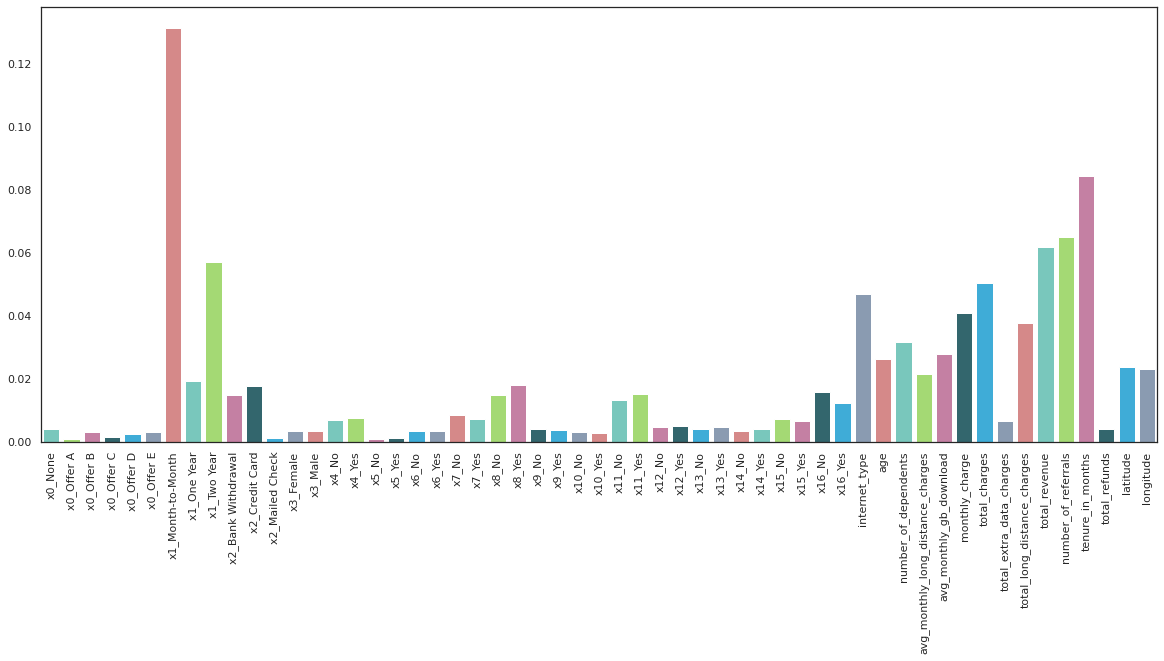

In [425]:
feature_importances = modelo_1.feature_importances_

fig, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x=all_pipe_cols,y=feature_importances,ax=ax,palette= cat_palette)
plt.xticks(rotation=90)
plt.show()

In [427]:
feature_importance_modelo_1 = pd.DataFrame({'columna':all_pipe_cols,'importancia':feature_importances * 100})
feature_importance_modelo_1 = feature_importance_modelo_1.sort_values('importancia',ascending=False)
feature_importance_modelo_1.head(15).reset_index(drop=True).style.background_gradient(cmap="Greens")

,columna,importancia
0,x1_Month-to-Month,13.155265
1,tenure_in_months,8.447613
2,number_of_referrals,6.503082
3,total_revenue,6.173313
4,x1_Two Year,5.701318
5,total_charges,5.046942
6,internet_type,4.691259
7,monthly_charge,4.091682
8,total_long_distance_charges,3.785812
9,number_of_dependents,3.175905


Interesante, no le importo las ofertas al modelo 1

# Modelos finales y Conclución

## Modelo 1

Bastante bien 90% acurracy recall y f1 es bueno para el negocio.

In [450]:
modelo_1 = RandomForestClassifier(n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                                        ,max_depth=80,bootstrap=True,random_state=0, n_jobs=-1)

modelo_1.fit(X_1_train,y_1_train)

#Guardo el modelo en un pickle
pickle.dump(modelo_1, open('modelo_1.pkl', 'wb'))

## Modelo 2

Si bien la accuracy del modelo no es muy alta (75%) es aceptable.

La baja accuracy se debe principalmente a la varianza y la poca cantidad de instancias en el dataset para churn category ya que el segundo modelo entrena solamente con los churned del dataset, que son aproximadamente un 30%.

Ademas el segundo modelo es complementario, no es el indispensable para el negocio. Se podria mejorar si se tubiesen mas datos (podrian provenir de los cuatrimestres pasados y de los datos que se tomen a futuro)

In [451]:
modelo_2 = RandomForestClassifier(max_depth= None,max_features=5,min_samples_split=3,min_samples_leaf=1,
                                  n_estimators=350,bootstrap=False, random_state=0, n_jobs=-1)

modelo_2.fit(X_2_prepared,y_2_prepared)

#Guardo el modelo en un pickle
pickle.dump(modelo_2, open('modelo_2.pkl', 'wb'))

## Veo como retornan los resultados los modelos para saber que predict proba cargar a cada 1

### Modelo 1

In [454]:
y_1_fitter.inverse_transform([modelo_1.predict(X_1_test_prepared)[2]])

array(['Churned'], dtype=object)

In [455]:
modelo_1.predict_proba(X_1_test_prepared)[2][0]

0.8084375000000003

Ok para el modelo 1 es la probabilidad de churn esta en el indice 0

### Modelo 2

In [459]:
y_2_fitter.inverse_transform(modelo_2.predict(X_2_prepared)[:10])

array(['Dissatisfaction', 'Other', 'Competitor', 'Price', 'Competitor',
       'Competitor', 'Attitude', 'Competitor', 'Competitor',
       'Dissatisfaction'], dtype=object)

In [458]:
modelo_2.predict_proba(X_2_prepared[:10])

array([[0.02285714, 0.05      , 0.87142857, 0.04428571, 0.01142857],
       [0.03571429, 0.08714286, 0.04142857, 0.81285714, 0.02285714],
       [0.02142857, 0.93714286, 0.01142857, 0.01857143, 0.01142857],
       [0.04      , 0.01857143, 0.00142857, 0.00142857, 0.93857143],
       [0.01142857, 0.95571429, 0.01142857, 0.01      , 0.01142857],
       [0.01142857, 0.94571429, 0.03285714, 0.00857143, 0.00142857],
       [0.92142857, 0.02714286, 0.03285714, 0.00714286, 0.01142857],
       [0.01428571, 0.94      , 0.01428571, 0.01142857, 0.02      ],
       [0.02      , 0.96571429, 0.00857143, 0.00142857, 0.00428571],
       [0.03857143, 0.08571429, 0.84571429, 0.01285714, 0.01714286]])

Indices del proba
* Dissatisfaction: 2
* Other: 3
* Competitor: 1
* Price: 4
* Attitude: 0

## Creo una pipe universal para los 2 modelos

Como nose si todas las categorias del onehot y ordinal se encontraron con almenos 1 instancia de cada cosa en el dataset, y ambos modelos usan la misma arquitectura voy a crear una pipe con todo el dataset para los 2 modelos y guardarla.


In [579]:
df = pd.read_csv('https://github.com/Lemonpi3/datasets-coderhouse/blob/main/telecom_customer_churn.csv?raw=true')

#normalizo las columnas del dataset para manejarlas de forma mas comoda con pandas
rename_dict = {}
cols = list(df.columns)
cols = [col.lower().replace(' ','_') for col in cols]

for key in list(df.columns):
    for value in cols:
        rename_dict[key] = value
        cols.remove(value)
        break

df = df.rename(rename_dict,axis=1)
df = df[df.customer_status != 'Joined']
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [580]:
df ,cat_idx = clean_nulls_dataset(df,[])

CAT: customer_id, 0
CAT: gender, 1
CAT: married, 3
CAT: city, 5
CAT: offer, 11
CAT: phone_service, 12
CAT: multiple_lines, 14
CAT: internet_service, 15
CAT: internet_type, 16
CAT: online_security, 18
CAT: online_backup, 19
CAT: device_protection_plan, 20
CAT: premium_tech_support, 21
CAT: streaming_tv, 22
CAT: streaming_movies, 23
CAT: streaming_music, 24
CAT: unlimited_data, 25
CAT: contract, 26
CAT: paperless_billing, 27
CAT: payment_method, 28
CAT: customer_status, 35
CAT: churn_category, 36
CAT: churn_reason, 37
------------------
Nulos Inicial:
------------------
customer_id                             0
gender                                  0
age                                     0
married                                 0
number_of_dependents                    0
city                                    0
zip_code                                0
latitude                                0
longitude                               0
number_of_referrals                     0
tenur

In [581]:
one_hot_cols = ['offer','contract','payment_method','gender','married','phone_service',
                'multiple_lines','internet_service','online_security','online_backup',
                'device_protection_plan','premium_tech_support','streaming_tv','streaming_movies',
                'streaming_music','unlimited_data','paperless_billing']
#la unica ordinal es internet type ya que esta ordenada por velocidad
ordinal_cols = ['internet_type']
#numericas
scaler_cols = ['age', 'number_of_dependents','avg_monthly_long_distance_charges',
               'avg_monthly_gb_download', 'monthly_charge', 'total_charges',
               'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue',
               'number_of_referrals', 'tenure_in_months', 'total_refunds','latitude', 'longitude']

In [582]:
one_hot = OneHotEncoder(handle_unknown='ignore')
ordinal = OrdinalEncoder(categories=[['No','Cable','DSL','Fiber Optic']])
rob_scaler = RobustScaler()

transformers=[
        ("one_hot", one_hot, one_hot_cols),
        ("ordinal", ordinal, ordinal_cols),
        ("std_scaler", rob_scaler, scaler_cols), 
    ]

#lo hago función por si quiero experimentar sin tener que reescribir todo
def create_pipe(transformers):
  preprocessor = ColumnTransformer(
      transformers=transformers,
      remainder ='drop',
      sparse_threshold=0
  )

  steps = [
    ("preprocessing",preprocessor),
    # ("feature selection",feature_selector),
  ]
  return Pipeline(steps)

pipe = create_pipe(transformers)
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['offer', 'contract',
                                                   'payment_method', 'gender',
                                                   'married', 'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                 

In [583]:
fitter = pipe.fit(df)

#creo una clase con la pipe y la funcion de limpiar nulos
class ModelsPipeline:
    def __init__(self):
        
        self.fitter = fitter
    
    def clean_nulls_dataset(self,df:pd.DataFrame,cols_to_drop:list)->tuple:
        '''Reemplaza Nulos numericos con 0 y Categoricos con No
        
        Retorna copia del imputado df limpio y lista de indices de las variables categoricas'''
        import pandas as pd

        df = df.drop(cols_to_drop,axis=1).copy()
        categorical_cols = []
        categorical_idx = []
        num_cols = []

        for i,col in enumerate(df.columns):
            if df[col].dtypes.str=='|O':
                categorical_idx.append(i)
                categorical_cols.append(col)
            else:
                num_cols.append(i)

        null_status = df.isna().sum()

        for col in categorical_cols:
            df[col].fillna('No',inplace=True)
        for col in numerical_cols:
            df[col].fillna(0,inplace=True)

        null_status = df.isna().sum()

        return df , categorical_idx


In [584]:
pickle.dump(ModelsPipeline(), open('ModelsPipeline.pkl', 'wb'))

# Implementación de los modelos

Los modelos va a estar implementado en una base de datos y van a volcar periodicamente sus resultados en una tabla llamada CustomerStatus donde se podra consultar que usuarios van a dejar el servicio por medio de una api hecha con flask.

A modo de simplificar la implementación voy a usar una base de datos de sqlite.

Usare el dataset como simulación de la base de datos.


>Si solo quieres probar la api corre las celdas de la seccion "Modelos finales y Conclución" en adelante


In [585]:
#Cargo los modelos y las pipelines
with (open("/content/modelo_1.pkl", "rb")) as f:
    modelo_1 = pickle.load(f)

with (open("/content/modelo_2.pkl", "rb")) as f:
    modelo_2 = pickle.load(f)

with (open("/content/ModelsPipeline.pkl", "rb")) as f:
    pipeline = pickle.load(f)


## Cargo dataset inicial y creo la base de datos

In [586]:
df = pd.read_csv('https://github.com/Lemonpi3/coderhouse-DS-repo/blob/master/Datasets/telecom_customer_churn.csv?raw=true')
conn = sql.connect('Clients.db', check_same_thread=False)

cols = list(df.columns)
cols = [col.lower().replace(' ','_') for col in cols]

rename_dict = {}
for key in list(df.columns):
    for value in cols:
        rename_dict[key] = value
        cols.remove(value)
        break
print(rename_dict)

df = df.rename(rename_dict,axis=1)
df.head()

{'Customer ID': 'customer_id', 'Gender': 'gender', 'Age': 'age', 'Married': 'married', 'Number of Dependents': 'number_of_dependents', 'City': 'city', 'Zip Code': 'zip_code', 'Latitude': 'latitude', 'Longitude': 'longitude', 'Number of Referrals': 'number_of_referrals', 'Tenure in Months': 'tenure_in_months', 'Offer': 'offer', 'Phone Service': 'phone_service', 'Avg Monthly Long Distance Charges': 'avg_monthly_long_distance_charges', 'Multiple Lines': 'multiple_lines', 'Internet Service': 'internet_service', 'Internet Type': 'internet_type', 'Avg Monthly GB Download': 'avg_monthly_gb_download', 'Online Security': 'online_security', 'Online Backup': 'online_backup', 'Device Protection Plan': 'device_protection_plan', 'Premium Tech Support': 'premium_tech_support', 'Streaming TV': 'streaming_tv', 'Streaming Movies': 'streaming_movies', 'Streaming Music': 'streaming_music', 'Unlimited Data': 'unlimited_data', 'Contract': 'contract', 'Paperless Billing': 'paperless_billing', 'Payment Method

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [587]:
#customer_cols para crear las tablas
customers_cols_str = ', '.join(list(rename_dict.values())[:-3])
customers_cols_str

'customer_id, gender, age, married, number_of_dependents, city, zip_code, latitude, longitude, number_of_referrals, tenure_in_months, offer, phone_service, avg_monthly_long_distance_charges, multiple_lines, internet_service, internet_type, avg_monthly_gb_download, online_security, online_backup, device_protection_plan, premium_tech_support, streaming_tv, streaming_movies, streaming_music, unlimited_data, contract, paperless_billing, payment_method, monthly_charge, total_charges, total_refunds, total_extra_data_charges, total_long_distance_charges, total_revenue'

In [588]:
cur = conn.cursor()
# cur.execute('DROP TABLE Customers')
# cur.execute('DROP TABLE CustomerStatus')

In [589]:
cur.execute(f'''CREATE TABLE IF NOT EXISTS Customers({customers_cols_str})''')
cur.execute(f'''CREATE TABLE IF NOT EXISTS CustomerStatus(
                                                customer_id, churn_chance, competitor_reason_chance, 
                                                dissatisfaction_reason_chance, price_reason_chance, attitude_reason_chance)''')

In [590]:
df[list(rename_dict.values())[:-3]].to_sql('Customers',con=conn,if_exists='replace',index=False)

In [591]:
#Checkeo que todo este bien
pd.read_sql('SELECT * FROM Customers', con=conn).head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54


In [592]:
#Checkeo que todo este bien
pd.read_sql('SELECT * FROM CustomerStatus', con=conn).head()

,customer_id,churn_chance,competitor_reason_chance,dissatisfaction_reason_chance,price_reason_chance,attitude_reason_chance,other_reason_chance
0,0002-ORFBO,42.02,0.00,0.00,0.00,0.00,0.00
1,0003-MKNFE,68.99,21.29,25.57,18.71,22.71,11.71
2,0004-TLHLJ,99.35,30.57,19.29,21.57,13.71,14.86
3,0011-IGKFF,86.93,19.14,31.29,4.57,38.57,6.43
4,0013-EXCHZ,94.86,16.43,40.86,17.29,13.29,12.14


In [593]:
conn.close()

In [594]:
conn = sql.connect('Clients.db', check_same_thread=False)
customers_df = pd.read_sql('SELECT * FROM Customers',con=conn)
customers_df

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.60,593.30,0.00,0,381.51,974.81
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.00,542.40,38.33,10,96.21,610.28
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.90,267.40,0.00,0,22.14,289.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,13,Offer D,Yes,46.68,No,Yes,DSL,59.0,Yes,No,No,Yes,No,No,Yes,Yes,One Year,No,Credit Card,55.15,742.90,0.00,0,606.84,1349.74
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,22,Offer D,Yes,16.20,Yes,Yes,Fiber Optic,17.0,No,No,No,No,No,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,2,Offer E,Yes,18.62,No,Yes,DSL,51.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,50.30,92.75,0.00,0,37.24,129.99
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,67,Offer A,Yes,2.12,No,Yes,Cable,58.0,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Two Year,No,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69


## Creo la función de update para la api

In [597]:
def update_customer_status_db():
    import pandas as pd
    import sqlite3 as sql
    import pickle

    with (open("/content/modelo_1.pkl", "rb")) as f:
        modelo_1 = pickle.load(f)

    with (open("/content/modelo_2.pkl", "rb")) as f:
        modelo_2 = pickle.load(f)

    with (open("/content/ModelsPipeline.pkl", "rb")) as f:
        pipeline = pickle.load(f)

    conn = sql.connect('Clients.db', check_same_thread=False)
    customers_df = pd.read_sql('SELECT * FROM Customers',con=conn)
    #instancio el df con las ids y las listas q contendran lso resultados
    predicts = pd.DataFrame(customers_df.customer_id)
    churn_chance = []
    competitor_reason_chance=[]
    dissatisfaction_reason_chance=[]
    price_reason_chance=[]
    attitude_reason_chance=[]
    other_reason_chance=[]

    #Preds Modelo 1
    data, _ = pipeline.clean_nulls_dataset(df,[])
    data = pipeline.fitter.transform(data)
    preds_1 = modelo_1.predict_proba(data)[:len(data)]
    for pred in preds_1:
        churn_chance.append(round(pred[0]*100,2))

    predicts['churn_chance'] = churn_chance
    
    #Creo las columnas del dataframe
    predicts['competitor_reason_chance'] = 0
    predicts['dissatisfaction_reason_chance'] = 0
    predicts['price_reason_chance'] = 0
    predicts['attitude_reason_chance'] = 0
    predicts['other_reason_chance'] = 0

    #Seleciono las ids de los q van a churnear
    ids = predicts.loc[predicts.churn_chance >= 50].customer_id.to_list()

    #Preds Modelo 2
    data, _ = pipeline.clean_nulls_dataset(customers_df[customers_df.customer_id.isin(ids)],[])
    data = pipeline.fitter.transform(data)

    preds_2 = modelo_2.predict_proba(data)[:len(data)]

    for pred in preds_2:
        attitude_reason_chance.append(round(pred[0]*100,2))
        competitor_reason_chance.append(round(pred[1]*100,2))
        dissatisfaction_reason_chance.append(round(pred[2]*100,2))
        other_reason_chance.append(round(pred[3]*100,2))
        price_reason_chance.append(round(pred[4]*100,2))

    #Cargo las predicciones del modelo 2
    predicts.loc[predicts.churn_chance >= 50,'competitor_reason_chance'] = competitor_reason_chance
    predicts.loc[predicts.churn_chance >= 50,'dissatisfaction_reason_chance'] = dissatisfaction_reason_chance
    predicts.loc[predicts.churn_chance >= 50,'price_reason_chance'] = price_reason_chance
    predicts.loc[predicts.churn_chance >= 50,'attitude_reason_chance'] = attitude_reason_chance
    predicts.loc[predicts.churn_chance >= 50,'other_reason_chance'] = other_reason_chance

    #vuelco la tabla
    predicts.to_sql('CustomerStatus',con=conn,if_exists='replace',index=False)
    conn.close()

## Creo la API

In [600]:
app = Flask("Model API")
api = Api(app)

#para que la url defecto no tire error
class MainAPI(Resource):
    def get(self):
        return { "error":'No action passed'}

class ModelAPI(Resource):
    '''
    GET: 
    * /update_customer_status_db : Updates CustomerStatus Table with model predictions ---> returns "200": "updated_customer_status_db"
    * /get_users_to_churn : Returns all users with 50% or more churn chance from CustomerStatus Table ---> returns json_object(customer_id, churn_chance, 
                                competitor_reason_chance, dissatisfaction_reason_chance, price_reason_chance, attitude_reason_chance)
    '''
    def get(self,action):
        #Obtener la tabla con los posibles churned
        if action == 'get_users_to_churn':
            conn = sql.connect('Clients.db', check_same_thread=False)
            cur = conn.cursor()

            data = cur.execute("""SELECT  
                                json_object(
                                    'customer_id', customer_id,
                                    'churn_chance', churn_chance,
                                    'competitor_reason_chance', competitor_reason_chance,
                                    'dissatisfaction_reason_chance', dissatisfaction_reason_chance,
                                    'price_reason_chance', price_reason_chance,
                                    'attitude_reason_chance', attitude_reason_chance
                                ) 
                    FROM CustomerStatus
                    WHERE churn_chance >= 50""").fetchall()
            conn.close()
            return data
        #predecir
        elif action == 'update_customer_status_db':
            update_customer_status_db()
            return {"200": "updated_customer_status_db"}
        
        
api.add_resource(MainAPI, '/') 
api.add_resource(ModelAPI, '/<action>') 

run_with_ngrok(app)

## Corre la API

* https:// url de ngrok/update_customer_status_db : updatea la tabla de predicts
* https:// url de ngrok/get_users_to_churn  : retorna los usuarios con 50% o mas de dejar el servicio como json

In [601]:
app.run()

 * Running on http://9495-35-237-97-96.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
